In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(566671, 828)
(566671, 8)
validation
(80437, 828)
(80437, 8)
test
(67038, 828)
(67038, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/57 [..............................] - ETA: 1:39 - loss: 2.2407 - STD: 0.0760 - MAE: 0.2188

 4/57 [=>............................] - ETA: 1s - loss: 1.7456 - STD: 0.1361 - MAE: 0.1780  

 5/57 [=>............................] - ETA: 2s - loss: 1.6943 - STD: 0.1565 - MAE: 0.1689

 6/57 [==>...........................] - ETA: 2s - loss: 1.6584 - STD: 0.1711 - MAE: 0.1625

 7/57 [==>...........................] - ETA: 2s - loss: 1.6268 - STD: 0.1811 - MAE: 0.1579

 8/57 [===>..........................] - ETA: 2s - loss: 1.5981 - STD: 0.1873 - MAE: 0.1548

 9/57 [===>..........................] - ETA: 2s - loss: 1.5727 - STD: 0.1905 - MAE: 0.1529

10/57 [====>.........................] - ETA: 2s - loss: 1.5507 - STD: 0.1913 - MAE: 0.1521

11/57 [====>.........................] - ETA: 2s - loss: 1.5352 - STD: 0.1903 - MAE: 0.1521

12/57 [=====>........................] - ETA: 2s - loss: 1.5221 - STD: 0.1884 - MAE: 0.1526

13/57 [=====>........................] - ETA: 2s - loss: 1.5116 - STD: 0.1860 - MAE: 0.1532

14/57 [======>.......................] - ETA: 5s - loss: 1.5058 - STD: 0.1838 - MAE: 0.1539

17/57 [=======>......................] - ETA: 4s - loss: 1.4848 - STD: 0.1798 - MAE: 0.1550

19/57 [=========>....................] - ETA: 3s - loss: 1.4722 - STD: 0.1799 - MAE: 0.1547

20/57 [=========>....................] - ETA: 3s - loss: 1.4660 - STD: 0.1805 - MAE: 0.1543

21/57 [==========>...................] - ETA: 3s - loss: 1.4617 - STD: 0.1814 - MAE: 0.1539

22/57 [==========>...................] - ETA: 3s - loss: 1.4570 - STD: 0.1824 - MAE: 0.1534

23/57 [===========>..................] - ETA: 3s - loss: 1.4530 - STD: 0.1835 - MAE: 0.1529

24/57 [===========>..................] - ETA: 3s - loss: 1.4492 - STD: 0.1844 - MAE: 0.1525

25/57 [============>.................] - ETA: 3s - loss: 1.4465 - STD: 0.1852 - MAE: 0.1521

26/57 [============>.................] - ETA: 2s - loss: 1.4435 - STD: 0.1858 - MAE: 0.1518

27/57 [=============>................] - ETA: 2s - loss: 1.4400 - STD: 0.1862 - MAE: 0.1516

28/57 [=============>................] - ETA: 2s - loss: 1.4377 - STD: 0.1865 - MAE: 0.1515

29/57 [==============>...............] - ETA: 2s - loss: 1.4350 - STD: 0.1865 - MAE: 0.1514

30/57 [==============>...............] - ETA: 2s - loss: 1.4329 - STD: 0.1863 - MAE: 0.1514

31/57 [===============>..............] - ETA: 2s - loss: 1.4308 - STD: 0.1861 - MAE: 0.1514

32/57 [===============>..............] - ETA: 2s - loss: 1.4281 - STD: 0.1857 - MAE: 0.1515

33/57 [================>.............] - ETA: 2s - loss: 1.4261 - STD: 0.1854 - MAE: 0.1516

34/57 [================>.............] - ETA: 2s - loss: 1.4246 - STD: 0.1851 - MAE: 0.1517

35/57 [=================>............] - ETA: 1s - loss: 1.4229 - STD: 0.1848 - MAE: 0.1517

36/57 [=================>............] - ETA: 1s - loss: 1.4214 - STD: 0.1846 - MAE: 0.1518

37/57 [==================>...........] - ETA: 1s - loss: 1.4195 - STD: 0.1845 - MAE: 0.1518

38/57 [===================>..........] - ETA: 1s - loss: 1.4181 - STD: 0.1844 - MAE: 0.1518

39/57 [===================>..........] - ETA: 1s - loss: 1.4162 - STD: 0.1845 - MAE: 0.1517

40/57 [====================>.........] - ETA: 1s - loss: 1.4150 - STD: 0.1846 - MAE: 0.1516

41/57 [====================>.........] - ETA: 1s - loss: 1.4135 - STD: 0.1848 - MAE: 0.1515

42/57 [=====================>........] - ETA: 1s - loss: 1.4120 - STD: 0.1849 - MAE: 0.1514

43/57 [=====================>........] - ETA: 1s - loss: 1.4110 - STD: 0.1851 - MAE: 0.1513

44/57 [======================>.......] - ETA: 1s - loss: 1.4098 - STD: 0.1853 - MAE: 0.1512

45/57 [======================>.......] - ETA: 0s - loss: 1.4092 - STD: 0.1855 - MAE: 0.1512

46/57 [=======================>......] - ETA: 0s - loss: 1.4079 - STD: 0.1856 - MAE: 0.1511

47/57 [=======================>......] - ETA: 0s - loss: 1.4071 - STD: 0.1856 - MAE: 0.1511

48/57 [========================>.....] - ETA: 0s - loss: 1.4059 - STD: 0.1856 - MAE: 0.1510

49/57 [========================>.....] - ETA: 0s - loss: 1.4051 - STD: 0.1856 - MAE: 0.1510

50/57 [=========================>....] - ETA: 0s - loss: 1.4040 - STD: 0.1855 - MAE: 0.1511

51/57 [=========================>....] - ETA: 0s - loss: 1.4027 - STD: 0.1854 - MAE: 0.1511

52/57 [==========================>...] - ETA: 0s - loss: 1.4019 - STD: 0.1853 - MAE: 0.1511

53/57 [==========================>...] - ETA: 0s - loss: 1.4014 - STD: 0.1852 - MAE: 0.1511

54/57 [===========================>..] - ETA: 0s - loss: 1.4004 - STD: 0.1851 - MAE: 0.1511

55/57 [===========================>..] - ETA: 0s - loss: 1.3995 - STD: 0.1850 - MAE: 0.1511

56/57 [============================>.] - ETA: 0s - loss: 1.3987 - STD: 0.1850 - MAE: 0.1511

57/57 [==============================] - ETA: 0s - loss: 1.3982 - STD: 0.1850 - MAE: 0.1511

57/57 [==============================] - 7s 90ms/step - loss: 1.3982 - STD: 0.1850 - MAE: 0.1511 - val_loss: 1.3352 - val_STD: 0.1865 - val_MAE: 0.1479


Epoch 2/10000


 1/57 [..............................] - ETA: 5s - loss: 1.3592 - STD: 0.1865 - MAE: 0.1496

 2/57 [>.............................] - ETA: 3s - loss: 1.3679 - STD: 0.1870 - MAE: 0.1499

 3/57 [>.............................] - ETA: 3s - loss: 1.3663 - STD: 0.1873 - MAE: 0.1497

 4/57 [=>............................] - ETA: 3s - loss: 1.3644 - STD: 0.1874 - MAE: 0.1496

 5/57 [=>............................] - ETA: 3s - loss: 1.3691 - STD: 0.1874 - MAE: 0.1499

 6/57 [==>...........................] - ETA: 3s - loss: 1.3676 - STD: 0.1871 - MAE: 0.1500

 7/57 [==>...........................] - ETA: 3s - loss: 1.3676 - STD: 0.1867 - MAE: 0.1501

 8/57 [===>..........................] - ETA: 3s - loss: 1.3660 - STD: 0.1862 - MAE: 0.1502

 9/57 [===>..........................] - ETA: 3s - loss: 1.3645 - STD: 0.1857 - MAE: 0.1503

11/57 [====>.........................] - ETA: 2s - loss: 1.3640 - STD: 0.1849 - MAE: 0.1506

12/57 [=====>........................] - ETA: 2s - loss: 1.3654 - STD: 0.1847 - MAE: 0.1507

13/57 [=====>........................] - ETA: 2s - loss: 1.3651 - STD: 0.1845 - MAE: 0.1508

14/57 [======>.......................] - ETA: 2s - loss: 1.3650 - STD: 0.1844 - MAE: 0.1508

15/57 [======>.......................] - ETA: 2s - loss: 1.3648 - STD: 0.1844 - MAE: 0.1508

16/57 [=======>......................] - ETA: 2s - loss: 1.3633 - STD: 0.1844 - MAE: 0.1507

17/57 [=======>......................] - ETA: 2s - loss: 1.3647 - STD: 0.1845 - MAE: 0.1508

18/57 [========>.....................] - ETA: 2s - loss: 1.3634 - STD: 0.1846 - MAE: 0.1507

19/57 [=========>....................] - ETA: 2s - loss: 1.3623 - STD: 0.1847 - MAE: 0.1506

20/57 [=========>....................] - ETA: 2s - loss: 1.3618 - STD: 0.1848 - MAE: 0.1505

21/57 [==========>...................] - ETA: 2s - loss: 1.3608 - STD: 0.1849 - MAE: 0.1504

22/57 [==========>...................] - ETA: 2s - loss: 1.3604 - STD: 0.1850 - MAE: 0.1503

23/57 [===========>..................] - ETA: 2s - loss: 1.3599 - STD: 0.1851 - MAE: 0.1502

24/57 [===========>..................] - ETA: 1s - loss: 1.3597 - STD: 0.1852 - MAE: 0.1502

25/57 [============>.................] - ETA: 1s - loss: 1.3592 - STD: 0.1853 - MAE: 0.1502

26/57 [============>.................] - ETA: 1s - loss: 1.3593 - STD: 0.1853 - MAE: 0.1501

27/57 [=============>................] - ETA: 1s - loss: 1.3596 - STD: 0.1853 - MAE: 0.1502

28/57 [=============>................] - ETA: 1s - loss: 1.3590 - STD: 0.1853 - MAE: 0.1502

29/57 [==============>...............] - ETA: 1s - loss: 1.3588 - STD: 0.1852 - MAE: 0.1502

30/57 [==============>...............] - ETA: 1s - loss: 1.3583 - STD: 0.1852 - MAE: 0.1502

31/57 [===============>..............] - ETA: 1s - loss: 1.3587 - STD: 0.1851 - MAE: 0.1502

32/57 [===============>..............] - ETA: 1s - loss: 1.3588 - STD: 0.1851 - MAE: 0.1502

33/57 [================>.............] - ETA: 1s - loss: 1.3593 - STD: 0.1850 - MAE: 0.1503

34/57 [================>.............] - ETA: 1s - loss: 1.3589 - STD: 0.1850 - MAE: 0.1503

35/57 [=================>............] - ETA: 1s - loss: 1.3585 - STD: 0.1849 - MAE: 0.1502

36/57 [=================>............] - ETA: 1s - loss: 1.3587 - STD: 0.1849 - MAE: 0.1503

37/57 [==================>...........] - ETA: 1s - loss: 1.3581 - STD: 0.1849 - MAE: 0.1502

38/57 [===================>..........] - ETA: 1s - loss: 1.3582 - STD: 0.1849 - MAE: 0.1502

39/57 [===================>..........] - ETA: 1s - loss: 1.3575 - STD: 0.1849 - MAE: 0.1502

40/57 [====================>.........] - ETA: 1s - loss: 1.3575 - STD: 0.1850 - MAE: 0.1502

41/57 [====================>.........] - ETA: 0s - loss: 1.3571 - STD: 0.1850 - MAE: 0.1502

42/57 [=====================>........] - ETA: 0s - loss: 1.3575 - STD: 0.1850 - MAE: 0.1502

43/57 [=====================>........] - ETA: 0s - loss: 1.3574 - STD: 0.1850 - MAE: 0.1502

44/57 [======================>.......] - ETA: 0s - loss: 1.3572 - STD: 0.1850 - MAE: 0.1502

45/57 [======================>.......] - ETA: 0s - loss: 1.3568 - STD: 0.1849 - MAE: 0.1502

46/57 [=======================>......] - ETA: 0s - loss: 1.3565 - STD: 0.1849 - MAE: 0.1502

47/57 [=======================>......] - ETA: 0s - loss: 1.3559 - STD: 0.1848 - MAE: 0.1502

48/57 [========================>.....] - ETA: 0s - loss: 1.3557 - STD: 0.1848 - MAE: 0.1501

49/57 [========================>.....] - ETA: 0s - loss: 1.3551 - STD: 0.1848 - MAE: 0.1501

50/57 [=========================>....] - ETA: 0s - loss: 1.3544 - STD: 0.1848 - MAE: 0.1501

51/57 [=========================>....] - ETA: 0s - loss: 1.3539 - STD: 0.1848 - MAE: 0.1501

52/57 [==========================>...] - ETA: 0s - loss: 1.3532 - STD: 0.1848 - MAE: 0.1500

53/57 [==========================>...] - ETA: 0s - loss: 1.3526 - STD: 0.1848 - MAE: 0.1500

54/57 [===========================>..] - ETA: 0s - loss: 1.3521 - STD: 0.1849 - MAE: 0.1500

55/57 [===========================>..] - ETA: 0s - loss: 1.3516 - STD: 0.1849 - MAE: 0.1499

56/57 [============================>.] - ETA: 0s - loss: 1.3509 - STD: 0.1849 - MAE: 0.1499

57/57 [==============================] - ETA: 0s - loss: 1.3501 - STD: 0.1849 - MAE: 0.1498

57/57 [==============================] - 4s 64ms/step - loss: 1.3501 - STD: 0.1849 - MAE: 0.1498 - val_loss: 1.2878 - val_STD: 0.1927 - val_MAE: 0.1433


Epoch 3/10000


 1/57 [..............................] - ETA: 5s - loss: 1.3169 - STD: 0.1884 - MAE: 0.1468

 2/57 [>.............................] - ETA: 3s - loss: 1.3160 - STD: 0.1887 - MAE: 0.1466

 3/57 [>.............................] - ETA: 3s - loss: 1.3184 - STD: 0.1888 - MAE: 0.1469

 4/57 [=>............................] - ETA: 3s - loss: 1.3130 - STD: 0.1882 - MAE: 0.1469

 5/57 [=>............................] - ETA: 3s - loss: 1.3141 - STD: 0.1874 - MAE: 0.1471

 6/57 [==>...........................] - ETA: 3s - loss: 1.3116 - STD: 0.1869 - MAE: 0.1472

 7/57 [==>...........................] - ETA: 3s - loss: 1.3115 - STD: 0.1867 - MAE: 0.1473

 8/57 [===>..........................] - ETA: 3s - loss: 1.3101 - STD: 0.1868 - MAE: 0.1472

 9/57 [===>..........................] - ETA: 2s - loss: 1.3078 - STD: 0.1870 - MAE: 0.1470

10/57 [====>.........................] - ETA: 2s - loss: 1.3063 - STD: 0.1873 - MAE: 0.1468

11/57 [====>.........................] - ETA: 2s - loss: 1.3044 - STD: 0.1876 - MAE: 0.1466

12/57 [=====>........................] - ETA: 2s - loss: 1.3046 - STD: 0.1878 - MAE: 0.1465

13/57 [=====>........................] - ETA: 2s - loss: 1.3037 - STD: 0.1878 - MAE: 0.1465

14/57 [======>.......................] - ETA: 2s - loss: 1.3017 - STD: 0.1878 - MAE: 0.1464

15/57 [======>.......................] - ETA: 2s - loss: 1.3007 - STD: 0.1881 - MAE: 0.1462

16/57 [=======>......................] - ETA: 2s - loss: 1.2998 - STD: 0.1887 - MAE: 0.1460

17/57 [=======>......................] - ETA: 2s - loss: 1.2993 - STD: 0.1889 - MAE: 0.1459

18/57 [========>.....................] - ETA: 2s - loss: 1.2979 - STD: 0.1888 - MAE: 0.1459

19/57 [=========>....................] - ETA: 2s - loss: 1.2967 - STD: 0.1887 - MAE: 0.1459

20/57 [=========>....................] - ETA: 2s - loss: 1.2963 - STD: 0.1889 - MAE: 0.1458

21/57 [==========>...................] - ETA: 2s - loss: 1.2952 - STD: 0.1891 - MAE: 0.1457

22/57 [==========>...................] - ETA: 2s - loss: 1.2941 - STD: 0.1893 - MAE: 0.1456

23/57 [===========>..................] - ETA: 2s - loss: 1.2941 - STD: 0.1893 - MAE: 0.1455

24/57 [===========>..................] - ETA: 2s - loss: 1.2938 - STD: 0.1894 - MAE: 0.1455

25/57 [============>.................] - ETA: 1s - loss: 1.2933 - STD: 0.1894 - MAE: 0.1455

26/57 [============>.................] - ETA: 1s - loss: 1.2931 - STD: 0.1896 - MAE: 0.1455

27/57 [=============>................] - ETA: 1s - loss: 1.2923 - STD: 0.1897 - MAE: 0.1454

29/57 [==============>...............] - ETA: 1s - loss: 1.2904 - STD: 0.1897 - MAE: 0.1453

30/57 [==============>...............] - ETA: 1s - loss: 1.2896 - STD: 0.1899 - MAE: 0.1452

31/57 [===============>..............] - ETA: 1s - loss: 1.2888 - STD: 0.1899 - MAE: 0.1452

32/57 [===============>..............] - ETA: 1s - loss: 1.2878 - STD: 0.1899 - MAE: 0.1452

33/57 [================>.............] - ETA: 1s - loss: 1.2864 - STD: 0.1901 - MAE: 0.1451

34/57 [================>.............] - ETA: 1s - loss: 1.2850 - STD: 0.1904 - MAE: 0.1449

35/57 [=================>............] - ETA: 1s - loss: 1.2838 - STD: 0.1904 - MAE: 0.1448

36/57 [=================>............] - ETA: 1s - loss: 1.2826 - STD: 0.1905 - MAE: 0.1448

37/57 [==================>...........] - ETA: 1s - loss: 1.2811 - STD: 0.1907 - MAE: 0.1446

38/57 [===================>..........] - ETA: 1s - loss: 1.2801 - STD: 0.1910 - MAE: 0.1445

39/57 [===================>..........] - ETA: 1s - loss: 1.2799 - STD: 0.1909 - MAE: 0.1445

40/57 [====================>.........] - ETA: 1s - loss: 1.2784 - STD: 0.1909 - MAE: 0.1445

41/57 [====================>.........] - ETA: 0s - loss: 1.2773 - STD: 0.1914 - MAE: 0.1443

42/57 [=====================>........] - ETA: 0s - loss: 1.2762 - STD: 0.1915 - MAE: 0.1442

43/57 [=====================>........] - ETA: 0s - loss: 1.2759 - STD: 0.1911 - MAE: 0.1443

44/57 [======================>.......] - ETA: 0s - loss: 1.2750 - STD: 0.1911 - MAE: 0.1443

45/57 [======================>.......] - ETA: 0s - loss: 1.2742 - STD: 0.1914 - MAE: 0.1442

46/57 [=======================>......] - ETA: 0s - loss: 1.2733 - STD: 0.1916 - MAE: 0.1440

47/57 [=======================>......] - ETA: 0s - loss: 1.2725 - STD: 0.1915 - MAE: 0.1441

48/57 [========================>.....] - ETA: 0s - loss: 1.2717 - STD: 0.1914 - MAE: 0.1441

49/57 [========================>.....] - ETA: 0s - loss: 1.2708 - STD: 0.1916 - MAE: 0.1440

50/57 [=========================>....] - ETA: 0s - loss: 1.2702 - STD: 0.1919 - MAE: 0.1439

51/57 [=========================>....] - ETA: 0s - loss: 1.2692 - STD: 0.1919 - MAE: 0.1438

52/57 [==========================>...] - ETA: 0s - loss: 1.2681 - STD: 0.1918 - MAE: 0.1438

53/57 [==========================>...] - ETA: 0s - loss: 1.2667 - STD: 0.1919 - MAE: 0.1437

54/57 [===========================>..] - ETA: 0s - loss: 1.2659 - STD: 0.1921 - MAE: 0.1436

55/57 [===========================>..] - ETA: 0s - loss: 1.2648 - STD: 0.1923 - MAE: 0.1435

56/57 [============================>.] - ETA: 0s - loss: 1.2642 - STD: 0.1922 - MAE: 0.1435

57/57 [==============================] - ETA: 0s - loss: 1.2637 - STD: 0.1922 - MAE: 0.1435

57/57 [==============================] - 4s 65ms/step - loss: 1.2637 - STD: 0.1922 - MAE: 0.1435 - val_loss: 1.1859 - val_STD: 0.2087 - val_MAE: 0.1329


Epoch 4/10000


 1/57 [..............................] - ETA: 5s - loss: 1.1981 - STD: 0.2031 - MAE: 0.1363

 2/57 [>.............................] - ETA: 3s - loss: 1.1961 - STD: 0.2035 - MAE: 0.1364

 3/57 [>.............................] - ETA: 3s - loss: 1.1913 - STD: 0.1999 - MAE: 0.1376

 4/57 [=>............................] - ETA: 3s - loss: 1.1967 - STD: 0.1976 - MAE: 0.1388

 5/57 [=>............................] - ETA: 3s - loss: 1.1991 - STD: 0.1971 - MAE: 0.1391

 6/57 [==>...........................] - ETA: 3s - loss: 1.2011 - STD: 0.1974 - MAE: 0.1391

 7/57 [==>...........................] - ETA: 3s - loss: 1.2016 - STD: 0.1978 - MAE: 0.1390

 8/57 [===>..........................] - ETA: 2s - loss: 1.2010 - STD: 0.1973 - MAE: 0.1391

 9/57 [===>..........................] - ETA: 2s - loss: 1.2019 - STD: 0.1971 - MAE: 0.1392

10/57 [====>.........................] - ETA: 2s - loss: 1.2003 - STD: 0.1971 - MAE: 0.1391

11/57 [====>.........................] - ETA: 2s - loss: 1.2000 - STD: 0.1971 - MAE: 0.1391

12/57 [=====>........................] - ETA: 2s - loss: 1.1992 - STD: 0.1971 - MAE: 0.1390

13/57 [=====>........................] - ETA: 2s - loss: 1.1973 - STD: 0.1974 - MAE: 0.1388

14/57 [======>.......................] - ETA: 2s - loss: 1.1965 - STD: 0.1974 - MAE: 0.1388

15/57 [======>.......................] - ETA: 2s - loss: 1.1949 - STD: 0.1971 - MAE: 0.1388

16/57 [=======>......................] - ETA: 2s - loss: 1.1935 - STD: 0.1974 - MAE: 0.1386

17/57 [=======>......................] - ETA: 2s - loss: 1.1918 - STD: 0.1976 - MAE: 0.1384

18/57 [========>.....................] - ETA: 2s - loss: 1.1890 - STD: 0.1974 - MAE: 0.1383

19/57 [=========>....................] - ETA: 2s - loss: 1.1881 - STD: 0.1983 - MAE: 0.1379

20/57 [=========>....................] - ETA: 2s - loss: 1.1860 - STD: 0.1981 - MAE: 0.1378

21/57 [==========>...................] - ETA: 2s - loss: 1.1842 - STD: 0.1978 - MAE: 0.1378

22/57 [==========>...................] - ETA: 2s - loss: 1.1835 - STD: 0.1985 - MAE: 0.1375

23/57 [===========>..................] - ETA: 2s - loss: 1.1816 - STD: 0.1985 - MAE: 0.1374

24/57 [===========>..................] - ETA: 2s - loss: 1.1802 - STD: 0.1985 - MAE: 0.1374

25/57 [============>.................] - ETA: 1s - loss: 1.1782 - STD: 0.1987 - MAE: 0.1372

26/57 [============>.................] - ETA: 1s - loss: 1.1762 - STD: 0.1992 - MAE: 0.1368

27/57 [=============>................] - ETA: 1s - loss: 1.1749 - STD: 0.1992 - MAE: 0.1368

28/57 [=============>................] - ETA: 1s - loss: 1.1738 - STD: 0.1992 - MAE: 0.1367

29/57 [==============>...............] - ETA: 1s - loss: 1.1722 - STD: 0.1997 - MAE: 0.1364

30/57 [==============>...............] - ETA: 1s - loss: 1.1711 - STD: 0.1998 - MAE: 0.1363

31/57 [===============>..............] - ETA: 1s - loss: 1.1705 - STD: 0.1997 - MAE: 0.1363

32/57 [===============>..............] - ETA: 1s - loss: 1.1691 - STD: 0.2001 - MAE: 0.1361

33/57 [================>.............] - ETA: 1s - loss: 1.1673 - STD: 0.2004 - MAE: 0.1359

34/57 [================>.............] - ETA: 1s - loss: 1.1662 - STD: 0.2005 - MAE: 0.1358

35/57 [=================>............] - ETA: 1s - loss: 1.1649 - STD: 0.2007 - MAE: 0.1357

37/57 [==================>...........] - ETA: 1s - loss: 1.1627 - STD: 0.2011 - MAE: 0.1354

38/57 [===================>..........] - ETA: 1s - loss: 1.1617 - STD: 0.2013 - MAE: 0.1353

39/57 [===================>..........] - ETA: 1s - loss: 1.1605 - STD: 0.2016 - MAE: 0.1351

40/57 [====================>.........] - ETA: 1s - loss: 1.1592 - STD: 0.2017 - MAE: 0.1350

41/57 [====================>.........] - ETA: 0s - loss: 1.1582 - STD: 0.2018 - MAE: 0.1349

42/57 [=====================>........] - ETA: 0s - loss: 1.1574 - STD: 0.2021 - MAE: 0.1348

43/57 [=====================>........] - ETA: 0s - loss: 1.1564 - STD: 0.2022 - MAE: 0.1347

44/57 [======================>.......] - ETA: 0s - loss: 1.1551 - STD: 0.2024 - MAE: 0.1345

45/57 [======================>.......] - ETA: 0s - loss: 1.1539 - STD: 0.2027 - MAE: 0.1344

46/57 [=======================>......] - ETA: 0s - loss: 1.1528 - STD: 0.2027 - MAE: 0.1343

47/57 [=======================>......] - ETA: 0s - loss: 1.1516 - STD: 0.2029 - MAE: 0.1341

48/57 [========================>.....] - ETA: 0s - loss: 1.1502 - STD: 0.2032 - MAE: 0.1340

49/57 [========================>.....] - ETA: 0s - loss: 1.1495 - STD: 0.2032 - MAE: 0.1339

50/57 [=========================>....] - ETA: 0s - loss: 1.1487 - STD: 0.2033 - MAE: 0.1339

51/57 [=========================>....] - ETA: 0s - loss: 1.1477 - STD: 0.2036 - MAE: 0.1337

52/57 [==========================>...] - ETA: 0s - loss: 1.1466 - STD: 0.2036 - MAE: 0.1336

53/57 [==========================>...] - ETA: 0s - loss: 1.1457 - STD: 0.2038 - MAE: 0.1335

54/57 [===========================>..] - ETA: 0s - loss: 1.1450 - STD: 0.2040 - MAE: 0.1334

55/57 [===========================>..] - ETA: 0s - loss: 1.1444 - STD: 0.2040 - MAE: 0.1334

56/57 [============================>.] - ETA: 0s - loss: 1.1436 - STD: 0.2041 - MAE: 0.1333

57/57 [==============================] - ETA: 0s - loss: 1.1427 - STD: 0.2043 - MAE: 0.1332

57/57 [==============================] - 4s 65ms/step - loss: 1.1427 - STD: 0.2043 - MAE: 0.1332 - val_loss: 1.0849 - val_STD: 0.2100 - val_MAE: 0.1255


Epoch 5/10000


 1/57 [..............................] - ETA: 5s - loss: 1.0922 - STD: 0.2056 - MAE: 0.1304

 2/57 [>.............................] - ETA: 3s - loss: 1.0885 - STD: 0.2081 - MAE: 0.1292

 3/57 [>.............................] - ETA: 3s - loss: 1.0871 - STD: 0.2121 - MAE: 0.1274

 4/57 [=>............................] - ETA: 3s - loss: 1.0925 - STD: 0.2106 - MAE: 0.1283

 5/57 [=>............................] - ETA: 3s - loss: 1.0947 - STD: 0.2091 - MAE: 0.1290

 6/57 [==>...........................] - ETA: 3s - loss: 1.0995 - STD: 0.2119 - MAE: 0.1281

 7/57 [==>...........................] - ETA: 3s - loss: 1.0996 - STD: 0.2115 - MAE: 0.1283

 8/57 [===>..........................] - ETA: 3s - loss: 1.0992 - STD: 0.2099 - MAE: 0.1289

 9/57 [===>..........................] - ETA: 2s - loss: 1.1009 - STD: 0.2112 - MAE: 0.1285

10/57 [====>.........................] - ETA: 2s - loss: 1.1012 - STD: 0.2118 - MAE: 0.1282

11/57 [====>.........................] - ETA: 2s - loss: 1.1011 - STD: 0.2104 - MAE: 0.1288

12/57 [=====>........................] - ETA: 2s - loss: 1.0989 - STD: 0.2098 - MAE: 0.1290

13/57 [=====>........................] - ETA: 2s - loss: 1.0978 - STD: 0.2113 - MAE: 0.1283

14/57 [======>.......................] - ETA: 2s - loss: 1.0963 - STD: 0.2120 - MAE: 0.1280

15/57 [======>.......................] - ETA: 2s - loss: 1.0967 - STD: 0.2112 - MAE: 0.1284

16/57 [=======>......................] - ETA: 2s - loss: 1.0968 - STD: 0.2106 - MAE: 0.1286

17/57 [=======>......................] - ETA: 2s - loss: 1.0958 - STD: 0.2110 - MAE: 0.1284

18/57 [========>.....................] - ETA: 2s - loss: 1.0964 - STD: 0.2115 - MAE: 0.1283

19/57 [=========>....................] - ETA: 2s - loss: 1.0958 - STD: 0.2111 - MAE: 0.1284

20/57 [=========>....................] - ETA: 2s - loss: 1.0946 - STD: 0.2107 - MAE: 0.1285

21/57 [==========>...................] - ETA: 2s - loss: 1.0942 - STD: 0.2111 - MAE: 0.1283

22/57 [==========>...................] - ETA: 2s - loss: 1.0942 - STD: 0.2115 - MAE: 0.1282

23/57 [===========>..................] - ETA: 2s - loss: 1.0931 - STD: 0.2114 - MAE: 0.1282

24/57 [===========>..................] - ETA: 1s - loss: 1.0927 - STD: 0.2112 - MAE: 0.1282

25/57 [============>.................] - ETA: 1s - loss: 1.0932 - STD: 0.2114 - MAE: 0.1282

26/57 [============>.................] - ETA: 1s - loss: 1.0931 - STD: 0.2114 - MAE: 0.1282

27/57 [=============>................] - ETA: 1s - loss: 1.0935 - STD: 0.2114 - MAE: 0.1282

28/57 [=============>................] - ETA: 1s - loss: 1.0930 - STD: 0.2113 - MAE: 0.1283

29/57 [==============>...............] - ETA: 1s - loss: 1.0925 - STD: 0.2113 - MAE: 0.1282

30/57 [==============>...............] - ETA: 1s - loss: 1.0920 - STD: 0.2114 - MAE: 0.1282

31/57 [===============>..............] - ETA: 1s - loss: 1.0920 - STD: 0.2115 - MAE: 0.1281

32/57 [===============>..............] - ETA: 1s - loss: 1.0913 - STD: 0.2114 - MAE: 0.1281

33/57 [================>.............] - ETA: 1s - loss: 1.0908 - STD: 0.2115 - MAE: 0.1280

34/57 [================>.............] - ETA: 1s - loss: 1.0903 - STD: 0.2117 - MAE: 0.1280

35/57 [=================>............] - ETA: 1s - loss: 1.0898 - STD: 0.2116 - MAE: 0.1280

36/57 [=================>............] - ETA: 1s - loss: 1.0896 - STD: 0.2116 - MAE: 0.1280

37/57 [==================>...........] - ETA: 1s - loss: 1.0891 - STD: 0.2117 - MAE: 0.1279

38/57 [===================>..........] - ETA: 1s - loss: 1.0886 - STD: 0.2118 - MAE: 0.1278

39/57 [===================>..........] - ETA: 1s - loss: 1.0878 - STD: 0.2118 - MAE: 0.1278

41/57 [====================>.........] - ETA: 0s - loss: 1.0873 - STD: 0.2118 - MAE: 0.1278

42/57 [=====================>........] - ETA: 0s - loss: 1.0871 - STD: 0.2119 - MAE: 0.1277

43/57 [=====================>........] - ETA: 0s - loss: 1.0867 - STD: 0.2120 - MAE: 0.1277

44/57 [======================>.......] - ETA: 0s - loss: 1.0861 - STD: 0.2121 - MAE: 0.1276

45/57 [======================>.......] - ETA: 0s - loss: 1.0853 - STD: 0.2121 - MAE: 0.1275

46/57 [=======================>......] - ETA: 0s - loss: 1.0845 - STD: 0.2121 - MAE: 0.1275

47/57 [=======================>......] - ETA: 0s - loss: 1.0842 - STD: 0.2122 - MAE: 0.1275

48/57 [========================>.....] - ETA: 0s - loss: 1.0839 - STD: 0.2122 - MAE: 0.1275

49/57 [========================>.....] - ETA: 0s - loss: 1.0836 - STD: 0.2122 - MAE: 0.1275

50/57 [=========================>....] - ETA: 0s - loss: 1.0834 - STD: 0.2122 - MAE: 0.1275

51/57 [=========================>....] - ETA: 0s - loss: 1.0830 - STD: 0.2124 - MAE: 0.1274

52/57 [==========================>...] - ETA: 0s - loss: 1.0827 - STD: 0.2123 - MAE: 0.1274

53/57 [==========================>...] - ETA: 0s - loss: 1.0823 - STD: 0.2123 - MAE: 0.1274

54/57 [===========================>..] - ETA: 0s - loss: 1.0819 - STD: 0.2125 - MAE: 0.1273

55/57 [===========================>..] - ETA: 0s - loss: 1.0817 - STD: 0.2125 - MAE: 0.1273

56/57 [============================>.] - ETA: 0s - loss: 1.0813 - STD: 0.2123 - MAE: 0.1273

57/57 [==============================] - ETA: 0s - loss: 1.0811 - STD: 0.2125 - MAE: 0.1273

57/57 [==============================] - 4s 65ms/step - loss: 1.0811 - STD: 0.2125 - MAE: 0.1273 - val_loss: 1.0448 - val_STD: 0.2246 - val_MAE: 0.1187


Epoch 6/10000


 1/57 [..............................] - ETA: 5s - loss: 1.0639 - STD: 0.2200 - MAE: 0.1231

 3/57 [>.............................] - ETA: 2s - loss: 1.0562 - STD: 0.2143 - MAE: 0.1254

 4/57 [=>............................] - ETA: 2s - loss: 1.0603 - STD: 0.2155 - MAE: 0.1251

 5/57 [=>............................] - ETA: 2s - loss: 1.0596 - STD: 0.2145 - MAE: 0.1255

 6/57 [==>...........................] - ETA: 2s - loss: 1.0574 - STD: 0.2143 - MAE: 0.1255

 7/57 [==>...........................] - ETA: 2s - loss: 1.0579 - STD: 0.2148 - MAE: 0.1254

 8/57 [===>..........................] - ETA: 2s - loss: 1.0568 - STD: 0.2154 - MAE: 0.1251

 9/57 [===>..........................] - ETA: 2s - loss: 1.0567 - STD: 0.2148 - MAE: 0.1253

10/57 [====>.........................] - ETA: 2s - loss: 1.0546 - STD: 0.2147 - MAE: 0.1253

11/57 [====>.........................] - ETA: 2s - loss: 1.0554 - STD: 0.2156 - MAE: 0.1250

12/57 [=====>........................] - ETA: 2s - loss: 1.0541 - STD: 0.2152 - MAE: 0.1251

13/57 [=====>........................] - ETA: 2s - loss: 1.0540 - STD: 0.2146 - MAE: 0.1254

14/57 [======>.......................] - ETA: 2s - loss: 1.0542 - STD: 0.2148 - MAE: 0.1253

15/57 [======>.......................] - ETA: 2s - loss: 1.0548 - STD: 0.2155 - MAE: 0.1250

16/57 [=======>......................] - ETA: 2s - loss: 1.0549 - STD: 0.2149 - MAE: 0.1253

17/57 [=======>......................] - ETA: 2s - loss: 1.0553 - STD: 0.2146 - MAE: 0.1254

18/57 [========>.....................] - ETA: 2s - loss: 1.0552 - STD: 0.2151 - MAE: 0.1252

19/57 [=========>....................] - ETA: 2s - loss: 1.0541 - STD: 0.2150 - MAE: 0.1252

20/57 [=========>....................] - ETA: 2s - loss: 1.0537 - STD: 0.2150 - MAE: 0.1252

21/57 [==========>...................] - ETA: 2s - loss: 1.0529 - STD: 0.2149 - MAE: 0.1252

22/57 [==========>...................] - ETA: 2s - loss: 1.0524 - STD: 0.2152 - MAE: 0.1251

23/57 [===========>..................] - ETA: 2s - loss: 1.0516 - STD: 0.2153 - MAE: 0.1250

24/57 [===========>..................] - ETA: 2s - loss: 1.0518 - STD: 0.2151 - MAE: 0.1251

25/57 [============>.................] - ETA: 1s - loss: 1.0524 - STD: 0.2152 - MAE: 0.1251

26/57 [============>.................] - ETA: 1s - loss: 1.0520 - STD: 0.2152 - MAE: 0.1250

27/57 [=============>................] - ETA: 1s - loss: 1.0519 - STD: 0.2151 - MAE: 0.1251

28/57 [=============>................] - ETA: 1s - loss: 1.0522 - STD: 0.2150 - MAE: 0.1252

29/57 [==============>...............] - ETA: 1s - loss: 1.0522 - STD: 0.2150 - MAE: 0.1251

30/57 [==============>...............] - ETA: 1s - loss: 1.0519 - STD: 0.2151 - MAE: 0.1251

31/57 [===============>..............] - ETA: 1s - loss: 1.0519 - STD: 0.2151 - MAE: 0.1251

32/57 [===============>..............] - ETA: 1s - loss: 1.0513 - STD: 0.2152 - MAE: 0.1250

33/57 [================>.............] - ETA: 1s - loss: 1.0514 - STD: 0.2151 - MAE: 0.1251

34/57 [================>.............] - ETA: 1s - loss: 1.0510 - STD: 0.2153 - MAE: 0.1250

35/57 [=================>............] - ETA: 1s - loss: 1.0506 - STD: 0.2152 - MAE: 0.1250

36/57 [=================>............] - ETA: 1s - loss: 1.0503 - STD: 0.2151 - MAE: 0.1250

37/57 [==================>...........] - ETA: 1s - loss: 1.0507 - STD: 0.2153 - MAE: 0.1250

38/57 [===================>..........] - ETA: 1s - loss: 1.0503 - STD: 0.2154 - MAE: 0.1249

39/57 [===================>..........] - ETA: 1s - loss: 1.0501 - STD: 0.2153 - MAE: 0.1249

40/57 [====================>.........] - ETA: 1s - loss: 1.0498 - STD: 0.2152 - MAE: 0.1249

41/57 [====================>.........] - ETA: 0s - loss: 1.0492 - STD: 0.2155 - MAE: 0.1248

42/57 [=====================>........] - ETA: 0s - loss: 1.0486 - STD: 0.2156 - MAE: 0.1247

43/57 [=====================>........] - ETA: 0s - loss: 1.0482 - STD: 0.2155 - MAE: 0.1247

44/57 [======================>.......] - ETA: 0s - loss: 1.0479 - STD: 0.2155 - MAE: 0.1247

45/57 [======================>.......] - ETA: 0s - loss: 1.0476 - STD: 0.2156 - MAE: 0.1247

46/57 [=======================>......] - ETA: 0s - loss: 1.0474 - STD: 0.2155 - MAE: 0.1247

47/57 [=======================>......] - ETA: 0s - loss: 1.0471 - STD: 0.2155 - MAE: 0.1247

48/57 [========================>.....] - ETA: 0s - loss: 1.0466 - STD: 0.2156 - MAE: 0.1246

49/57 [========================>.....] - ETA: 0s - loss: 1.0463 - STD: 0.2157 - MAE: 0.1246

50/57 [=========================>....] - ETA: 0s - loss: 1.0457 - STD: 0.2156 - MAE: 0.1246

51/57 [=========================>....] - ETA: 0s - loss: 1.0454 - STD: 0.2157 - MAE: 0.1246

52/57 [==========================>...] - ETA: 0s - loss: 1.0449 - STD: 0.2157 - MAE: 0.1245

53/57 [==========================>...] - ETA: 0s - loss: 1.0449 - STD: 0.2157 - MAE: 0.1245

54/57 [===========================>..] - ETA: 0s - loss: 1.0444 - STD: 0.2157 - MAE: 0.1245

55/57 [===========================>..] - ETA: 0s - loss: 1.0445 - STD: 0.2157 - MAE: 0.1245

56/57 [============================>.] - ETA: 0s - loss: 1.0441 - STD: 0.2158 - MAE: 0.1244

57/57 [==============================] - ETA: 0s - loss: 1.0434 - STD: 0.2158 - MAE: 0.1244

57/57 [==============================] - 4s 66ms/step - loss: 1.0434 - STD: 0.2158 - MAE: 0.1244 - val_loss: 1.0094 - val_STD: 0.2296 - val_MAE: 0.1144


Epoch 7/10000


 1/57 [..............................] - ETA: 5s - loss: 1.0357 - STD: 0.2251 - MAE: 0.1204

 2/57 [>.............................] - ETA: 3s - loss: 1.0227 - STD: 0.2191 - MAE: 0.1223

 3/57 [>.............................] - ETA: 3s - loss: 1.0201 - STD: 0.2178 - MAE: 0.1226

 4/57 [=>............................] - ETA: 3s - loss: 1.0203 - STD: 0.2199 - MAE: 0.1217

 5/57 [=>............................] - ETA: 3s - loss: 1.0200 - STD: 0.2196 - MAE: 0.1218

 6/57 [==>...........................] - ETA: 3s - loss: 1.0190 - STD: 0.2179 - MAE: 0.1225

 7/57 [==>...........................] - ETA: 3s - loss: 1.0191 - STD: 0.2189 - MAE: 0.1221

 8/57 [===>..........................] - ETA: 2s - loss: 1.0173 - STD: 0.2194 - MAE: 0.1217

 9/57 [===>..........................] - ETA: 2s - loss: 1.0161 - STD: 0.2186 - MAE: 0.1220

10/57 [====>.........................] - ETA: 2s - loss: 1.0156 - STD: 0.2187 - MAE: 0.1220

11/57 [====>.........................] - ETA: 2s - loss: 1.0162 - STD: 0.2189 - MAE: 0.1219

12/57 [=====>........................] - ETA: 2s - loss: 1.0167 - STD: 0.2186 - MAE: 0.1220

13/57 [=====>........................] - ETA: 2s - loss: 1.0157 - STD: 0.2189 - MAE: 0.1219

14/57 [======>.......................] - ETA: 2s - loss: 1.0159 - STD: 0.2189 - MAE: 0.1219

15/57 [======>.......................] - ETA: 2s - loss: 1.0169 - STD: 0.2187 - MAE: 0.1220

16/57 [=======>......................] - ETA: 2s - loss: 1.0163 - STD: 0.2188 - MAE: 0.1219

17/57 [=======>......................] - ETA: 2s - loss: 1.0152 - STD: 0.2190 - MAE: 0.1218

18/57 [========>.....................] - ETA: 2s - loss: 1.0136 - STD: 0.2191 - MAE: 0.1217

19/57 [=========>....................] - ETA: 2s - loss: 1.0137 - STD: 0.2193 - MAE: 0.1216

20/57 [=========>....................] - ETA: 2s - loss: 1.0133 - STD: 0.2190 - MAE: 0.1217

21/57 [==========>...................] - ETA: 2s - loss: 1.0116 - STD: 0.2190 - MAE: 0.1216

22/57 [==========>...................] - ETA: 2s - loss: 1.0115 - STD: 0.2194 - MAE: 0.1214

23/57 [===========>..................] - ETA: 2s - loss: 1.0116 - STD: 0.2192 - MAE: 0.1216

24/57 [===========>..................] - ETA: 1s - loss: 1.0111 - STD: 0.2189 - MAE: 0.1217

25/57 [============>.................] - ETA: 1s - loss: 1.0106 - STD: 0.2192 - MAE: 0.1215

26/57 [============>.................] - ETA: 1s - loss: 1.0107 - STD: 0.2196 - MAE: 0.1214

27/57 [=============>................] - ETA: 1s - loss: 1.0112 - STD: 0.2191 - MAE: 0.1216

28/57 [=============>................] - ETA: 1s - loss: 1.0107 - STD: 0.2189 - MAE: 0.1217

29/57 [==============>...............] - ETA: 1s - loss: 1.0110 - STD: 0.2195 - MAE: 0.1214

30/57 [==============>...............] - ETA: 1s - loss: 1.0111 - STD: 0.2196 - MAE: 0.1214

31/57 [===============>..............] - ETA: 1s - loss: 1.0116 - STD: 0.2190 - MAE: 0.1217

32/57 [===============>..............] - ETA: 1s - loss: 1.0116 - STD: 0.2189 - MAE: 0.1218

33/57 [================>.............] - ETA: 1s - loss: 1.0114 - STD: 0.2193 - MAE: 0.1216

34/57 [================>.............] - ETA: 1s - loss: 1.0109 - STD: 0.2194 - MAE: 0.1215

35/57 [=================>............] - ETA: 1s - loss: 1.0102 - STD: 0.2191 - MAE: 0.1216

36/57 [=================>............] - ETA: 1s - loss: 1.0098 - STD: 0.2191 - MAE: 0.1216

37/57 [==================>...........] - ETA: 1s - loss: 1.0092 - STD: 0.2193 - MAE: 0.1215

38/57 [===================>..........] - ETA: 1s - loss: 1.0087 - STD: 0.2194 - MAE: 0.1214

39/57 [===================>..........] - ETA: 1s - loss: 1.0082 - STD: 0.2193 - MAE: 0.1215

40/57 [====================>.........] - ETA: 1s - loss: 1.0080 - STD: 0.2193 - MAE: 0.1215

41/57 [====================>.........] - ETA: 0s - loss: 1.0072 - STD: 0.2194 - MAE: 0.1214

42/57 [=====================>........] - ETA: 0s - loss: 1.0064 - STD: 0.2195 - MAE: 0.1213

43/57 [=====================>........] - ETA: 0s - loss: 1.0058 - STD: 0.2195 - MAE: 0.1213

44/57 [======================>.......] - ETA: 0s - loss: 1.0056 - STD: 0.2195 - MAE: 0.1213

45/57 [======================>.......] - ETA: 0s - loss: 1.0051 - STD: 0.2197 - MAE: 0.1212

46/57 [=======================>......] - ETA: 0s - loss: 1.0046 - STD: 0.2196 - MAE: 0.1212

47/57 [=======================>......] - ETA: 0s - loss: 1.0039 - STD: 0.2197 - MAE: 0.1211

49/57 [========================>.....] - ETA: 0s - loss: 1.0032 - STD: 0.2199 - MAE: 0.1210

50/57 [=========================>....] - ETA: 0s - loss: 1.0029 - STD: 0.2199 - MAE: 0.1210

51/57 [=========================>....] - ETA: 0s - loss: 1.0021 - STD: 0.2198 - MAE: 0.1210

52/57 [==========================>...] - ETA: 0s - loss: 1.0017 - STD: 0.2199 - MAE: 0.1209

53/57 [==========================>...] - ETA: 0s - loss: 1.0012 - STD: 0.2201 - MAE: 0.1208

54/57 [===========================>..] - ETA: 0s - loss: 1.0006 - STD: 0.2200 - MAE: 0.1209

55/57 [===========================>..] - ETA: 0s - loss: 0.9998 - STD: 0.2200 - MAE: 0.1208

56/57 [============================>.] - ETA: 0s - loss: 0.9996 - STD: 0.2202 - MAE: 0.1207

57/57 [==============================] - ETA: 0s - loss: 0.9990 - STD: 0.2203 - MAE: 0.1207

57/57 [==============================] - 4s 64ms/step - loss: 0.9990 - STD: 0.2203 - MAE: 0.1207 - val_loss: 0.9982 - val_STD: 0.2219 - val_MAE: 0.1166


Epoch 8/10000


 1/57 [..............................] - ETA: 4s - loss: 0.9617 - STD: 0.2162 - MAE: 0.1208

 2/57 [>.............................] - ETA: 3s - loss: 0.9749 - STD: 0.2208 - MAE: 0.1198

 3/57 [>.............................] - ETA: 3s - loss: 0.9752 - STD: 0.2218 - MAE: 0.1194

 4/57 [=>............................] - ETA: 3s - loss: 0.9738 - STD: 0.2206 - MAE: 0.1199

 5/57 [=>............................] - ETA: 3s - loss: 0.9699 - STD: 0.2210 - MAE: 0.1195

 6/57 [==>...........................] - ETA: 3s - loss: 0.9696 - STD: 0.2223 - MAE: 0.1189

 7/57 [==>...........................] - ETA: 3s - loss: 0.9680 - STD: 0.2220 - MAE: 0.1189

 8/57 [===>..........................] - ETA: 3s - loss: 0.9680 - STD: 0.2212 - MAE: 0.1193

 9/57 [===>..........................] - ETA: 3s - loss: 0.9658 - STD: 0.2216 - MAE: 0.1190

10/57 [====>.........................] - ETA: 3s - loss: 0.9661 - STD: 0.2224 - MAE: 0.1187

11/57 [====>.........................] - ETA: 2s - loss: 0.9664 - STD: 0.2219 - MAE: 0.1190

12/57 [=====>........................] - ETA: 2s - loss: 0.9666 - STD: 0.2214 - MAE: 0.1192

13/57 [=====>........................] - ETA: 2s - loss: 0.9656 - STD: 0.2219 - MAE: 0.1189

14/57 [======>.......................] - ETA: 2s - loss: 0.9660 - STD: 0.2225 - MAE: 0.1187

15/57 [======>.......................] - ETA: 2s - loss: 0.9645 - STD: 0.2222 - MAE: 0.1187

16/57 [=======>......................] - ETA: 2s - loss: 0.9635 - STD: 0.2218 - MAE: 0.1188

17/57 [=======>......................] - ETA: 2s - loss: 0.9630 - STD: 0.2224 - MAE: 0.1186

18/57 [========>.....................] - ETA: 2s - loss: 0.9629 - STD: 0.2227 - MAE: 0.1184

19/57 [=========>....................] - ETA: 2s - loss: 0.9622 - STD: 0.2222 - MAE: 0.1186

20/57 [=========>....................] - ETA: 2s - loss: 0.9614 - STD: 0.2223 - MAE: 0.1185

21/57 [==========>...................] - ETA: 2s - loss: 0.9621 - STD: 0.2227 - MAE: 0.1184

22/57 [==========>...................] - ETA: 2s - loss: 0.9620 - STD: 0.2225 - MAE: 0.1185

23/57 [===========>..................] - ETA: 2s - loss: 0.9616 - STD: 0.2222 - MAE: 0.1186

24/57 [===========>..................] - ETA: 2s - loss: 0.9615 - STD: 0.2228 - MAE: 0.1184

25/57 [============>.................] - ETA: 2s - loss: 0.9608 - STD: 0.2228 - MAE: 0.1183

26/57 [============>.................] - ETA: 1s - loss: 0.9610 - STD: 0.2225 - MAE: 0.1185

27/57 [=============>................] - ETA: 1s - loss: 0.9603 - STD: 0.2226 - MAE: 0.1184

28/57 [=============>................] - ETA: 1s - loss: 0.9602 - STD: 0.2230 - MAE: 0.1182

29/57 [==============>...............] - ETA: 1s - loss: 0.9591 - STD: 0.2230 - MAE: 0.1182

30/57 [==============>...............] - ETA: 1s - loss: 0.9593 - STD: 0.2226 - MAE: 0.1184

31/57 [===============>..............] - ETA: 1s - loss: 0.9588 - STD: 0.2229 - MAE: 0.1182

32/57 [===============>..............] - ETA: 1s - loss: 0.9589 - STD: 0.2232 - MAE: 0.1181

33/57 [================>.............] - ETA: 1s - loss: 0.9587 - STD: 0.2230 - MAE: 0.1182

34/57 [================>.............] - ETA: 1s - loss: 0.9589 - STD: 0.2228 - MAE: 0.1183

35/57 [=================>............] - ETA: 1s - loss: 0.9593 - STD: 0.2230 - MAE: 0.1182

36/57 [=================>............] - ETA: 1s - loss: 0.9587 - STD: 0.2233 - MAE: 0.1181

37/57 [==================>...........] - ETA: 1s - loss: 0.9587 - STD: 0.2231 - MAE: 0.1181

38/57 [===================>..........] - ETA: 1s - loss: 0.9593 - STD: 0.2228 - MAE: 0.1183

39/57 [===================>..........] - ETA: 1s - loss: 0.9590 - STD: 0.2228 - MAE: 0.1183

40/57 [====================>.........] - ETA: 1s - loss: 0.9593 - STD: 0.2230 - MAE: 0.1182

41/57 [====================>.........] - ETA: 1s - loss: 0.9592 - STD: 0.2230 - MAE: 0.1182

42/57 [=====================>........] - ETA: 0s - loss: 0.9592 - STD: 0.2230 - MAE: 0.1183

43/57 [=====================>........] - ETA: 0s - loss: 0.9591 - STD: 0.2229 - MAE: 0.1183

44/57 [======================>.......] - ETA: 0s - loss: 0.9583 - STD: 0.2229 - MAE: 0.1183

45/57 [======================>.......] - ETA: 0s - loss: 0.9581 - STD: 0.2231 - MAE: 0.1182

46/57 [=======================>......] - ETA: 0s - loss: 0.9576 - STD: 0.2231 - MAE: 0.1182

47/57 [=======================>......] - ETA: 0s - loss: 0.9573 - STD: 0.2231 - MAE: 0.1181

48/57 [========================>.....] - ETA: 0s - loss: 0.9569 - STD: 0.2231 - MAE: 0.1182

49/57 [========================>.....] - ETA: 0s - loss: 0.9565 - STD: 0.2231 - MAE: 0.1181

50/57 [=========================>....] - ETA: 0s - loss: 0.9562 - STD: 0.2231 - MAE: 0.1181

51/57 [=========================>....] - ETA: 0s - loss: 0.9557 - STD: 0.2233 - MAE: 0.1180

52/57 [==========================>...] - ETA: 0s - loss: 0.9549 - STD: 0.2233 - MAE: 0.1180

53/57 [==========================>...] - ETA: 0s - loss: 0.9546 - STD: 0.2233 - MAE: 0.1180

54/57 [===========================>..] - ETA: 0s - loss: 0.9541 - STD: 0.2233 - MAE: 0.1179

55/57 [===========================>..] - ETA: 0s - loss: 0.9538 - STD: 0.2233 - MAE: 0.1179

56/57 [============================>.] - ETA: 0s - loss: 0.9537 - STD: 0.2234 - MAE: 0.1179

57/57 [==============================] - ETA: 0s - loss: 0.9527 - STD: 0.2234 - MAE: 0.1178

57/57 [==============================] - 4s 68ms/step - loss: 0.9527 - STD: 0.2234 - MAE: 0.1178 - val_loss: 0.9560 - val_STD: 0.2287 - val_MAE: 0.1125


Epoch 9/10000


 1/57 [..............................] - ETA: 5s - loss: 0.9312 - STD: 0.2228 - MAE: 0.1176

 2/57 [>.............................] - ETA: 3s - loss: 0.9266 - STD: 0.2238 - MAE: 0.1167

 3/57 [>.............................] - ETA: 3s - loss: 0.9319 - STD: 0.2230 - MAE: 0.1172

 4/57 [=>............................] - ETA: 3s - loss: 0.9285 - STD: 0.2249 - MAE: 0.1162

 5/57 [=>............................] - ETA: 3s - loss: 0.9299 - STD: 0.2253 - MAE: 0.1161

 6/57 [==>...........................] - ETA: 3s - loss: 0.9338 - STD: 0.2236 - MAE: 0.1170

 7/57 [==>...........................] - ETA: 3s - loss: 0.9377 - STD: 0.2236 - MAE: 0.1172

 8/57 [===>..........................] - ETA: 3s - loss: 0.9384 - STD: 0.2246 - MAE: 0.1168

 9/57 [===>..........................] - ETA: 3s - loss: 0.9386 - STD: 0.2249 - MAE: 0.1167

10/57 [====>.........................] - ETA: 2s - loss: 0.9405 - STD: 0.2250 - MAE: 0.1167

11/57 [====>.........................] - ETA: 2s - loss: 0.9413 - STD: 0.2242 - MAE: 0.1171

12/57 [=====>........................] - ETA: 2s - loss: 0.9395 - STD: 0.2247 - MAE: 0.1169

13/57 [=====>........................] - ETA: 2s - loss: 0.9404 - STD: 0.2251 - MAE: 0.1167

14/57 [======>.......................] - ETA: 2s - loss: 0.9386 - STD: 0.2249 - MAE: 0.1167

15/57 [======>.......................] - ETA: 2s - loss: 0.9368 - STD: 0.2251 - MAE: 0.1165

16/57 [=======>......................] - ETA: 2s - loss: 0.9362 - STD: 0.2254 - MAE: 0.1164

17/57 [=======>......................] - ETA: 2s - loss: 0.9345 - STD: 0.2250 - MAE: 0.1165

18/57 [========>.....................] - ETA: 2s - loss: 0.9337 - STD: 0.2251 - MAE: 0.1164

20/57 [=========>....................] - ETA: 2s - loss: 0.9326 - STD: 0.2254 - MAE: 0.1163

21/57 [==========>...................] - ETA: 2s - loss: 0.9324 - STD: 0.2250 - MAE: 0.1164

22/57 [==========>...................] - ETA: 2s - loss: 0.9317 - STD: 0.2252 - MAE: 0.1163

23/57 [===========>..................] - ETA: 2s - loss: 0.9304 - STD: 0.2254 - MAE: 0.1162

24/57 [===========>..................] - ETA: 1s - loss: 0.9301 - STD: 0.2255 - MAE: 0.1161

25/57 [============>.................] - ETA: 1s - loss: 0.9299 - STD: 0.2254 - MAE: 0.1162

26/57 [============>.................] - ETA: 1s - loss: 0.9294 - STD: 0.2252 - MAE: 0.1162

27/57 [=============>................] - ETA: 1s - loss: 0.9294 - STD: 0.2252 - MAE: 0.1162

28/57 [=============>................] - ETA: 1s - loss: 0.9285 - STD: 0.2253 - MAE: 0.1162

29/57 [==============>...............] - ETA: 1s - loss: 0.9282 - STD: 0.2253 - MAE: 0.1162

30/57 [==============>...............] - ETA: 1s - loss: 0.9276 - STD: 0.2255 - MAE: 0.1160

31/57 [===============>..............] - ETA: 1s - loss: 0.9277 - STD: 0.2255 - MAE: 0.1160

32/57 [===============>..............] - ETA: 1s - loss: 0.9273 - STD: 0.2252 - MAE: 0.1162

33/57 [================>.............] - ETA: 1s - loss: 0.9268 - STD: 0.2253 - MAE: 0.1161

34/57 [================>.............] - ETA: 1s - loss: 0.9264 - STD: 0.2256 - MAE: 0.1160

35/57 [=================>............] - ETA: 1s - loss: 0.9266 - STD: 0.2254 - MAE: 0.1161

36/57 [=================>............] - ETA: 1s - loss: 0.9265 - STD: 0.2254 - MAE: 0.1161

37/57 [==================>...........] - ETA: 1s - loss: 0.9261 - STD: 0.2255 - MAE: 0.1160

38/57 [===================>..........] - ETA: 1s - loss: 0.9254 - STD: 0.2256 - MAE: 0.1160

39/57 [===================>..........] - ETA: 1s - loss: 0.9252 - STD: 0.2256 - MAE: 0.1160

40/57 [====================>.........] - ETA: 1s - loss: 0.9248 - STD: 0.2256 - MAE: 0.1159

41/57 [====================>.........] - ETA: 0s - loss: 0.9246 - STD: 0.2257 - MAE: 0.1159

42/57 [=====================>........] - ETA: 0s - loss: 0.9243 - STD: 0.2255 - MAE: 0.1160

43/57 [=====================>........] - ETA: 0s - loss: 0.9238 - STD: 0.2255 - MAE: 0.1160

44/57 [======================>.......] - ETA: 0s - loss: 0.9237 - STD: 0.2257 - MAE: 0.1159

45/57 [======================>.......] - ETA: 0s - loss: 0.9232 - STD: 0.2257 - MAE: 0.1158

46/57 [=======================>......] - ETA: 0s - loss: 0.9235 - STD: 0.2256 - MAE: 0.1159

47/57 [=======================>......] - ETA: 0s - loss: 0.9240 - STD: 0.2255 - MAE: 0.1160

48/57 [========================>.....] - ETA: 0s - loss: 0.9237 - STD: 0.2257 - MAE: 0.1159

49/57 [========================>.....] - ETA: 0s - loss: 0.9230 - STD: 0.2258 - MAE: 0.1158

50/57 [=========================>....] - ETA: 0s - loss: 0.9232 - STD: 0.2257 - MAE: 0.1159

51/57 [=========================>....] - ETA: 0s - loss: 0.9230 - STD: 0.2257 - MAE: 0.1158

52/57 [==========================>...] - ETA: 0s - loss: 0.9226 - STD: 0.2257 - MAE: 0.1158

53/57 [==========================>...] - ETA: 0s - loss: 0.9224 - STD: 0.2258 - MAE: 0.1158

54/57 [===========================>..] - ETA: 0s - loss: 0.9223 - STD: 0.2259 - MAE: 0.1158

55/57 [===========================>..] - ETA: 0s - loss: 0.9219 - STD: 0.2258 - MAE: 0.1158

56/57 [============================>.] - ETA: 0s - loss: 0.9216 - STD: 0.2258 - MAE: 0.1158

57/57 [==============================] - ETA: 0s - loss: 0.9214 - STD: 0.2258 - MAE: 0.1158

57/57 [==============================] - 4s 68ms/step - loss: 0.9214 - STD: 0.2258 - MAE: 0.1158 - val_loss: 0.9302 - val_STD: 0.2288 - val_MAE: 0.1124


Epoch 10/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8965 - STD: 0.2243 - MAE: 0.1151

 2/57 [>.............................] - ETA: 3s - loss: 0.8975 - STD: 0.2300 - MAE: 0.1127

 3/57 [>.............................] - ETA: 3s - loss: 0.9050 - STD: 0.2296 - MAE: 0.1133

 4/57 [=>............................] - ETA: 3s - loss: 0.9089 - STD: 0.2260 - MAE: 0.1152

 5/57 [=>............................] - ETA: 3s - loss: 0.9080 - STD: 0.2270 - MAE: 0.1148

 7/57 [==>...........................] - ETA: 2s - loss: 0.9106 - STD: 0.2269 - MAE: 0.1150

 8/57 [===>..........................] - ETA: 2s - loss: 0.9084 - STD: 0.2270 - MAE: 0.1148

 9/57 [===>..........................] - ETA: 2s - loss: 0.9084 - STD: 0.2277 - MAE: 0.1146

10/57 [====>.........................] - ETA: 2s - loss: 0.9084 - STD: 0.2269 - MAE: 0.1149

11/57 [====>.........................] - ETA: 2s - loss: 0.9084 - STD: 0.2270 - MAE: 0.1148

12/57 [=====>........................] - ETA: 2s - loss: 0.9069 - STD: 0.2273 - MAE: 0.1146

13/57 [=====>........................] - ETA: 2s - loss: 0.9066 - STD: 0.2271 - MAE: 0.1147

14/57 [======>.......................] - ETA: 2s - loss: 0.9075 - STD: 0.2272 - MAE: 0.1147

15/57 [======>.......................] - ETA: 2s - loss: 0.9074 - STD: 0.2271 - MAE: 0.1147

16/57 [=======>......................] - ETA: 2s - loss: 0.9066 - STD: 0.2272 - MAE: 0.1147

17/57 [=======>......................] - ETA: 2s - loss: 0.9078 - STD: 0.2273 - MAE: 0.1147

18/57 [========>.....................] - ETA: 2s - loss: 0.9078 - STD: 0.2270 - MAE: 0.1148

19/57 [=========>....................] - ETA: 2s - loss: 0.9075 - STD: 0.2273 - MAE: 0.1147

20/57 [=========>....................] - ETA: 2s - loss: 0.9078 - STD: 0.2275 - MAE: 0.1146

21/57 [==========>...................] - ETA: 2s - loss: 0.9078 - STD: 0.2272 - MAE: 0.1147

22/57 [==========>...................] - ETA: 2s - loss: 0.9071 - STD: 0.2274 - MAE: 0.1146

23/57 [===========>..................] - ETA: 2s - loss: 0.9062 - STD: 0.2277 - MAE: 0.1145

24/57 [===========>..................] - ETA: 2s - loss: 0.9058 - STD: 0.2275 - MAE: 0.1145

25/57 [============>.................] - ETA: 2s - loss: 0.9057 - STD: 0.2274 - MAE: 0.1146

26/57 [============>.................] - ETA: 1s - loss: 0.9048 - STD: 0.2275 - MAE: 0.1144

27/57 [=============>................] - ETA: 1s - loss: 0.9041 - STD: 0.2275 - MAE: 0.1144

28/57 [=============>................] - ETA: 1s - loss: 0.9041 - STD: 0.2274 - MAE: 0.1145

29/57 [==============>...............] - ETA: 1s - loss: 0.9039 - STD: 0.2275 - MAE: 0.1145

30/57 [==============>...............] - ETA: 1s - loss: 0.9037 - STD: 0.2274 - MAE: 0.1145

31/57 [===============>..............] - ETA: 1s - loss: 0.9032 - STD: 0.2274 - MAE: 0.1145

32/57 [===============>..............] - ETA: 1s - loss: 0.9029 - STD: 0.2274 - MAE: 0.1144

33/57 [================>.............] - ETA: 1s - loss: 0.9028 - STD: 0.2275 - MAE: 0.1144

34/57 [================>.............] - ETA: 1s - loss: 0.9024 - STD: 0.2274 - MAE: 0.1144

35/57 [=================>............] - ETA: 1s - loss: 0.9021 - STD: 0.2275 - MAE: 0.1144

36/57 [=================>............] - ETA: 1s - loss: 0.9019 - STD: 0.2274 - MAE: 0.1144

37/57 [==================>...........] - ETA: 1s - loss: 0.9012 - STD: 0.2274 - MAE: 0.1144

38/57 [===================>..........] - ETA: 1s - loss: 0.9011 - STD: 0.2276 - MAE: 0.1143

39/57 [===================>..........] - ETA: 1s - loss: 0.9009 - STD: 0.2275 - MAE: 0.1143

40/57 [====================>.........] - ETA: 1s - loss: 0.9008 - STD: 0.2275 - MAE: 0.1143

41/57 [====================>.........] - ETA: 0s - loss: 0.9008 - STD: 0.2276 - MAE: 0.1143

42/57 [=====================>........] - ETA: 0s - loss: 0.9006 - STD: 0.2277 - MAE: 0.1142

43/57 [=====================>........] - ETA: 0s - loss: 0.9000 - STD: 0.2276 - MAE: 0.1142

44/57 [======================>.......] - ETA: 0s - loss: 0.8999 - STD: 0.2278 - MAE: 0.1142

45/57 [======================>.......] - ETA: 0s - loss: 0.8995 - STD: 0.2278 - MAE: 0.1141

46/57 [=======================>......] - ETA: 0s - loss: 0.8993 - STD: 0.2276 - MAE: 0.1142

47/57 [=======================>......] - ETA: 0s - loss: 0.8995 - STD: 0.2278 - MAE: 0.1141

48/57 [========================>.....] - ETA: 0s - loss: 0.8993 - STD: 0.2278 - MAE: 0.1141

49/57 [========================>.....] - ETA: 0s - loss: 0.8991 - STD: 0.2277 - MAE: 0.1142

50/57 [=========================>....] - ETA: 0s - loss: 0.8990 - STD: 0.2279 - MAE: 0.1141

51/57 [=========================>....] - ETA: 0s - loss: 0.8988 - STD: 0.2279 - MAE: 0.1141

52/57 [==========================>...] - ETA: 0s - loss: 0.8983 - STD: 0.2278 - MAE: 0.1141

53/57 [==========================>...] - ETA: 0s - loss: 0.8983 - STD: 0.2280 - MAE: 0.1140

54/57 [===========================>..] - ETA: 0s - loss: 0.8986 - STD: 0.2280 - MAE: 0.1140

55/57 [===========================>..] - ETA: 0s - loss: 0.8987 - STD: 0.2279 - MAE: 0.1140

56/57 [============================>.] - ETA: 0s - loss: 0.8983 - STD: 0.2279 - MAE: 0.1140

57/57 [==============================] - ETA: 0s - loss: 0.8980 - STD: 0.2280 - MAE: 0.1140

57/57 [==============================] - 4s 66ms/step - loss: 0.8980 - STD: 0.2280 - MAE: 0.1140 - val_loss: 0.9213 - val_STD: 0.2374 - val_MAE: 0.1074


Epoch 11/10000


 1/57 [..............................] - ETA: 4s - loss: 0.8934 - STD: 0.2331 - MAE: 0.1118

 2/57 [>.............................] - ETA: 3s - loss: 0.8984 - STD: 0.2253 - MAE: 0.1156

 3/57 [>.............................] - ETA: 3s - loss: 0.9009 - STD: 0.2276 - MAE: 0.1145

 4/57 [=>............................] - ETA: 3s - loss: 0.8998 - STD: 0.2281 - MAE: 0.1142

 5/57 [=>............................] - ETA: 3s - loss: 0.8974 - STD: 0.2279 - MAE: 0.1140

 6/57 [==>...........................] - ETA: 3s - loss: 0.8946 - STD: 0.2276 - MAE: 0.1141

 7/57 [==>...........................] - ETA: 3s - loss: 0.8935 - STD: 0.2287 - MAE: 0.1135

 8/57 [===>..........................] - ETA: 3s - loss: 0.8935 - STD: 0.2291 - MAE: 0.1133

 9/57 [===>..........................] - ETA: 3s - loss: 0.8962 - STD: 0.2278 - MAE: 0.1141

10/57 [====>.........................] - ETA: 2s - loss: 0.8946 - STD: 0.2289 - MAE: 0.1135

11/57 [====>.........................] - ETA: 2s - loss: 0.8927 - STD: 0.2293 - MAE: 0.1133

12/57 [=====>........................] - ETA: 2s - loss: 0.8925 - STD: 0.2281 - MAE: 0.1138

13/57 [=====>........................] - ETA: 2s - loss: 0.8918 - STD: 0.2285 - MAE: 0.1136

14/57 [======>.......................] - ETA: 2s - loss: 0.8930 - STD: 0.2289 - MAE: 0.1135

15/57 [======>.......................] - ETA: 2s - loss: 0.8934 - STD: 0.2285 - MAE: 0.1137

16/57 [=======>......................] - ETA: 2s - loss: 0.8936 - STD: 0.2283 - MAE: 0.1138

17/57 [=======>......................] - ETA: 2s - loss: 0.8932 - STD: 0.2286 - MAE: 0.1137

18/57 [========>.....................] - ETA: 2s - loss: 0.8922 - STD: 0.2289 - MAE: 0.1134

19/57 [=========>....................] - ETA: 2s - loss: 0.8917 - STD: 0.2287 - MAE: 0.1135

20/57 [=========>....................] - ETA: 2s - loss: 0.8904 - STD: 0.2287 - MAE: 0.1135

21/57 [==========>...................] - ETA: 2s - loss: 0.8901 - STD: 0.2291 - MAE: 0.1132

22/57 [==========>...................] - ETA: 2s - loss: 0.8892 - STD: 0.2290 - MAE: 0.1132

23/57 [===========>..................] - ETA: 2s - loss: 0.8890 - STD: 0.2288 - MAE: 0.1134

24/57 [===========>..................] - ETA: 2s - loss: 0.8888 - STD: 0.2289 - MAE: 0.1133

25/57 [============>.................] - ETA: 2s - loss: 0.8881 - STD: 0.2291 - MAE: 0.1132

26/57 [============>.................] - ETA: 2s - loss: 0.8883 - STD: 0.2289 - MAE: 0.1133

27/57 [=============>................] - ETA: 1s - loss: 0.8883 - STD: 0.2290 - MAE: 0.1133

28/57 [=============>................] - ETA: 1s - loss: 0.8877 - STD: 0.2289 - MAE: 0.1132

29/57 [==============>...............] - ETA: 1s - loss: 0.8869 - STD: 0.2290 - MAE: 0.1132

30/57 [==============>...............] - ETA: 1s - loss: 0.8868 - STD: 0.2290 - MAE: 0.1132

32/57 [===============>..............] - ETA: 1s - loss: 0.8864 - STD: 0.2292 - MAE: 0.1130

33/57 [================>.............] - ETA: 1s - loss: 0.8858 - STD: 0.2292 - MAE: 0.1130

34/57 [================>.............] - ETA: 1s - loss: 0.8858 - STD: 0.2290 - MAE: 0.1131

35/57 [=================>............] - ETA: 1s - loss: 0.8858 - STD: 0.2292 - MAE: 0.1130

36/57 [=================>............] - ETA: 1s - loss: 0.8857 - STD: 0.2292 - MAE: 0.1130

37/57 [==================>...........] - ETA: 1s - loss: 0.8854 - STD: 0.2290 - MAE: 0.1131

38/57 [===================>..........] - ETA: 1s - loss: 0.8849 - STD: 0.2291 - MAE: 0.1130

39/57 [===================>..........] - ETA: 1s - loss: 0.8849 - STD: 0.2292 - MAE: 0.1129

40/57 [====================>.........] - ETA: 1s - loss: 0.8846 - STD: 0.2292 - MAE: 0.1130

41/57 [====================>.........] - ETA: 1s - loss: 0.8845 - STD: 0.2292 - MAE: 0.1129

42/57 [=====================>........] - ETA: 1s - loss: 0.8844 - STD: 0.2292 - MAE: 0.1129

43/57 [=====================>........] - ETA: 0s - loss: 0.8844 - STD: 0.2294 - MAE: 0.1129

44/57 [======================>.......] - ETA: 0s - loss: 0.8838 - STD: 0.2293 - MAE: 0.1128

45/57 [======================>.......] - ETA: 0s - loss: 0.8836 - STD: 0.2294 - MAE: 0.1128

46/57 [=======================>......] - ETA: 0s - loss: 0.8835 - STD: 0.2295 - MAE: 0.1128

47/57 [=======================>......] - ETA: 0s - loss: 0.8837 - STD: 0.2293 - MAE: 0.1129

48/57 [========================>.....] - ETA: 0s - loss: 0.8838 - STD: 0.2294 - MAE: 0.1128

49/57 [========================>.....] - ETA: 0s - loss: 0.8842 - STD: 0.2293 - MAE: 0.1129

50/57 [=========================>....] - ETA: 0s - loss: 0.8838 - STD: 0.2294 - MAE: 0.1128

51/57 [=========================>....] - ETA: 0s - loss: 0.8836 - STD: 0.2293 - MAE: 0.1128

52/57 [==========================>...] - ETA: 0s - loss: 0.8833 - STD: 0.2293 - MAE: 0.1128

53/57 [==========================>...] - ETA: 0s - loss: 0.8830 - STD: 0.2295 - MAE: 0.1127

54/57 [===========================>..] - ETA: 0s - loss: 0.8826 - STD: 0.2295 - MAE: 0.1127

55/57 [===========================>..] - ETA: 0s - loss: 0.8826 - STD: 0.2295 - MAE: 0.1127

56/57 [============================>.] - ETA: 0s - loss: 0.8828 - STD: 0.2295 - MAE: 0.1127

57/57 [==============================] - ETA: 0s - loss: 0.8827 - STD: 0.2295 - MAE: 0.1127

57/57 [==============================] - 4s 72ms/step - loss: 0.8827 - STD: 0.2295 - MAE: 0.1127 - val_loss: 0.8984 - val_STD: 0.2395 - val_MAE: 0.1057


Epoch 12/10000


 1/57 [..............................] - ETA: 7s - loss: 0.8551 - STD: 0.2343 - MAE: 0.1092

 2/57 [>.............................] - ETA: 5s - loss: 0.8787 - STD: 0.2358 - MAE: 0.1098

 3/57 [>.............................] - ETA: 5s - loss: 0.8804 - STD: 0.2298 - MAE: 0.1128

 4/57 [=>............................] - ETA: 5s - loss: 0.8810 - STD: 0.2307 - MAE: 0.1123

 5/57 [=>............................] - ETA: 4s - loss: 0.8787 - STD: 0.2317 - MAE: 0.1117

 6/57 [==>...........................] - ETA: 4s - loss: 0.8790 - STD: 0.2311 - MAE: 0.1120

 7/57 [==>...........................] - ETA: 4s - loss: 0.8759 - STD: 0.2309 - MAE: 0.1119

 8/57 [===>..........................] - ETA: 3s - loss: 0.8751 - STD: 0.2316 - MAE: 0.1115

 9/57 [===>..........................] - ETA: 3s - loss: 0.8760 - STD: 0.2311 - MAE: 0.1118

10/57 [====>.........................] - ETA: 3s - loss: 0.8760 - STD: 0.2303 - MAE: 0.1122

11/57 [====>.........................] - ETA: 3s - loss: 0.8743 - STD: 0.2307 - MAE: 0.1119

12/57 [=====>........................] - ETA: 3s - loss: 0.8744 - STD: 0.2317 - MAE: 0.1115

14/57 [======>.......................] - ETA: 3s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1122

15/57 [======>.......................] - ETA: 3s - loss: 0.8749 - STD: 0.2309 - MAE: 0.1119

16/57 [=======>......................] - ETA: 3s - loss: 0.8754 - STD: 0.2308 - MAE: 0.1120

17/57 [=======>......................] - ETA: 2s - loss: 0.8762 - STD: 0.2303 - MAE: 0.1123

18/57 [========>.....................] - ETA: 2s - loss: 0.8749 - STD: 0.2304 - MAE: 0.1121

19/57 [=========>....................] - ETA: 2s - loss: 0.8761 - STD: 0.2310 - MAE: 0.1119

20/57 [=========>....................] - ETA: 2s - loss: 0.8757 - STD: 0.2306 - MAE: 0.1120

21/57 [==========>...................] - ETA: 2s - loss: 0.8755 - STD: 0.2304 - MAE: 0.1121

22/57 [==========>...................] - ETA: 2s - loss: 0.8758 - STD: 0.2308 - MAE: 0.1120

23/57 [===========>..................] - ETA: 2s - loss: 0.8758 - STD: 0.2308 - MAE: 0.1120

24/57 [===========>..................] - ETA: 2s - loss: 0.8759 - STD: 0.2303 - MAE: 0.1122

25/57 [============>.................] - ETA: 2s - loss: 0.8761 - STD: 0.2304 - MAE: 0.1122

26/57 [============>.................] - ETA: 2s - loss: 0.8764 - STD: 0.2307 - MAE: 0.1121

27/57 [=============>................] - ETA: 2s - loss: 0.8760 - STD: 0.2305 - MAE: 0.1121

28/57 [=============>................] - ETA: 1s - loss: 0.8763 - STD: 0.2302 - MAE: 0.1123

29/57 [==============>...............] - ETA: 1s - loss: 0.8761 - STD: 0.2304 - MAE: 0.1122

30/57 [==============>...............] - ETA: 1s - loss: 0.8760 - STD: 0.2306 - MAE: 0.1121

31/57 [===============>..............] - ETA: 1s - loss: 0.8756 - STD: 0.2304 - MAE: 0.1122

32/57 [===============>..............] - ETA: 1s - loss: 0.8752 - STD: 0.2302 - MAE: 0.1122

33/57 [================>.............] - ETA: 1s - loss: 0.8755 - STD: 0.2303 - MAE: 0.1122

34/57 [================>.............] - ETA: 1s - loss: 0.8751 - STD: 0.2306 - MAE: 0.1120

35/57 [=================>............] - ETA: 1s - loss: 0.8747 - STD: 0.2304 - MAE: 0.1121

36/57 [=================>............] - ETA: 1s - loss: 0.8742 - STD: 0.2304 - MAE: 0.1121

37/57 [==================>...........] - ETA: 1s - loss: 0.8743 - STD: 0.2306 - MAE: 0.1120

38/57 [===================>..........] - ETA: 1s - loss: 0.8738 - STD: 0.2306 - MAE: 0.1120

39/57 [===================>..........] - ETA: 1s - loss: 0.8741 - STD: 0.2306 - MAE: 0.1120

40/57 [====================>.........] - ETA: 1s - loss: 0.8740 - STD: 0.2305 - MAE: 0.1120

41/57 [====================>.........] - ETA: 1s - loss: 0.8741 - STD: 0.2307 - MAE: 0.1119

42/57 [=====================>........] - ETA: 0s - loss: 0.8742 - STD: 0.2307 - MAE: 0.1119

43/57 [=====================>........] - ETA: 0s - loss: 0.8743 - STD: 0.2304 - MAE: 0.1120

44/57 [======================>.......] - ETA: 0s - loss: 0.8743 - STD: 0.2307 - MAE: 0.1119

45/57 [======================>.......] - ETA: 0s - loss: 0.8742 - STD: 0.2308 - MAE: 0.1119

46/57 [=======================>......] - ETA: 0s - loss: 0.8738 - STD: 0.2307 - MAE: 0.1119

47/57 [=======================>......] - ETA: 0s - loss: 0.8737 - STD: 0.2306 - MAE: 0.1119

48/57 [========================>.....] - ETA: 0s - loss: 0.8738 - STD: 0.2307 - MAE: 0.1119

49/57 [========================>.....] - ETA: 0s - loss: 0.8736 - STD: 0.2308 - MAE: 0.1118

50/57 [=========================>....] - ETA: 0s - loss: 0.8736 - STD: 0.2307 - MAE: 0.1119

51/57 [=========================>....] - ETA: 0s - loss: 0.8733 - STD: 0.2306 - MAE: 0.1119

52/57 [==========================>...] - ETA: 0s - loss: 0.8733 - STD: 0.2307 - MAE: 0.1119

53/57 [==========================>...] - ETA: 0s - loss: 0.8731 - STD: 0.2307 - MAE: 0.1118

54/57 [===========================>..] - ETA: 0s - loss: 0.8731 - STD: 0.2306 - MAE: 0.1119

55/57 [===========================>..] - ETA: 0s - loss: 0.8730 - STD: 0.2307 - MAE: 0.1118

56/57 [============================>.] - ETA: 0s - loss: 0.8731 - STD: 0.2307 - MAE: 0.1119

57/57 [==============================] - ETA: 0s - loss: 0.8732 - STD: 0.2307 - MAE: 0.1119

57/57 [==============================] - 4s 67ms/step - loss: 0.8732 - STD: 0.2307 - MAE: 0.1119 - val_loss: 0.9051 - val_STD: 0.2357 - val_MAE: 0.1073


Epoch 13/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8609 - STD: 0.2299 - MAE: 0.1118

 2/57 [>.............................] - ETA: 3s - loss: 0.8694 - STD: 0.2308 - MAE: 0.1116

 3/57 [>.............................] - ETA: 3s - loss: 0.8701 - STD: 0.2317 - MAE: 0.1113

 4/57 [=>............................] - ETA: 3s - loss: 0.8659 - STD: 0.2303 - MAE: 0.1116

 5/57 [=>............................] - ETA: 3s - loss: 0.8647 - STD: 0.2306 - MAE: 0.1114

 6/57 [==>...........................] - ETA: 3s - loss: 0.8676 - STD: 0.2313 - MAE: 0.1112

 7/57 [==>...........................] - ETA: 3s - loss: 0.8651 - STD: 0.2310 - MAE: 0.1112

 8/57 [===>..........................] - ETA: 3s - loss: 0.8630 - STD: 0.2308 - MAE: 0.1113

 9/57 [===>..........................] - ETA: 3s - loss: 0.8631 - STD: 0.2310 - MAE: 0.1112

10/57 [====>.........................] - ETA: 3s - loss: 0.8610 - STD: 0.2310 - MAE: 0.1111

11/57 [====>.........................] - ETA: 3s - loss: 0.8611 - STD: 0.2308 - MAE: 0.1112

12/57 [=====>........................] - ETA: 3s - loss: 0.8615 - STD: 0.2310 - MAE: 0.1111

13/57 [=====>........................] - ETA: 2s - loss: 0.8613 - STD: 0.2312 - MAE: 0.1110

14/57 [======>.......................] - ETA: 2s - loss: 0.8609 - STD: 0.2309 - MAE: 0.1111

15/57 [======>.......................] - ETA: 2s - loss: 0.8608 - STD: 0.2311 - MAE: 0.1111

16/57 [=======>......................] - ETA: 2s - loss: 0.8619 - STD: 0.2310 - MAE: 0.1112

17/57 [=======>......................] - ETA: 2s - loss: 0.8615 - STD: 0.2310 - MAE: 0.1112

18/57 [========>.....................] - ETA: 2s - loss: 0.8611 - STD: 0.2309 - MAE: 0.1112

19/57 [=========>....................] - ETA: 2s - loss: 0.8608 - STD: 0.2309 - MAE: 0.1111

20/57 [=========>....................] - ETA: 2s - loss: 0.8598 - STD: 0.2311 - MAE: 0.1110

21/57 [==========>...................] - ETA: 2s - loss: 0.8598 - STD: 0.2312 - MAE: 0.1110

22/57 [==========>...................] - ETA: 2s - loss: 0.8599 - STD: 0.2312 - MAE: 0.1110

23/57 [===========>..................] - ETA: 2s - loss: 0.8595 - STD: 0.2311 - MAE: 0.1110

24/57 [===========>..................] - ETA: 2s - loss: 0.8588 - STD: 0.2311 - MAE: 0.1110

25/57 [============>.................] - ETA: 2s - loss: 0.8588 - STD: 0.2314 - MAE: 0.1108

26/57 [============>.................] - ETA: 2s - loss: 0.8588 - STD: 0.2314 - MAE: 0.1108

27/57 [=============>................] - ETA: 2s - loss: 0.8586 - STD: 0.2315 - MAE: 0.1108

28/57 [=============>................] - ETA: 1s - loss: 0.8586 - STD: 0.2314 - MAE: 0.1108

29/57 [==============>...............] - ETA: 1s - loss: 0.8587 - STD: 0.2316 - MAE: 0.1107

30/57 [==============>...............] - ETA: 1s - loss: 0.8587 - STD: 0.2315 - MAE: 0.1108

31/57 [===============>..............] - ETA: 1s - loss: 0.8590 - STD: 0.2316 - MAE: 0.1107

32/57 [===============>..............] - ETA: 1s - loss: 0.8587 - STD: 0.2315 - MAE: 0.1107

34/57 [================>.............] - ETA: 1s - loss: 0.8585 - STD: 0.2316 - MAE: 0.1107

35/57 [=================>............] - ETA: 1s - loss: 0.8582 - STD: 0.2315 - MAE: 0.1107

36/57 [=================>............] - ETA: 1s - loss: 0.8591 - STD: 0.2318 - MAE: 0.1106

37/57 [==================>...........] - ETA: 1s - loss: 0.8599 - STD: 0.2316 - MAE: 0.1107

38/57 [===================>..........] - ETA: 1s - loss: 0.8596 - STD: 0.2317 - MAE: 0.1107

39/57 [===================>..........] - ETA: 1s - loss: 0.8595 - STD: 0.2317 - MAE: 0.1107

40/57 [====================>.........] - ETA: 1s - loss: 0.8593 - STD: 0.2318 - MAE: 0.1106

41/57 [====================>.........] - ETA: 1s - loss: 0.8590 - STD: 0.2319 - MAE: 0.1106

42/57 [=====================>........] - ETA: 1s - loss: 0.8590 - STD: 0.2318 - MAE: 0.1106

43/57 [=====================>........] - ETA: 0s - loss: 0.8593 - STD: 0.2318 - MAE: 0.1106

44/57 [======================>.......] - ETA: 0s - loss: 0.8591 - STD: 0.2319 - MAE: 0.1106

45/57 [======================>.......] - ETA: 0s - loss: 0.8592 - STD: 0.2318 - MAE: 0.1106

46/57 [=======================>......] - ETA: 0s - loss: 0.8590 - STD: 0.2318 - MAE: 0.1106

47/57 [=======================>......] - ETA: 0s - loss: 0.8589 - STD: 0.2318 - MAE: 0.1106

48/57 [========================>.....] - ETA: 0s - loss: 0.8591 - STD: 0.2318 - MAE: 0.1106

49/57 [========================>.....] - ETA: 0s - loss: 0.8594 - STD: 0.2318 - MAE: 0.1107

50/57 [=========================>....] - ETA: 0s - loss: 0.8593 - STD: 0.2317 - MAE: 0.1107

51/57 [=========================>....] - ETA: 0s - loss: 0.8591 - STD: 0.2317 - MAE: 0.1107

52/57 [==========================>...] - ETA: 0s - loss: 0.8591 - STD: 0.2318 - MAE: 0.1106

53/57 [==========================>...] - ETA: 0s - loss: 0.8590 - STD: 0.2317 - MAE: 0.1107

54/57 [===========================>..] - ETA: 0s - loss: 0.8589 - STD: 0.2318 - MAE: 0.1106

55/57 [===========================>..] - ETA: 0s - loss: 0.8588 - STD: 0.2318 - MAE: 0.1106

56/57 [============================>.] - ETA: 0s - loss: 0.8586 - STD: 0.2318 - MAE: 0.1106

57/57 [==============================] - ETA: 0s - loss: 0.8584 - STD: 0.2319 - MAE: 0.1106

57/57 [==============================] - 4s 72ms/step - loss: 0.8584 - STD: 0.2319 - MAE: 0.1106 - val_loss: 0.8823 - val_STD: 0.2362 - val_MAE: 0.1061


Epoch 14/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8662 - STD: 0.2297 - MAE: 0.1122

 2/57 [>.............................] - ETA: 4s - loss: 0.8646 - STD: 0.2276 - MAE: 0.1132

 3/57 [>.............................] - ETA: 3s - loss: 0.8627 - STD: 0.2300 - MAE: 0.1119

 5/57 [=>............................] - ETA: 3s - loss: 0.8527 - STD: 0.2308 - MAE: 0.1109

 6/57 [==>...........................] - ETA: 3s - loss: 0.8514 - STD: 0.2311 - MAE: 0.1106

 7/57 [==>...........................] - ETA: 3s - loss: 0.8491 - STD: 0.2311 - MAE: 0.1105

 8/57 [===>..........................] - ETA: 3s - loss: 0.8494 - STD: 0.2317 - MAE: 0.1102

 9/57 [===>..........................] - ETA: 3s - loss: 0.8498 - STD: 0.2318 - MAE: 0.1102

10/57 [====>.........................] - ETA: 3s - loss: 0.8507 - STD: 0.2321 - MAE: 0.1101

11/57 [====>.........................] - ETA: 3s - loss: 0.8503 - STD: 0.2316 - MAE: 0.1103

12/57 [=====>........................] - ETA: 2s - loss: 0.8519 - STD: 0.2320 - MAE: 0.1102

13/57 [=====>........................] - ETA: 2s - loss: 0.8509 - STD: 0.2320 - MAE: 0.1102

14/57 [======>.......................] - ETA: 2s - loss: 0.8516 - STD: 0.2324 - MAE: 0.1100

15/57 [======>.......................] - ETA: 2s - loss: 0.8514 - STD: 0.2320 - MAE: 0.1102

16/57 [=======>......................] - ETA: 2s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1103

17/57 [=======>......................] - ETA: 2s - loss: 0.8524 - STD: 0.2326 - MAE: 0.1100

18/57 [========>.....................] - ETA: 2s - loss: 0.8516 - STD: 0.2322 - MAE: 0.1101

19/57 [=========>....................] - ETA: 2s - loss: 0.8517 - STD: 0.2321 - MAE: 0.1102

20/57 [=========>....................] - ETA: 2s - loss: 0.8528 - STD: 0.2323 - MAE: 0.1101

21/57 [==========>...................] - ETA: 2s - loss: 0.8530 - STD: 0.2320 - MAE: 0.1102

22/57 [==========>...................] - ETA: 2s - loss: 0.8537 - STD: 0.2324 - MAE: 0.1101

23/57 [===========>..................] - ETA: 2s - loss: 0.8531 - STD: 0.2322 - MAE: 0.1102

24/57 [===========>..................] - ETA: 2s - loss: 0.8526 - STD: 0.2321 - MAE: 0.1102

25/57 [============>.................] - ETA: 2s - loss: 0.8522 - STD: 0.2326 - MAE: 0.1099

26/57 [============>.................] - ETA: 2s - loss: 0.8527 - STD: 0.2324 - MAE: 0.1101

27/57 [=============>................] - ETA: 1s - loss: 0.8532 - STD: 0.2323 - MAE: 0.1101

28/57 [=============>................] - ETA: 1s - loss: 0.8538 - STD: 0.2325 - MAE: 0.1101

29/57 [==============>...............] - ETA: 1s - loss: 0.8539 - STD: 0.2324 - MAE: 0.1101

30/57 [==============>...............] - ETA: 1s - loss: 0.8544 - STD: 0.2326 - MAE: 0.1101

31/57 [===============>..............] - ETA: 1s - loss: 0.8547 - STD: 0.2324 - MAE: 0.1101

32/57 [===============>..............] - ETA: 1s - loss: 0.8544 - STD: 0.2324 - MAE: 0.1101

33/57 [================>.............] - ETA: 1s - loss: 0.8550 - STD: 0.2325 - MAE: 0.1101

34/57 [================>.............] - ETA: 1s - loss: 0.8551 - STD: 0.2323 - MAE: 0.1102

35/57 [=================>............] - ETA: 1s - loss: 0.8547 - STD: 0.2325 - MAE: 0.1101

36/57 [=================>............] - ETA: 1s - loss: 0.8542 - STD: 0.2325 - MAE: 0.1101

37/57 [==================>...........] - ETA: 1s - loss: 0.8546 - STD: 0.2324 - MAE: 0.1101

38/57 [===================>..........] - ETA: 1s - loss: 0.8543 - STD: 0.2325 - MAE: 0.1101

39/57 [===================>..........] - ETA: 1s - loss: 0.8540 - STD: 0.2326 - MAE: 0.1101

40/57 [====================>.........] - ETA: 1s - loss: 0.8543 - STD: 0.2324 - MAE: 0.1101

41/57 [====================>.........] - ETA: 1s - loss: 0.8538 - STD: 0.2325 - MAE: 0.1101

42/57 [=====================>........] - ETA: 1s - loss: 0.8535 - STD: 0.2326 - MAE: 0.1100

43/57 [=====================>........] - ETA: 0s - loss: 0.8535 - STD: 0.2325 - MAE: 0.1101

44/57 [======================>.......] - ETA: 0s - loss: 0.8538 - STD: 0.2325 - MAE: 0.1101

45/57 [======================>.......] - ETA: 0s - loss: 0.8533 - STD: 0.2325 - MAE: 0.1100

46/57 [=======================>......] - ETA: 0s - loss: 0.8533 - STD: 0.2325 - MAE: 0.1101

47/57 [=======================>......] - ETA: 0s - loss: 0.8530 - STD: 0.2325 - MAE: 0.1100

48/57 [========================>.....] - ETA: 0s - loss: 0.8529 - STD: 0.2326 - MAE: 0.1100

49/57 [========================>.....] - ETA: 0s - loss: 0.8528 - STD: 0.2325 - MAE: 0.1100

50/57 [=========================>....] - ETA: 0s - loss: 0.8529 - STD: 0.2325 - MAE: 0.1100

51/57 [=========================>....] - ETA: 0s - loss: 0.8528 - STD: 0.2325 - MAE: 0.1100

52/57 [==========================>...] - ETA: 0s - loss: 0.8528 - STD: 0.2326 - MAE: 0.1100

53/57 [==========================>...] - ETA: 0s - loss: 0.8527 - STD: 0.2325 - MAE: 0.1100

54/57 [===========================>..] - ETA: 0s - loss: 0.8523 - STD: 0.2325 - MAE: 0.1100

55/57 [===========================>..] - ETA: 0s - loss: 0.8521 - STD: 0.2326 - MAE: 0.1100

56/57 [============================>.] - ETA: 0s - loss: 0.8517 - STD: 0.2326 - MAE: 0.1099

57/57 [==============================] - ETA: 0s - loss: 0.8517 - STD: 0.2325 - MAE: 0.1100

57/57 [==============================] - 4s 72ms/step - loss: 0.8517 - STD: 0.2325 - MAE: 0.1100 - val_loss: 0.8755 - val_STD: 0.2388 - val_MAE: 0.1045


Epoch 15/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8282 - STD: 0.2339 - MAE: 0.1080

 2/57 [>.............................] - ETA: 3s - loss: 0.8346 - STD: 0.2349 - MAE: 0.1080

 3/57 [>.............................] - ETA: 3s - loss: 0.8350 - STD: 0.2346 - MAE: 0.1082

 4/57 [=>............................] - ETA: 3s - loss: 0.8369 - STD: 0.2343 - MAE: 0.1085

 5/57 [=>............................] - ETA: 3s - loss: 0.8375 - STD: 0.2332 - MAE: 0.1090

 6/57 [==>...........................] - ETA: 3s - loss: 0.8369 - STD: 0.2338 - MAE: 0.1088

 7/57 [==>...........................] - ETA: 3s - loss: 0.8369 - STD: 0.2336 - MAE: 0.1089

 8/57 [===>..........................] - ETA: 3s - loss: 0.8382 - STD: 0.2339 - MAE: 0.1088

 9/57 [===>..........................] - ETA: 3s - loss: 0.8379 - STD: 0.2337 - MAE: 0.1088

10/57 [====>.........................] - ETA: 3s - loss: 0.8383 - STD: 0.2337 - MAE: 0.1089

11/57 [====>.........................] - ETA: 3s - loss: 0.8387 - STD: 0.2340 - MAE: 0.1088

12/57 [=====>........................] - ETA: 2s - loss: 0.8396 - STD: 0.2336 - MAE: 0.1090

13/57 [=====>........................] - ETA: 2s - loss: 0.8402 - STD: 0.2334 - MAE: 0.1091

15/57 [======>.......................] - ETA: 2s - loss: 0.8414 - STD: 0.2339 - MAE: 0.1089

16/57 [=======>......................] - ETA: 2s - loss: 0.8417 - STD: 0.2334 - MAE: 0.1092

17/57 [=======>......................] - ETA: 2s - loss: 0.8412 - STD: 0.2330 - MAE: 0.1093

18/57 [========>.....................] - ETA: 2s - loss: 0.8421 - STD: 0.2338 - MAE: 0.1090

19/57 [=========>....................] - ETA: 2s - loss: 0.8424 - STD: 0.2333 - MAE: 0.1093

20/57 [=========>....................] - ETA: 2s - loss: 0.8438 - STD: 0.2333 - MAE: 0.1093

21/57 [==========>...................] - ETA: 2s - loss: 0.8437 - STD: 0.2332 - MAE: 0.1094

22/57 [==========>...................] - ETA: 2s - loss: 0.8434 - STD: 0.2333 - MAE: 0.1093

23/57 [===========>..................] - ETA: 2s - loss: 0.8429 - STD: 0.2335 - MAE: 0.1092

24/57 [===========>..................] - ETA: 2s - loss: 0.8420 - STD: 0.2334 - MAE: 0.1092

25/57 [============>.................] - ETA: 2s - loss: 0.8420 - STD: 0.2333 - MAE: 0.1092

26/57 [============>.................] - ETA: 2s - loss: 0.8416 - STD: 0.2335 - MAE: 0.1091

27/57 [=============>................] - ETA: 1s - loss: 0.8418 - STD: 0.2335 - MAE: 0.1091

28/57 [=============>................] - ETA: 1s - loss: 0.8418 - STD: 0.2334 - MAE: 0.1092

29/57 [==============>...............] - ETA: 1s - loss: 0.8413 - STD: 0.2334 - MAE: 0.1091

30/57 [==============>...............] - ETA: 1s - loss: 0.8413 - STD: 0.2335 - MAE: 0.1091

31/57 [===============>..............] - ETA: 1s - loss: 0.8412 - STD: 0.2336 - MAE: 0.1090

32/57 [===============>..............] - ETA: 1s - loss: 0.8412 - STD: 0.2335 - MAE: 0.1091

33/57 [================>.............] - ETA: 1s - loss: 0.8413 - STD: 0.2336 - MAE: 0.1090

34/57 [================>.............] - ETA: 1s - loss: 0.8410 - STD: 0.2335 - MAE: 0.1091

35/57 [=================>............] - ETA: 1s - loss: 0.8411 - STD: 0.2336 - MAE: 0.1090

36/57 [=================>............] - ETA: 1s - loss: 0.8415 - STD: 0.2335 - MAE: 0.1091

37/57 [==================>...........] - ETA: 1s - loss: 0.8415 - STD: 0.2334 - MAE: 0.1091

38/57 [===================>..........] - ETA: 1s - loss: 0.8415 - STD: 0.2335 - MAE: 0.1091

39/57 [===================>..........] - ETA: 1s - loss: 0.8416 - STD: 0.2335 - MAE: 0.1091

40/57 [====================>.........] - ETA: 1s - loss: 0.8419 - STD: 0.2334 - MAE: 0.1091

41/57 [====================>.........] - ETA: 1s - loss: 0.8413 - STD: 0.2334 - MAE: 0.1091

42/57 [=====================>........] - ETA: 0s - loss: 0.8414 - STD: 0.2335 - MAE: 0.1091

43/57 [=====================>........] - ETA: 0s - loss: 0.8410 - STD: 0.2335 - MAE: 0.1091

44/57 [======================>.......] - ETA: 0s - loss: 0.8410 - STD: 0.2334 - MAE: 0.1091

45/57 [======================>.......] - ETA: 0s - loss: 0.8404 - STD: 0.2335 - MAE: 0.1090

46/57 [=======================>......] - ETA: 0s - loss: 0.8400 - STD: 0.2335 - MAE: 0.1090

47/57 [=======================>......] - ETA: 0s - loss: 0.8403 - STD: 0.2336 - MAE: 0.1090

48/57 [========================>.....] - ETA: 0s - loss: 0.8402 - STD: 0.2334 - MAE: 0.1090

49/57 [========================>.....] - ETA: 0s - loss: 0.8401 - STD: 0.2336 - MAE: 0.1090

50/57 [=========================>....] - ETA: 0s - loss: 0.8403 - STD: 0.2336 - MAE: 0.1089

51/57 [=========================>....] - ETA: 0s - loss: 0.8402 - STD: 0.2336 - MAE: 0.1090

52/57 [==========================>...] - ETA: 0s - loss: 0.8403 - STD: 0.2336 - MAE: 0.1089

53/57 [==========================>...] - ETA: 0s - loss: 0.8411 - STD: 0.2335 - MAE: 0.1090

54/57 [===========================>..] - ETA: 0s - loss: 0.8417 - STD: 0.2337 - MAE: 0.1090

55/57 [===========================>..] - ETA: 0s - loss: 0.8413 - STD: 0.2337 - MAE: 0.1089

56/57 [============================>.] - ETA: 0s - loss: 0.8414 - STD: 0.2336 - MAE: 0.1090

57/57 [==============================] - ETA: 0s - loss: 0.8416 - STD: 0.2336 - MAE: 0.1090

57/57 [==============================] - 4s 70ms/step - loss: 0.8416 - STD: 0.2336 - MAE: 0.1090 - val_loss: 0.8624 - val_STD: 0.2422 - val_MAE: 0.1028


Epoch 16/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8416 - STD: 0.2367 - MAE: 0.1074

 2/57 [>.............................] - ETA: 4s - loss: 0.8336 - STD: 0.2375 - MAE: 0.1066

 3/57 [>.............................] - ETA: 3s - loss: 0.8361 - STD: 0.2341 - MAE: 0.1085

 5/57 [=>............................] - ETA: 3s - loss: 0.8364 - STD: 0.2355 - MAE: 0.1079

 6/57 [==>...........................] - ETA: 3s - loss: 0.8386 - STD: 0.2345 - MAE: 0.1085

 7/57 [==>...........................] - ETA: 3s - loss: 0.8386 - STD: 0.2350 - MAE: 0.1083

 8/57 [===>..........................] - ETA: 3s - loss: 0.8386 - STD: 0.2344 - MAE: 0.1085

 9/57 [===>..........................] - ETA: 3s - loss: 0.8380 - STD: 0.2345 - MAE: 0.1084

10/57 [====>.........................] - ETA: 3s - loss: 0.8372 - STD: 0.2349 - MAE: 0.1082

11/57 [====>.........................] - ETA: 3s - loss: 0.8389 - STD: 0.2343 - MAE: 0.1085

12/57 [=====>........................] - ETA: 3s - loss: 0.8396 - STD: 0.2342 - MAE: 0.1086

13/57 [=====>........................] - ETA: 2s - loss: 0.8392 - STD: 0.2345 - MAE: 0.1085

14/57 [======>.......................] - ETA: 2s - loss: 0.8389 - STD: 0.2347 - MAE: 0.1084

15/57 [======>.......................] - ETA: 2s - loss: 0.8391 - STD: 0.2343 - MAE: 0.1086

16/57 [=======>......................] - ETA: 2s - loss: 0.8386 - STD: 0.2342 - MAE: 0.1086

17/57 [=======>......................] - ETA: 2s - loss: 0.8385 - STD: 0.2346 - MAE: 0.1084

18/57 [========>.....................] - ETA: 2s - loss: 0.8384 - STD: 0.2343 - MAE: 0.1086

19/57 [=========>....................] - ETA: 2s - loss: 0.8378 - STD: 0.2341 - MAE: 0.1086

20/57 [=========>....................] - ETA: 2s - loss: 0.8377 - STD: 0.2343 - MAE: 0.1085

21/57 [==========>...................] - ETA: 2s - loss: 0.8376 - STD: 0.2341 - MAE: 0.1086

22/57 [==========>...................] - ETA: 2s - loss: 0.8366 - STD: 0.2341 - MAE: 0.1086

23/57 [===========>..................] - ETA: 2s - loss: 0.8374 - STD: 0.2343 - MAE: 0.1085

24/57 [===========>..................] - ETA: 2s - loss: 0.8379 - STD: 0.2340 - MAE: 0.1087

25/57 [============>.................] - ETA: 2s - loss: 0.8378 - STD: 0.2341 - MAE: 0.1087

26/57 [============>.................] - ETA: 2s - loss: 0.8389 - STD: 0.2344 - MAE: 0.1086

27/57 [=============>................] - ETA: 2s - loss: 0.8396 - STD: 0.2339 - MAE: 0.1089

28/57 [=============>................] - ETA: 1s - loss: 0.8389 - STD: 0.2340 - MAE: 0.1088

29/57 [==============>...............] - ETA: 1s - loss: 0.8397 - STD: 0.2343 - MAE: 0.1087

30/57 [==============>...............] - ETA: 1s - loss: 0.8398 - STD: 0.2343 - MAE: 0.1087

31/57 [===============>..............] - ETA: 1s - loss: 0.8397 - STD: 0.2341 - MAE: 0.1087

32/57 [===============>..............] - ETA: 1s - loss: 0.8403 - STD: 0.2341 - MAE: 0.1088

33/57 [================>.............] - ETA: 1s - loss: 0.8405 - STD: 0.2344 - MAE: 0.1086

34/57 [================>.............] - ETA: 1s - loss: 0.8413 - STD: 0.2340 - MAE: 0.1089

35/57 [=================>............] - ETA: 1s - loss: 0.8411 - STD: 0.2341 - MAE: 0.1088

36/57 [=================>............] - ETA: 1s - loss: 0.8412 - STD: 0.2342 - MAE: 0.1087

37/57 [==================>...........] - ETA: 1s - loss: 0.8404 - STD: 0.2341 - MAE: 0.1087

38/57 [===================>..........] - ETA: 1s - loss: 0.8403 - STD: 0.2341 - MAE: 0.1087

39/57 [===================>..........] - ETA: 1s - loss: 0.8398 - STD: 0.2342 - MAE: 0.1087

40/57 [====================>.........] - ETA: 1s - loss: 0.8399 - STD: 0.2342 - MAE: 0.1087

41/57 [====================>.........] - ETA: 1s - loss: 0.8402 - STD: 0.2341 - MAE: 0.1088

42/57 [=====================>........] - ETA: 1s - loss: 0.8402 - STD: 0.2341 - MAE: 0.1088

43/57 [=====================>........] - ETA: 0s - loss: 0.8402 - STD: 0.2342 - MAE: 0.1087

44/57 [======================>.......] - ETA: 0s - loss: 0.8395 - STD: 0.2341 - MAE: 0.1087

45/57 [======================>.......] - ETA: 0s - loss: 0.8395 - STD: 0.2340 - MAE: 0.1088

46/57 [=======================>......] - ETA: 0s - loss: 0.8397 - STD: 0.2341 - MAE: 0.1088

47/57 [=======================>......] - ETA: 0s - loss: 0.8396 - STD: 0.2341 - MAE: 0.1087

48/57 [========================>.....] - ETA: 0s - loss: 0.8397 - STD: 0.2339 - MAE: 0.1089

49/57 [========================>.....] - ETA: 0s - loss: 0.8393 - STD: 0.2340 - MAE: 0.1088

50/57 [=========================>....] - ETA: 0s - loss: 0.8392 - STD: 0.2342 - MAE: 0.1087

51/57 [=========================>....] - ETA: 0s - loss: 0.8393 - STD: 0.2340 - MAE: 0.1088

52/57 [==========================>...] - ETA: 0s - loss: 0.8396 - STD: 0.2340 - MAE: 0.1088

53/57 [==========================>...] - ETA: 0s - loss: 0.8392 - STD: 0.2341 - MAE: 0.1088

54/57 [===========================>..] - ETA: 0s - loss: 0.8391 - STD: 0.2341 - MAE: 0.1087

55/57 [===========================>..] - ETA: 0s - loss: 0.8397 - STD: 0.2342 - MAE: 0.1087

56/57 [============================>.] - ETA: 0s - loss: 0.8395 - STD: 0.2340 - MAE: 0.1088

57/57 [==============================] - ETA: 0s - loss: 0.8393 - STD: 0.2341 - MAE: 0.1088

57/57 [==============================] - 4s 71ms/step - loss: 0.8393 - STD: 0.2341 - MAE: 0.1088 - val_loss: 0.8880 - val_STD: 0.2475 - val_MAE: 0.1010


Epoch 17/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8411 - STD: 0.2421 - MAE: 0.1053

 2/57 [>.............................] - ETA: 3s - loss: 0.8337 - STD: 0.2355 - MAE: 0.1078

 3/57 [>.............................] - ETA: 3s - loss: 0.8314 - STD: 0.2347 - MAE: 0.1080

 4/57 [=>............................] - ETA: 3s - loss: 0.8348 - STD: 0.2356 - MAE: 0.1077

 6/57 [==>...........................] - ETA: 3s - loss: 0.8341 - STD: 0.2346 - MAE: 0.1082

 7/57 [==>...........................] - ETA: 3s - loss: 0.8345 - STD: 0.2349 - MAE: 0.1082

 8/57 [===>..........................] - ETA: 3s - loss: 0.8323 - STD: 0.2343 - MAE: 0.1083

 9/57 [===>..........................] - ETA: 3s - loss: 0.8315 - STD: 0.2340 - MAE: 0.1084

10/57 [====>.........................] - ETA: 3s - loss: 0.8303 - STD: 0.2345 - MAE: 0.1081

11/57 [====>.........................] - ETA: 2s - loss: 0.8295 - STD: 0.2343 - MAE: 0.1082

12/57 [=====>........................] - ETA: 2s - loss: 0.8279 - STD: 0.2343 - MAE: 0.1081

13/57 [=====>........................] - ETA: 2s - loss: 0.8285 - STD: 0.2346 - MAE: 0.1080

14/57 [======>.......................] - ETA: 2s - loss: 0.8278 - STD: 0.2343 - MAE: 0.1081

15/57 [======>.......................] - ETA: 2s - loss: 0.8278 - STD: 0.2342 - MAE: 0.1082

16/57 [=======>......................] - ETA: 2s - loss: 0.8285 - STD: 0.2343 - MAE: 0.1082

17/57 [=======>......................] - ETA: 2s - loss: 0.8277 - STD: 0.2341 - MAE: 0.1082

18/57 [========>.....................] - ETA: 2s - loss: 0.8283 - STD: 0.2344 - MAE: 0.1081

19/57 [=========>....................] - ETA: 2s - loss: 0.8279 - STD: 0.2344 - MAE: 0.1080

20/57 [=========>....................] - ETA: 2s - loss: 0.8273 - STD: 0.2343 - MAE: 0.1080

21/57 [==========>...................] - ETA: 2s - loss: 0.8272 - STD: 0.2344 - MAE: 0.1080

22/57 [==========>...................] - ETA: 2s - loss: 0.8271 - STD: 0.2343 - MAE: 0.1080

23/57 [===========>..................] - ETA: 2s - loss: 0.8272 - STD: 0.2345 - MAE: 0.1079

24/57 [===========>..................] - ETA: 2s - loss: 0.8278 - STD: 0.2345 - MAE: 0.1080

25/57 [============>.................] - ETA: 2s - loss: 0.8281 - STD: 0.2343 - MAE: 0.1081

26/57 [============>.................] - ETA: 2s - loss: 0.8272 - STD: 0.2347 - MAE: 0.1079

27/57 [=============>................] - ETA: 1s - loss: 0.8275 - STD: 0.2348 - MAE: 0.1078

28/57 [=============>................] - ETA: 1s - loss: 0.8281 - STD: 0.2344 - MAE: 0.1081

29/57 [==============>...............] - ETA: 1s - loss: 0.8281 - STD: 0.2347 - MAE: 0.1079

30/57 [==============>...............] - ETA: 1s - loss: 0.8282 - STD: 0.2349 - MAE: 0.1078

31/57 [===============>..............] - ETA: 1s - loss: 0.8288 - STD: 0.2346 - MAE: 0.1080

32/57 [===============>..............] - ETA: 1s - loss: 0.8284 - STD: 0.2347 - MAE: 0.1080

33/57 [================>.............] - ETA: 1s - loss: 0.8286 - STD: 0.2349 - MAE: 0.1079

34/57 [================>.............] - ETA: 1s - loss: 0.8285 - STD: 0.2347 - MAE: 0.1079

35/57 [=================>............] - ETA: 1s - loss: 0.8288 - STD: 0.2346 - MAE: 0.1080

36/57 [=================>............] - ETA: 1s - loss: 0.8292 - STD: 0.2347 - MAE: 0.1080

37/57 [==================>...........] - ETA: 1s - loss: 0.8290 - STD: 0.2348 - MAE: 0.1079

38/57 [===================>..........] - ETA: 1s - loss: 0.8292 - STD: 0.2347 - MAE: 0.1080

39/57 [===================>..........] - ETA: 1s - loss: 0.8293 - STD: 0.2346 - MAE: 0.1081

40/57 [====================>.........] - ETA: 1s - loss: 0.8294 - STD: 0.2347 - MAE: 0.1080

41/57 [====================>.........] - ETA: 1s - loss: 0.8291 - STD: 0.2348 - MAE: 0.1080

42/57 [=====================>........] - ETA: 1s - loss: 0.8285 - STD: 0.2346 - MAE: 0.1080

43/57 [=====================>........] - ETA: 0s - loss: 0.8286 - STD: 0.2347 - MAE: 0.1080

44/57 [======================>.......] - ETA: 0s - loss: 0.8283 - STD: 0.2347 - MAE: 0.1079

45/57 [======================>.......] - ETA: 0s - loss: 0.8279 - STD: 0.2348 - MAE: 0.1079

46/57 [=======================>......] - ETA: 0s - loss: 0.8275 - STD: 0.2348 - MAE: 0.1079

47/57 [=======================>......] - ETA: 0s - loss: 0.8274 - STD: 0.2348 - MAE: 0.1078

48/57 [========================>.....] - ETA: 0s - loss: 0.8277 - STD: 0.2348 - MAE: 0.1079

49/57 [========================>.....] - ETA: 0s - loss: 0.8279 - STD: 0.2348 - MAE: 0.1079

50/57 [=========================>....] - ETA: 0s - loss: 0.8280 - STD: 0.2349 - MAE: 0.1078

51/57 [=========================>....] - ETA: 0s - loss: 0.8282 - STD: 0.2347 - MAE: 0.1079

52/57 [==========================>...] - ETA: 0s - loss: 0.8281 - STD: 0.2348 - MAE: 0.1079

53/57 [==========================>...] - ETA: 0s - loss: 0.8278 - STD: 0.2349 - MAE: 0.1078

54/57 [===========================>..] - ETA: 0s - loss: 0.8276 - STD: 0.2348 - MAE: 0.1078

55/57 [===========================>..] - ETA: 0s - loss: 0.8273 - STD: 0.2348 - MAE: 0.1078

56/57 [============================>.] - ETA: 0s - loss: 0.8274 - STD: 0.2349 - MAE: 0.1078

57/57 [==============================] - ETA: 0s - loss: 0.8272 - STD: 0.2348 - MAE: 0.1078

57/57 [==============================] - 4s 71ms/step - loss: 0.8272 - STD: 0.2348 - MAE: 0.1078 - val_loss: 0.8788 - val_STD: 0.2407 - val_MAE: 0.1034


Epoch 18/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8174 - STD: 0.2348 - MAE: 0.1071

 2/57 [>.............................] - ETA: 3s - loss: 0.8177 - STD: 0.2360 - MAE: 0.1068

 3/57 [>.............................] - ETA: 3s - loss: 0.8204 - STD: 0.2352 - MAE: 0.1072

 4/57 [=>............................] - ETA: 3s - loss: 0.8224 - STD: 0.2362 - MAE: 0.1069

 5/57 [=>............................] - ETA: 3s - loss: 0.8257 - STD: 0.2345 - MAE: 0.1079

 6/57 [==>...........................] - ETA: 3s - loss: 0.8274 - STD: 0.2354 - MAE: 0.1076

 7/57 [==>...........................] - ETA: 3s - loss: 0.8275 - STD: 0.2351 - MAE: 0.1078

 8/57 [===>..........................] - ETA: 3s - loss: 0.8263 - STD: 0.2350 - MAE: 0.1078

 9/57 [===>..........................] - ETA: 3s - loss: 0.8266 - STD: 0.2353 - MAE: 0.1077

10/57 [====>.........................] - ETA: 3s - loss: 0.8260 - STD: 0.2346 - MAE: 0.1080

11/57 [====>.........................] - ETA: 3s - loss: 0.8269 - STD: 0.2350 - MAE: 0.1079

12/57 [=====>........................] - ETA: 3s - loss: 0.8257 - STD: 0.2350 - MAE: 0.1078

13/57 [=====>........................] - ETA: 3s - loss: 0.8250 - STD: 0.2349 - MAE: 0.1078

14/57 [======>.......................] - ETA: 2s - loss: 0.8220 - STD: 0.2351 - MAE: 0.1075

15/57 [======>.......................] - ETA: 2s - loss: 0.8222 - STD: 0.2351 - MAE: 0.1075

16/57 [=======>......................] - ETA: 2s - loss: 0.8215 - STD: 0.2354 - MAE: 0.1074

17/57 [=======>......................] - ETA: 2s - loss: 0.8212 - STD: 0.2351 - MAE: 0.1074

18/57 [========>.....................] - ETA: 2s - loss: 0.8209 - STD: 0.2350 - MAE: 0.1075

19/57 [=========>....................] - ETA: 2s - loss: 0.8211 - STD: 0.2352 - MAE: 0.1074

20/57 [=========>....................] - ETA: 2s - loss: 0.8205 - STD: 0.2351 - MAE: 0.1074

21/57 [==========>...................] - ETA: 2s - loss: 0.8205 - STD: 0.2352 - MAE: 0.1073

22/57 [==========>...................] - ETA: 2s - loss: 0.8204 - STD: 0.2351 - MAE: 0.1074

23/57 [===========>..................] - ETA: 2s - loss: 0.8203 - STD: 0.2352 - MAE: 0.1073

25/57 [============>.................] - ETA: 2s - loss: 0.8197 - STD: 0.2351 - MAE: 0.1073

26/57 [============>.................] - ETA: 2s - loss: 0.8199 - STD: 0.2354 - MAE: 0.1072

27/57 [=============>................] - ETA: 2s - loss: 0.8203 - STD: 0.2353 - MAE: 0.1073

28/57 [=============>................] - ETA: 1s - loss: 0.8205 - STD: 0.2352 - MAE: 0.1073

29/57 [==============>...............] - ETA: 1s - loss: 0.8201 - STD: 0.2354 - MAE: 0.1072

30/57 [==============>...............] - ETA: 1s - loss: 0.8203 - STD: 0.2354 - MAE: 0.1072

31/57 [===============>..............] - ETA: 1s - loss: 0.8207 - STD: 0.2353 - MAE: 0.1073

32/57 [===============>..............] - ETA: 1s - loss: 0.8212 - STD: 0.2354 - MAE: 0.1073

33/57 [================>.............] - ETA: 1s - loss: 0.8213 - STD: 0.2354 - MAE: 0.1073

34/57 [================>.............] - ETA: 1s - loss: 0.8218 - STD: 0.2353 - MAE: 0.1074

35/57 [=================>............] - ETA: 1s - loss: 0.8218 - STD: 0.2352 - MAE: 0.1074

36/57 [=================>............] - ETA: 1s - loss: 0.8226 - STD: 0.2355 - MAE: 0.1073

37/57 [==================>...........] - ETA: 1s - loss: 0.8227 - STD: 0.2352 - MAE: 0.1075

38/57 [===================>..........] - ETA: 1s - loss: 0.8228 - STD: 0.2353 - MAE: 0.1074

39/57 [===================>..........] - ETA: 1s - loss: 0.8232 - STD: 0.2354 - MAE: 0.1074

40/57 [====================>.........] - ETA: 1s - loss: 0.8233 - STD: 0.2353 - MAE: 0.1074

41/57 [====================>.........] - ETA: 1s - loss: 0.8238 - STD: 0.2354 - MAE: 0.1074

42/57 [=====================>........] - ETA: 1s - loss: 0.8239 - STD: 0.2353 - MAE: 0.1075

43/57 [=====================>........] - ETA: 0s - loss: 0.8240 - STD: 0.2354 - MAE: 0.1074

44/57 [======================>.......] - ETA: 0s - loss: 0.8243 - STD: 0.2355 - MAE: 0.1074

45/57 [======================>.......] - ETA: 0s - loss: 0.8246 - STD: 0.2353 - MAE: 0.1075

46/57 [=======================>......] - ETA: 0s - loss: 0.8244 - STD: 0.2354 - MAE: 0.1074

47/57 [=======================>......] - ETA: 0s - loss: 0.8243 - STD: 0.2355 - MAE: 0.1074

48/57 [========================>.....] - ETA: 0s - loss: 0.8238 - STD: 0.2355 - MAE: 0.1074

49/57 [========================>.....] - ETA: 0s - loss: 0.8240 - STD: 0.2356 - MAE: 0.1073

50/57 [=========================>....] - ETA: 0s - loss: 0.8236 - STD: 0.2356 - MAE: 0.1073

51/57 [=========================>....] - ETA: 0s - loss: 0.8235 - STD: 0.2356 - MAE: 0.1073

52/57 [==========================>...] - ETA: 0s - loss: 0.8237 - STD: 0.2358 - MAE: 0.1072

53/57 [==========================>...] - ETA: 0s - loss: 0.8238 - STD: 0.2356 - MAE: 0.1073

54/57 [===========================>..] - ETA: 0s - loss: 0.8237 - STD: 0.2355 - MAE: 0.1073

55/57 [===========================>..] - ETA: 0s - loss: 0.8235 - STD: 0.2357 - MAE: 0.1072

56/57 [============================>.] - ETA: 0s - loss: 0.8235 - STD: 0.2357 - MAE: 0.1073

57/57 [==============================] - ETA: 0s - loss: 0.8235 - STD: 0.2355 - MAE: 0.1073

57/57 [==============================] - 4s 73ms/step - loss: 0.8235 - STD: 0.2355 - MAE: 0.1073 - val_loss: 0.8605 - val_STD: 0.2441 - val_MAE: 0.1015


Epoch 19/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8114 - STD: 0.2387 - MAE: 0.1049

 2/57 [>.............................] - ETA: 3s - loss: 0.8218 - STD: 0.2389 - MAE: 0.1055

 3/57 [>.............................] - ETA: 3s - loss: 0.8216 - STD: 0.2353 - MAE: 0.1073

 4/57 [=>............................] - ETA: 3s - loss: 0.8208 - STD: 0.2359 - MAE: 0.1069

 5/57 [=>............................] - ETA: 3s - loss: 0.8202 - STD: 0.2371 - MAE: 0.1062

 6/57 [==>...........................] - ETA: 3s - loss: 0.8196 - STD: 0.2370 - MAE: 0.1063

 7/57 [==>...........................] - ETA: 3s - loss: 0.8195 - STD: 0.2362 - MAE: 0.1066

 8/57 [===>..........................] - ETA: 3s - loss: 0.8199 - STD: 0.2363 - MAE: 0.1066

 9/57 [===>..........................] - ETA: 3s - loss: 0.8188 - STD: 0.2368 - MAE: 0.1063

10/57 [====>.........................] - ETA: 3s - loss: 0.8179 - STD: 0.2363 - MAE: 0.1065

11/57 [====>.........................] - ETA: 3s - loss: 0.8172 - STD: 0.2361 - MAE: 0.1065

12/57 [=====>........................] - ETA: 3s - loss: 0.8153 - STD: 0.2360 - MAE: 0.1065

13/57 [=====>........................] - ETA: 3s - loss: 0.8147 - STD: 0.2361 - MAE: 0.1065

14/57 [======>.......................] - ETA: 2s - loss: 0.8155 - STD: 0.2364 - MAE: 0.1064

15/57 [======>.......................] - ETA: 2s - loss: 0.8153 - STD: 0.2360 - MAE: 0.1066

16/57 [=======>......................] - ETA: 2s - loss: 0.8149 - STD: 0.2359 - MAE: 0.1067

17/57 [=======>......................] - ETA: 2s - loss: 0.8145 - STD: 0.2362 - MAE: 0.1065

18/57 [========>.....................] - ETA: 2s - loss: 0.8140 - STD: 0.2363 - MAE: 0.1064

19/57 [=========>....................] - ETA: 2s - loss: 0.8141 - STD: 0.2360 - MAE: 0.1066

20/57 [=========>....................] - ETA: 2s - loss: 0.8136 - STD: 0.2361 - MAE: 0.1065

21/57 [==========>...................] - ETA: 2s - loss: 0.8136 - STD: 0.2363 - MAE: 0.1064

22/57 [==========>...................] - ETA: 2s - loss: 0.8133 - STD: 0.2361 - MAE: 0.1065

23/57 [===========>..................] - ETA: 2s - loss: 0.8129 - STD: 0.2360 - MAE: 0.1065

24/57 [===========>..................] - ETA: 2s - loss: 0.8130 - STD: 0.2362 - MAE: 0.1065

25/57 [============>.................] - ETA: 2s - loss: 0.8130 - STD: 0.2362 - MAE: 0.1065

26/57 [============>.................] - ETA: 2s - loss: 0.8132 - STD: 0.2361 - MAE: 0.1065

27/57 [=============>................] - ETA: 2s - loss: 0.8135 - STD: 0.2361 - MAE: 0.1065

28/57 [=============>................] - ETA: 1s - loss: 0.8134 - STD: 0.2360 - MAE: 0.1065

29/57 [==============>...............] - ETA: 1s - loss: 0.8138 - STD: 0.2361 - MAE: 0.1066

30/57 [==============>...............] - ETA: 1s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1066

31/57 [===============>..............] - ETA: 1s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1066

32/57 [===============>..............] - ETA: 1s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1067

33/57 [================>.............] - ETA: 1s - loss: 0.8137 - STD: 0.2360 - MAE: 0.1066

34/57 [================>.............] - ETA: 1s - loss: 0.8134 - STD: 0.2361 - MAE: 0.1065

35/57 [=================>............] - ETA: 1s - loss: 0.8138 - STD: 0.2359 - MAE: 0.1066

36/57 [=================>............] - ETA: 1s - loss: 0.8141 - STD: 0.2360 - MAE: 0.1066

37/57 [==================>...........] - ETA: 1s - loss: 0.8139 - STD: 0.2359 - MAE: 0.1066

38/57 [===================>..........] - ETA: 1s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1066

40/57 [====================>.........] - ETA: 1s - loss: 0.8134 - STD: 0.2359 - MAE: 0.1066

41/57 [====================>.........] - ETA: 1s - loss: 0.8137 - STD: 0.2360 - MAE: 0.1066

42/57 [=====================>........] - ETA: 1s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1066

43/57 [=====================>........] - ETA: 0s - loss: 0.8137 - STD: 0.2359 - MAE: 0.1066

44/57 [======================>.......] - ETA: 0s - loss: 0.8136 - STD: 0.2360 - MAE: 0.1066

45/57 [======================>.......] - ETA: 0s - loss: 0.8135 - STD: 0.2359 - MAE: 0.1066

46/57 [=======================>......] - ETA: 0s - loss: 0.8130 - STD: 0.2360 - MAE: 0.1066

47/57 [=======================>......] - ETA: 0s - loss: 0.8129 - STD: 0.2360 - MAE: 0.1065

48/57 [========================>.....] - ETA: 0s - loss: 0.8129 - STD: 0.2360 - MAE: 0.1065

49/57 [========================>.....] - ETA: 0s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1066

50/57 [=========================>....] - ETA: 0s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1065

51/57 [=========================>....] - ETA: 0s - loss: 0.8124 - STD: 0.2361 - MAE: 0.1065

52/57 [==========================>...] - ETA: 0s - loss: 0.8125 - STD: 0.2361 - MAE: 0.1065

53/57 [==========================>...] - ETA: 0s - loss: 0.8124 - STD: 0.2360 - MAE: 0.1065

54/57 [===========================>..] - ETA: 0s - loss: 0.8124 - STD: 0.2362 - MAE: 0.1065

55/57 [===========================>..] - ETA: 0s - loss: 0.8120 - STD: 0.2362 - MAE: 0.1064

56/57 [============================>.] - ETA: 0s - loss: 0.8116 - STD: 0.2362 - MAE: 0.1064

57/57 [==============================] - ETA: 0s - loss: 0.8116 - STD: 0.2362 - MAE: 0.1064

57/57 [==============================] - 4s 72ms/step - loss: 0.8116 - STD: 0.2362 - MAE: 0.1064 - val_loss: 0.8465 - val_STD: 0.2387 - val_MAE: 0.1035


Epoch 20/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8055 - STD: 0.2324 - MAE: 0.1082

 2/57 [>.............................] - ETA: 3s - loss: 0.8070 - STD: 0.2385 - MAE: 0.1055

 3/57 [>.............................] - ETA: 3s - loss: 0.8124 - STD: 0.2347 - MAE: 0.1074

 4/57 [=>............................] - ETA: 3s - loss: 0.8111 - STD: 0.2367 - MAE: 0.1063

 5/57 [=>............................] - ETA: 3s - loss: 0.8114 - STD: 0.2372 - MAE: 0.1061

 6/57 [==>...........................] - ETA: 3s - loss: 0.8113 - STD: 0.2358 - MAE: 0.1067

 7/57 [==>...........................] - ETA: 3s - loss: 0.8150 - STD: 0.2372 - MAE: 0.1063

 8/57 [===>..........................] - ETA: 3s - loss: 0.8133 - STD: 0.2370 - MAE: 0.1063

10/57 [====>.........................] - ETA: 3s - loss: 0.8158 - STD: 0.2374 - MAE: 0.1062

11/57 [====>.........................] - ETA: 3s - loss: 0.8167 - STD: 0.2367 - MAE: 0.1067

12/57 [=====>........................] - ETA: 2s - loss: 0.8181 - STD: 0.2365 - MAE: 0.1068

13/57 [=====>........................] - ETA: 2s - loss: 0.8190 - STD: 0.2370 - MAE: 0.1066

14/57 [======>.......................] - ETA: 2s - loss: 0.8181 - STD: 0.2368 - MAE: 0.1067

15/57 [======>.......................] - ETA: 2s - loss: 0.8186 - STD: 0.2364 - MAE: 0.1069

16/57 [=======>......................] - ETA: 2s - loss: 0.8185 - STD: 0.2368 - MAE: 0.1066

17/57 [=======>......................] - ETA: 2s - loss: 0.8170 - STD: 0.2371 - MAE: 0.1064

18/57 [========>.....................] - ETA: 2s - loss: 0.8170 - STD: 0.2367 - MAE: 0.1066

19/57 [=========>....................] - ETA: 2s - loss: 0.8176 - STD: 0.2369 - MAE: 0.1065

20/57 [=========>....................] - ETA: 2s - loss: 0.8170 - STD: 0.2369 - MAE: 0.1065

21/57 [==========>...................] - ETA: 2s - loss: 0.8168 - STD: 0.2367 - MAE: 0.1065

22/57 [==========>...................] - ETA: 2s - loss: 0.8165 - STD: 0.2368 - MAE: 0.1065

23/57 [===========>..................] - ETA: 2s - loss: 0.8163 - STD: 0.2367 - MAE: 0.1065

24/57 [===========>..................] - ETA: 2s - loss: 0.8151 - STD: 0.2367 - MAE: 0.1065

25/57 [============>.................] - ETA: 2s - loss: 0.8151 - STD: 0.2367 - MAE: 0.1064

26/57 [============>.................] - ETA: 2s - loss: 0.8147 - STD: 0.2370 - MAE: 0.1063

27/57 [=============>................] - ETA: 2s - loss: 0.8148 - STD: 0.2367 - MAE: 0.1064

28/57 [=============>................] - ETA: 1s - loss: 0.8141 - STD: 0.2366 - MAE: 0.1064

29/57 [==============>...............] - ETA: 1s - loss: 0.8143 - STD: 0.2369 - MAE: 0.1063

30/57 [==============>...............] - ETA: 1s - loss: 0.8139 - STD: 0.2369 - MAE: 0.1063

31/57 [===============>..............] - ETA: 1s - loss: 0.8139 - STD: 0.2367 - MAE: 0.1064

32/57 [===============>..............] - ETA: 1s - loss: 0.8133 - STD: 0.2368 - MAE: 0.1063

33/57 [================>.............] - ETA: 1s - loss: 0.8126 - STD: 0.2370 - MAE: 0.1061

34/57 [================>.............] - ETA: 1s - loss: 0.8122 - STD: 0.2369 - MAE: 0.1062

35/57 [=================>............] - ETA: 1s - loss: 0.8121 - STD: 0.2368 - MAE: 0.1062

36/57 [=================>............] - ETA: 1s - loss: 0.8121 - STD: 0.2368 - MAE: 0.1062

37/57 [==================>...........] - ETA: 1s - loss: 0.8121 - STD: 0.2369 - MAE: 0.1062

38/57 [===================>..........] - ETA: 1s - loss: 0.8124 - STD: 0.2367 - MAE: 0.1063

39/57 [===================>..........] - ETA: 1s - loss: 0.8123 - STD: 0.2368 - MAE: 0.1062

40/57 [====================>.........] - ETA: 1s - loss: 0.8123 - STD: 0.2369 - MAE: 0.1062

41/57 [====================>.........] - ETA: 1s - loss: 0.8122 - STD: 0.2368 - MAE: 0.1062

42/57 [=====================>........] - ETA: 1s - loss: 0.8119 - STD: 0.2368 - MAE: 0.1062

43/57 [=====================>........] - ETA: 0s - loss: 0.8118 - STD: 0.2368 - MAE: 0.1062

44/57 [======================>.......] - ETA: 0s - loss: 0.8116 - STD: 0.2369 - MAE: 0.1062

45/57 [======================>.......] - ETA: 0s - loss: 0.8114 - STD: 0.2369 - MAE: 0.1061

46/57 [=======================>......] - ETA: 0s - loss: 0.8113 - STD: 0.2368 - MAE: 0.1062

47/57 [=======================>......] - ETA: 0s - loss: 0.8109 - STD: 0.2368 - MAE: 0.1062

48/57 [========================>.....] - ETA: 0s - loss: 0.8107 - STD: 0.2369 - MAE: 0.1061

49/57 [========================>.....] - ETA: 0s - loss: 0.8107 - STD: 0.2369 - MAE: 0.1061

50/57 [=========================>....] - ETA: 0s - loss: 0.8110 - STD: 0.2370 - MAE: 0.1061

51/57 [=========================>....] - ETA: 0s - loss: 0.8112 - STD: 0.2369 - MAE: 0.1061

52/57 [==========================>...] - ETA: 0s - loss: 0.8109 - STD: 0.2369 - MAE: 0.1061

53/57 [==========================>...] - ETA: 0s - loss: 0.8105 - STD: 0.2369 - MAE: 0.1061

54/57 [===========================>..] - ETA: 0s - loss: 0.8107 - STD: 0.2369 - MAE: 0.1061

55/57 [===========================>..] - ETA: 0s - loss: 0.8102 - STD: 0.2369 - MAE: 0.1061

56/57 [============================>.] - ETA: 0s - loss: 0.8103 - STD: 0.2369 - MAE: 0.1061

57/57 [==============================] - ETA: 0s - loss: 0.8102 - STD: 0.2368 - MAE: 0.1061

57/57 [==============================] - 4s 73ms/step - loss: 0.8102 - STD: 0.2368 - MAE: 0.1061 - val_loss: 0.8451 - val_STD: 0.2430 - val_MAE: 0.1014


Epoch 21/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7907 - STD: 0.2382 - MAE: 0.1041

 2/57 [>.............................] - ETA: 3s - loss: 0.7929 - STD: 0.2398 - MAE: 0.1035

 3/57 [>.............................] - ETA: 3s - loss: 0.7978 - STD: 0.2368 - MAE: 0.1052

 4/57 [=>............................] - ETA: 3s - loss: 0.8003 - STD: 0.2374 - MAE: 0.1051

 5/57 [=>............................] - ETA: 3s - loss: 0.8008 - STD: 0.2378 - MAE: 0.1050

 6/57 [==>...........................] - ETA: 3s - loss: 0.8007 - STD: 0.2372 - MAE: 0.1053

 7/57 [==>...........................] - ETA: 3s - loss: 0.8022 - STD: 0.2371 - MAE: 0.1055

 8/57 [===>..........................] - ETA: 3s - loss: 0.8012 - STD: 0.2373 - MAE: 0.1054

 9/57 [===>..........................] - ETA: 3s - loss: 0.8023 - STD: 0.2374 - MAE: 0.1054

10/57 [====>.........................] - ETA: 3s - loss: 0.8027 - STD: 0.2367 - MAE: 0.1057

11/57 [====>.........................] - ETA: 3s - loss: 0.8017 - STD: 0.2372 - MAE: 0.1054

12/57 [=====>........................] - ETA: 2s - loss: 0.8014 - STD: 0.2374 - MAE: 0.1053

13/57 [=====>........................] - ETA: 2s - loss: 0.8023 - STD: 0.2369 - MAE: 0.1056

14/57 [======>.......................] - ETA: 2s - loss: 0.8034 - STD: 0.2373 - MAE: 0.1055

15/57 [======>.......................] - ETA: 2s - loss: 0.8020 - STD: 0.2373 - MAE: 0.1054

16/57 [=======>......................] - ETA: 2s - loss: 0.8024 - STD: 0.2372 - MAE: 0.1055

17/57 [=======>......................] - ETA: 2s - loss: 0.8021 - STD: 0.2375 - MAE: 0.1053

18/57 [========>.....................] - ETA: 2s - loss: 0.8019 - STD: 0.2373 - MAE: 0.1054

19/57 [=========>....................] - ETA: 2s - loss: 0.8005 - STD: 0.2373 - MAE: 0.1053

20/57 [=========>....................] - ETA: 2s - loss: 0.8009 - STD: 0.2377 - MAE: 0.1052

21/57 [==========>...................] - ETA: 2s - loss: 0.8009 - STD: 0.2373 - MAE: 0.1054

22/57 [==========>...................] - ETA: 2s - loss: 0.8021 - STD: 0.2372 - MAE: 0.1055

23/57 [===========>..................] - ETA: 2s - loss: 0.8029 - STD: 0.2376 - MAE: 0.1053

24/57 [===========>..................] - ETA: 2s - loss: 0.8030 - STD: 0.2375 - MAE: 0.1054

25/57 [============>.................] - ETA: 2s - loss: 0.8032 - STD: 0.2374 - MAE: 0.1054

26/57 [============>.................] - ETA: 2s - loss: 0.8045 - STD: 0.2374 - MAE: 0.1055

27/57 [=============>................] - ETA: 2s - loss: 0.8049 - STD: 0.2377 - MAE: 0.1054

28/57 [=============>................] - ETA: 1s - loss: 0.8052 - STD: 0.2375 - MAE: 0.1055

29/57 [==============>...............] - ETA: 1s - loss: 0.8058 - STD: 0.2375 - MAE: 0.1055

30/57 [==============>...............] - ETA: 1s - loss: 0.8062 - STD: 0.2378 - MAE: 0.1054

31/57 [===============>..............] - ETA: 1s - loss: 0.8071 - STD: 0.2375 - MAE: 0.1056

32/57 [===============>..............] - ETA: 1s - loss: 0.8081 - STD: 0.2376 - MAE: 0.1056

33/57 [================>.............] - ETA: 1s - loss: 0.8085 - STD: 0.2378 - MAE: 0.1055

34/57 [================>.............] - ETA: 1s - loss: 0.8099 - STD: 0.2375 - MAE: 0.1058

35/57 [=================>............] - ETA: 1s - loss: 0.8107 - STD: 0.2378 - MAE: 0.1057

36/57 [=================>............] - ETA: 1s - loss: 0.8106 - STD: 0.2378 - MAE: 0.1057

37/57 [==================>...........] - ETA: 1s - loss: 0.8116 - STD: 0.2375 - MAE: 0.1059

38/57 [===================>..........] - ETA: 1s - loss: 0.8115 - STD: 0.2378 - MAE: 0.1057

39/57 [===================>..........] - ETA: 1s - loss: 0.8113 - STD: 0.2378 - MAE: 0.1057

40/57 [====================>.........] - ETA: 1s - loss: 0.8116 - STD: 0.2375 - MAE: 0.1059

41/57 [====================>.........] - ETA: 1s - loss: 0.8119 - STD: 0.2376 - MAE: 0.1058

42/57 [=====================>........] - ETA: 1s - loss: 0.8117 - STD: 0.2378 - MAE: 0.1058

43/57 [=====================>........] - ETA: 0s - loss: 0.8115 - STD: 0.2376 - MAE: 0.1059

44/57 [======================>.......] - ETA: 0s - loss: 0.8121 - STD: 0.2375 - MAE: 0.1059

45/57 [======================>.......] - ETA: 0s - loss: 0.8121 - STD: 0.2375 - MAE: 0.1059

46/57 [=======================>......] - ETA: 0s - loss: 0.8118 - STD: 0.2375 - MAE: 0.1059

47/57 [=======================>......] - ETA: 0s - loss: 0.8116 - STD: 0.2375 - MAE: 0.1059

48/57 [========================>.....] - ETA: 0s - loss: 0.8111 - STD: 0.2374 - MAE: 0.1059

50/57 [=========================>....] - ETA: 0s - loss: 0.8109 - STD: 0.2376 - MAE: 0.1058

51/57 [=========================>....] - ETA: 0s - loss: 0.8108 - STD: 0.2375 - MAE: 0.1059

52/57 [==========================>...] - ETA: 0s - loss: 0.8105 - STD: 0.2374 - MAE: 0.1059

53/57 [==========================>...] - ETA: 0s - loss: 0.8105 - STD: 0.2376 - MAE: 0.1058

54/57 [===========================>..] - ETA: 0s - loss: 0.8103 - STD: 0.2375 - MAE: 0.1058

55/57 [===========================>..] - ETA: 0s - loss: 0.8102 - STD: 0.2374 - MAE: 0.1059

56/57 [============================>.] - ETA: 0s - loss: 0.8101 - STD: 0.2374 - MAE: 0.1058

57/57 [==============================] - ETA: 0s - loss: 0.8099 - STD: 0.2375 - MAE: 0.1058

57/57 [==============================] - 4s 71ms/step - loss: 0.8099 - STD: 0.2375 - MAE: 0.1058 - val_loss: 0.8411 - val_STD: 0.2412 - val_MAE: 0.1024


Epoch 22/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8001 - STD: 0.2359 - MAE: 0.1062

 2/57 [>.............................] - ETA: 4s - loss: 0.8034 - STD: 0.2355 - MAE: 0.1068

 3/57 [>.............................] - ETA: 3s - loss: 0.8058 - STD: 0.2355 - MAE: 0.1068

 4/57 [=>............................] - ETA: 3s - loss: 0.8024 - STD: 0.2368 - MAE: 0.1059

 5/57 [=>............................] - ETA: 3s - loss: 0.8022 - STD: 0.2368 - MAE: 0.1059

 6/57 [==>...........................] - ETA: 3s - loss: 0.8029 - STD: 0.2358 - MAE: 0.1064

 7/57 [==>...........................] - ETA: 3s - loss: 0.8015 - STD: 0.2361 - MAE: 0.1062

 8/57 [===>..........................] - ETA: 3s - loss: 0.8003 - STD: 0.2364 - MAE: 0.1059

 9/57 [===>..........................] - ETA: 3s - loss: 0.7999 - STD: 0.2362 - MAE: 0.1059

10/57 [====>.........................] - ETA: 3s - loss: 0.7985 - STD: 0.2363 - MAE: 0.1058

11/57 [====>.........................] - ETA: 3s - loss: 0.7983 - STD: 0.2369 - MAE: 0.1055

12/57 [=====>........................] - ETA: 3s - loss: 0.7995 - STD: 0.2368 - MAE: 0.1056

13/57 [=====>........................] - ETA: 3s - loss: 0.8018 - STD: 0.2368 - MAE: 0.1057

14/57 [======>.......................] - ETA: 2s - loss: 0.8022 - STD: 0.2365 - MAE: 0.1059

15/57 [======>.......................] - ETA: 2s - loss: 0.8018 - STD: 0.2368 - MAE: 0.1057

16/57 [=======>......................] - ETA: 2s - loss: 0.8016 - STD: 0.2371 - MAE: 0.1056

17/57 [=======>......................] - ETA: 2s - loss: 0.8024 - STD: 0.2368 - MAE: 0.1057

18/57 [========>.....................] - ETA: 2s - loss: 0.8016 - STD: 0.2368 - MAE: 0.1057

19/57 [=========>....................] - ETA: 2s - loss: 0.8010 - STD: 0.2371 - MAE: 0.1055

20/57 [=========>....................] - ETA: 2s - loss: 0.8011 - STD: 0.2372 - MAE: 0.1055

22/57 [==========>...................] - ETA: 2s - loss: 0.8009 - STD: 0.2369 - MAE: 0.1056

23/57 [===========>..................] - ETA: 2s - loss: 0.8007 - STD: 0.2372 - MAE: 0.1054

24/57 [===========>..................] - ETA: 2s - loss: 0.8003 - STD: 0.2373 - MAE: 0.1054

25/57 [============>.................] - ETA: 2s - loss: 0.7998 - STD: 0.2370 - MAE: 0.1055

26/57 [============>.................] - ETA: 2s - loss: 0.8004 - STD: 0.2371 - MAE: 0.1055

27/57 [=============>................] - ETA: 2s - loss: 0.7997 - STD: 0.2373 - MAE: 0.1054

28/57 [=============>................] - ETA: 1s - loss: 0.7995 - STD: 0.2372 - MAE: 0.1054

29/57 [==============>...............] - ETA: 1s - loss: 0.7996 - STD: 0.2371 - MAE: 0.1054

30/57 [==============>...............] - ETA: 1s - loss: 0.7998 - STD: 0.2373 - MAE: 0.1054

31/57 [===============>..............] - ETA: 1s - loss: 0.7995 - STD: 0.2373 - MAE: 0.1054

32/57 [===============>..............] - ETA: 1s - loss: 0.7990 - STD: 0.2373 - MAE: 0.1053

33/57 [================>.............] - ETA: 1s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1054

34/57 [================>.............] - ETA: 1s - loss: 0.7991 - STD: 0.2373 - MAE: 0.1053

35/57 [=================>............] - ETA: 1s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1053

36/57 [=================>............] - ETA: 1s - loss: 0.7992 - STD: 0.2372 - MAE: 0.1054

37/57 [==================>...........] - ETA: 1s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1054

38/57 [===================>..........] - ETA: 1s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1053

39/57 [===================>..........] - ETA: 1s - loss: 0.7996 - STD: 0.2374 - MAE: 0.1053

40/57 [====================>.........] - ETA: 1s - loss: 0.7997 - STD: 0.2374 - MAE: 0.1053

41/57 [====================>.........] - ETA: 1s - loss: 0.8000 - STD: 0.2372 - MAE: 0.1054

42/57 [=====================>........] - ETA: 1s - loss: 0.7996 - STD: 0.2373 - MAE: 0.1054

43/57 [=====================>........] - ETA: 0s - loss: 0.7995 - STD: 0.2374 - MAE: 0.1053

44/57 [======================>.......] - ETA: 0s - loss: 0.7999 - STD: 0.2372 - MAE: 0.1054

45/57 [======================>.......] - ETA: 0s - loss: 0.7997 - STD: 0.2372 - MAE: 0.1054

46/57 [=======================>......] - ETA: 0s - loss: 0.7995 - STD: 0.2373 - MAE: 0.1054

47/57 [=======================>......] - ETA: 0s - loss: 0.7989 - STD: 0.2373 - MAE: 0.1053

48/57 [========================>.....] - ETA: 0s - loss: 0.7993 - STD: 0.2374 - MAE: 0.1053

49/57 [========================>.....] - ETA: 0s - loss: 0.7994 - STD: 0.2372 - MAE: 0.1054

50/57 [=========================>....] - ETA: 0s - loss: 0.7994 - STD: 0.2373 - MAE: 0.1053

51/57 [=========================>....] - ETA: 0s - loss: 0.7993 - STD: 0.2375 - MAE: 0.1053

52/57 [==========================>...] - ETA: 0s - loss: 0.7991 - STD: 0.2374 - MAE: 0.1053

53/57 [==========================>...] - ETA: 0s - loss: 0.7992 - STD: 0.2374 - MAE: 0.1053

54/57 [===========================>..] - ETA: 0s - loss: 0.7990 - STD: 0.2375 - MAE: 0.1053

55/57 [===========================>..] - ETA: 0s - loss: 0.7989 - STD: 0.2375 - MAE: 0.1052

56/57 [============================>.] - ETA: 0s - loss: 0.7986 - STD: 0.2375 - MAE: 0.1052

57/57 [==============================] - ETA: 0s - loss: 0.7985 - STD: 0.2375 - MAE: 0.1052

57/57 [==============================] - 4s 71ms/step - loss: 0.7985 - STD: 0.2375 - MAE: 0.1052 - val_loss: 0.8451 - val_STD: 0.2476 - val_MAE: 0.0993


Epoch 23/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7975 - STD: 0.2415 - MAE: 0.1033

 2/57 [>.............................] - ETA: 4s - loss: 0.7997 - STD: 0.2393 - MAE: 0.1043

 3/57 [>.............................] - ETA: 3s - loss: 0.7960 - STD: 0.2378 - MAE: 0.1048

 4/57 [=>............................] - ETA: 3s - loss: 0.7972 - STD: 0.2384 - MAE: 0.1047

 5/57 [=>............................] - ETA: 3s - loss: 0.7985 - STD: 0.2381 - MAE: 0.1049

 6/57 [==>...........................] - ETA: 3s - loss: 0.7994 - STD: 0.2384 - MAE: 0.1048

 7/57 [==>...........................] - ETA: 3s - loss: 0.8003 - STD: 0.2388 - MAE: 0.1047

 8/57 [===>..........................] - ETA: 3s - loss: 0.8007 - STD: 0.2380 - MAE: 0.1052

 9/57 [===>..........................] - ETA: 3s - loss: 0.7998 - STD: 0.2382 - MAE: 0.1050

10/57 [====>.........................] - ETA: 3s - loss: 0.8006 - STD: 0.2385 - MAE: 0.1049

11/57 [====>.........................] - ETA: 3s - loss: 0.7996 - STD: 0.2379 - MAE: 0.1052

13/57 [=====>........................] - ETA: 2s - loss: 0.7976 - STD: 0.2384 - MAE: 0.1048

14/57 [======>.......................] - ETA: 2s - loss: 0.7977 - STD: 0.2380 - MAE: 0.1050

15/57 [======>.......................] - ETA: 2s - loss: 0.7957 - STD: 0.2381 - MAE: 0.1048

16/57 [=======>......................] - ETA: 2s - loss: 0.7944 - STD: 0.2383 - MAE: 0.1047

17/57 [=======>......................] - ETA: 2s - loss: 0.7947 - STD: 0.2383 - MAE: 0.1046

18/57 [========>.....................] - ETA: 2s - loss: 0.7948 - STD: 0.2384 - MAE: 0.1046

19/57 [=========>....................] - ETA: 2s - loss: 0.7940 - STD: 0.2382 - MAE: 0.1047

20/57 [=========>....................] - ETA: 2s - loss: 0.7931 - STD: 0.2384 - MAE: 0.1045

21/57 [==========>...................] - ETA: 2s - loss: 0.7931 - STD: 0.2386 - MAE: 0.1044

22/57 [==========>...................] - ETA: 2s - loss: 0.7933 - STD: 0.2382 - MAE: 0.1046

23/57 [===========>..................] - ETA: 2s - loss: 0.7929 - STD: 0.2382 - MAE: 0.1046

24/57 [===========>..................] - ETA: 2s - loss: 0.7930 - STD: 0.2387 - MAE: 0.1044

25/57 [============>.................] - ETA: 2s - loss: 0.7932 - STD: 0.2384 - MAE: 0.1046

26/57 [============>.................] - ETA: 2s - loss: 0.7939 - STD: 0.2382 - MAE: 0.1047

27/57 [=============>................] - ETA: 2s - loss: 0.7938 - STD: 0.2383 - MAE: 0.1046

28/57 [=============>................] - ETA: 1s - loss: 0.7935 - STD: 0.2385 - MAE: 0.1045

29/57 [==============>...............] - ETA: 1s - loss: 0.7933 - STD: 0.2384 - MAE: 0.1045

30/57 [==============>...............] - ETA: 1s - loss: 0.7934 - STD: 0.2382 - MAE: 0.1046

31/57 [===============>..............] - ETA: 1s - loss: 0.7931 - STD: 0.2384 - MAE: 0.1045

32/57 [===============>..............] - ETA: 1s - loss: 0.7929 - STD: 0.2386 - MAE: 0.1044

33/57 [================>.............] - ETA: 1s - loss: 0.7927 - STD: 0.2384 - MAE: 0.1045

34/57 [================>.............] - ETA: 1s - loss: 0.7931 - STD: 0.2383 - MAE: 0.1046

35/57 [=================>............] - ETA: 1s - loss: 0.7931 - STD: 0.2383 - MAE: 0.1046

36/57 [=================>............] - ETA: 1s - loss: 0.7932 - STD: 0.2385 - MAE: 0.1045

37/57 [==================>...........] - ETA: 1s - loss: 0.7927 - STD: 0.2384 - MAE: 0.1045

38/57 [===================>..........] - ETA: 1s - loss: 0.7922 - STD: 0.2383 - MAE: 0.1045

39/57 [===================>..........] - ETA: 1s - loss: 0.7920 - STD: 0.2384 - MAE: 0.1045

40/57 [====================>.........] - ETA: 1s - loss: 0.7919 - STD: 0.2385 - MAE: 0.1044

41/57 [====================>.........] - ETA: 1s - loss: 0.7921 - STD: 0.2386 - MAE: 0.1044

42/57 [=====================>........] - ETA: 1s - loss: 0.7920 - STD: 0.2385 - MAE: 0.1044

43/57 [=====================>........] - ETA: 0s - loss: 0.7918 - STD: 0.2386 - MAE: 0.1044

44/57 [======================>.......] - ETA: 0s - loss: 0.7919 - STD: 0.2386 - MAE: 0.1044

45/57 [======================>.......] - ETA: 0s - loss: 0.7922 - STD: 0.2384 - MAE: 0.1045

46/57 [=======================>......] - ETA: 0s - loss: 0.7922 - STD: 0.2385 - MAE: 0.1045

47/57 [=======================>......] - ETA: 0s - loss: 0.7919 - STD: 0.2385 - MAE: 0.1044

48/57 [========================>.....] - ETA: 0s - loss: 0.7919 - STD: 0.2385 - MAE: 0.1045

49/57 [========================>.....] - ETA: 0s - loss: 0.7918 - STD: 0.2384 - MAE: 0.1045

50/57 [=========================>....] - ETA: 0s - loss: 0.7918 - STD: 0.2385 - MAE: 0.1044

51/57 [=========================>....] - ETA: 0s - loss: 0.7916 - STD: 0.2385 - MAE: 0.1044

52/57 [==========================>...] - ETA: 0s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1045

53/57 [==========================>...] - ETA: 0s - loss: 0.7917 - STD: 0.2384 - MAE: 0.1045

54/57 [===========================>..] - ETA: 0s - loss: 0.7923 - STD: 0.2385 - MAE: 0.1045

55/57 [===========================>..] - ETA: 0s - loss: 0.7925 - STD: 0.2384 - MAE: 0.1045

56/57 [============================>.] - ETA: 0s - loss: 0.7925 - STD: 0.2385 - MAE: 0.1045

57/57 [==============================] - ETA: 0s - loss: 0.7924 - STD: 0.2385 - MAE: 0.1045

57/57 [==============================] - 4s 72ms/step - loss: 0.7924 - STD: 0.2385 - MAE: 0.1045 - val_loss: 0.8479 - val_STD: 0.2376 - val_MAE: 0.1043


Epoch 24/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7996 - STD: 0.2322 - MAE: 0.1081

 2/57 [>.............................] - ETA: 3s - loss: 0.8206 - STD: 0.2404 - MAE: 0.1050

 3/57 [>.............................] - ETA: 3s - loss: 0.8153 - STD: 0.2380 - MAE: 0.1059

 4/57 [=>............................] - ETA: 3s - loss: 0.8021 - STD: 0.2386 - MAE: 0.1049

 5/57 [=>............................] - ETA: 3s - loss: 0.8046 - STD: 0.2406 - MAE: 0.1040

 6/57 [==>...........................] - ETA: 3s - loss: 0.8055 - STD: 0.2391 - MAE: 0.1048

 7/57 [==>...........................] - ETA: 3s - loss: 0.8038 - STD: 0.2392 - MAE: 0.1047

 8/57 [===>..........................] - ETA: 3s - loss: 0.8017 - STD: 0.2398 - MAE: 0.1043

 9/57 [===>..........................] - ETA: 3s - loss: 0.8025 - STD: 0.2390 - MAE: 0.1048

10/57 [====>.........................] - ETA: 3s - loss: 0.8019 - STD: 0.2393 - MAE: 0.1046

11/57 [====>.........................] - ETA: 3s - loss: 0.8016 - STD: 0.2395 - MAE: 0.1045

12/57 [=====>........................] - ETA: 3s - loss: 0.8019 - STD: 0.2386 - MAE: 0.1049

13/57 [=====>........................] - ETA: 2s - loss: 0.8024 - STD: 0.2391 - MAE: 0.1047

14/57 [======>.......................] - ETA: 2s - loss: 0.8001 - STD: 0.2391 - MAE: 0.1046

15/57 [======>.......................] - ETA: 2s - loss: 0.7993 - STD: 0.2386 - MAE: 0.1048

16/57 [=======>......................] - ETA: 2s - loss: 0.7980 - STD: 0.2386 - MAE: 0.1047

17/57 [=======>......................] - ETA: 2s - loss: 0.7974 - STD: 0.2390 - MAE: 0.1046

18/57 [========>.....................] - ETA: 2s - loss: 0.7982 - STD: 0.2385 - MAE: 0.1048

19/57 [=========>....................] - ETA: 2s - loss: 0.7975 - STD: 0.2384 - MAE: 0.1048

20/57 [=========>....................] - ETA: 2s - loss: 0.7969 - STD: 0.2387 - MAE: 0.1046

21/57 [==========>...................] - ETA: 2s - loss: 0.7970 - STD: 0.2386 - MAE: 0.1047

22/57 [==========>...................] - ETA: 2s - loss: 0.7967 - STD: 0.2385 - MAE: 0.1047

23/57 [===========>..................] - ETA: 2s - loss: 0.7957 - STD: 0.2386 - MAE: 0.1046

24/57 [===========>..................] - ETA: 2s - loss: 0.7957 - STD: 0.2386 - MAE: 0.1046

25/57 [============>.................] - ETA: 2s - loss: 0.7953 - STD: 0.2386 - MAE: 0.1046

26/57 [============>.................] - ETA: 2s - loss: 0.7951 - STD: 0.2386 - MAE: 0.1046

27/57 [=============>................] - ETA: 2s - loss: 0.7945 - STD: 0.2386 - MAE: 0.1046

28/57 [=============>................] - ETA: 1s - loss: 0.7943 - STD: 0.2385 - MAE: 0.1046

29/57 [==============>...............] - ETA: 1s - loss: 0.7948 - STD: 0.2386 - MAE: 0.1046

30/57 [==============>...............] - ETA: 1s - loss: 0.7944 - STD: 0.2385 - MAE: 0.1046

31/57 [===============>..............] - ETA: 1s - loss: 0.7943 - STD: 0.2385 - MAE: 0.1046

32/57 [===============>..............] - ETA: 1s - loss: 0.7940 - STD: 0.2386 - MAE: 0.1045

33/57 [================>.............] - ETA: 1s - loss: 0.7939 - STD: 0.2385 - MAE: 0.1046

34/57 [================>.............] - ETA: 1s - loss: 0.7937 - STD: 0.2384 - MAE: 0.1046

35/57 [=================>............] - ETA: 1s - loss: 0.7936 - STD: 0.2386 - MAE: 0.1045

36/57 [=================>............] - ETA: 1s - loss: 0.7936 - STD: 0.2386 - MAE: 0.1045

37/57 [==================>...........] - ETA: 1s - loss: 0.7936 - STD: 0.2385 - MAE: 0.1046

38/57 [===================>..........] - ETA: 1s - loss: 0.7931 - STD: 0.2385 - MAE: 0.1046

39/57 [===================>..........] - ETA: 1s - loss: 0.7933 - STD: 0.2386 - MAE: 0.1045

40/57 [====================>.........] - ETA: 1s - loss: 0.7931 - STD: 0.2386 - MAE: 0.1045

41/57 [====================>.........] - ETA: 1s - loss: 0.7938 - STD: 0.2385 - MAE: 0.1046

42/57 [=====================>........] - ETA: 1s - loss: 0.7933 - STD: 0.2386 - MAE: 0.1045

43/57 [=====================>........] - ETA: 0s - loss: 0.7930 - STD: 0.2387 - MAE: 0.1044

44/57 [======================>.......] - ETA: 0s - loss: 0.7928 - STD: 0.2387 - MAE: 0.1045

46/57 [=======================>......] - ETA: 0s - loss: 0.7925 - STD: 0.2388 - MAE: 0.1044

47/57 [=======================>......] - ETA: 0s - loss: 0.7920 - STD: 0.2387 - MAE: 0.1044

48/57 [========================>.....] - ETA: 0s - loss: 0.7914 - STD: 0.2387 - MAE: 0.1044

49/57 [========================>.....] - ETA: 0s - loss: 0.7911 - STD: 0.2388 - MAE: 0.1043

50/57 [=========================>....] - ETA: 0s - loss: 0.7913 - STD: 0.2388 - MAE: 0.1043

51/57 [=========================>....] - ETA: 0s - loss: 0.7911 - STD: 0.2388 - MAE: 0.1043

52/57 [==========================>...] - ETA: 0s - loss: 0.7907 - STD: 0.2388 - MAE: 0.1043

53/57 [==========================>...] - ETA: 0s - loss: 0.7906 - STD: 0.2388 - MAE: 0.1043

54/57 [===========================>..] - ETA: 0s - loss: 0.7906 - STD: 0.2388 - MAE: 0.1043

55/57 [===========================>..] - ETA: 0s - loss: 0.7902 - STD: 0.2389 - MAE: 0.1042

56/57 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

57/57 [==============================] - ETA: 0s - loss: 0.7904 - STD: 0.2388 - MAE: 0.1043

57/57 [==============================] - 4s 71ms/step - loss: 0.7904 - STD: 0.2388 - MAE: 0.1043 - val_loss: 0.8617 - val_STD: 0.2477 - val_MAE: 0.0997


Epoch 25/10000


 1/57 [..............................] - ETA: 6s - loss: 0.7915 - STD: 0.2411 - MAE: 0.1037

 2/57 [>.............................] - ETA: 3s - loss: 0.7842 - STD: 0.2418 - MAE: 0.1026

 3/57 [>.............................] - ETA: 3s - loss: 0.7823 - STD: 0.2397 - MAE: 0.1033

 4/57 [=>............................] - ETA: 3s - loss: 0.7842 - STD: 0.2401 - MAE: 0.1032

 5/57 [=>............................] - ETA: 3s - loss: 0.7839 - STD: 0.2410 - MAE: 0.1028

 6/57 [==>...........................] - ETA: 3s - loss: 0.7853 - STD: 0.2401 - MAE: 0.1033

 7/57 [==>...........................] - ETA: 3s - loss: 0.7884 - STD: 0.2399 - MAE: 0.1035

 8/57 [===>..........................] - ETA: 3s - loss: 0.7882 - STD: 0.2404 - MAE: 0.1033

 9/57 [===>..........................] - ETA: 3s - loss: 0.7877 - STD: 0.2402 - MAE: 0.1033

10/57 [====>.........................] - ETA: 3s - loss: 0.7888 - STD: 0.2405 - MAE: 0.1032

11/57 [====>.........................] - ETA: 3s - loss: 0.7893 - STD: 0.2398 - MAE: 0.1036

12/57 [=====>........................] - ETA: 3s - loss: 0.7884 - STD: 0.2398 - MAE: 0.1036

13/57 [=====>........................] - ETA: 2s - loss: 0.7882 - STD: 0.2402 - MAE: 0.1034

14/57 [======>.......................] - ETA: 2s - loss: 0.7887 - STD: 0.2395 - MAE: 0.1038

15/57 [======>.......................] - ETA: 2s - loss: 0.7892 - STD: 0.2398 - MAE: 0.1037

16/57 [=======>......................] - ETA: 2s - loss: 0.7893 - STD: 0.2398 - MAE: 0.1036

17/57 [=======>......................] - ETA: 2s - loss: 0.7892 - STD: 0.2396 - MAE: 0.1037

18/57 [========>.....................] - ETA: 2s - loss: 0.7892 - STD: 0.2397 - MAE: 0.1037

20/57 [=========>....................] - ETA: 2s - loss: 0.7890 - STD: 0.2396 - MAE: 0.1037

21/57 [==========>...................] - ETA: 2s - loss: 0.7891 - STD: 0.2397 - MAE: 0.1037

22/57 [==========>...................] - ETA: 2s - loss: 0.7897 - STD: 0.2394 - MAE: 0.1039

23/57 [===========>..................] - ETA: 2s - loss: 0.7892 - STD: 0.2396 - MAE: 0.1037

24/57 [===========>..................] - ETA: 2s - loss: 0.7885 - STD: 0.2397 - MAE: 0.1037

25/57 [============>.................] - ETA: 2s - loss: 0.7887 - STD: 0.2394 - MAE: 0.1038

26/57 [============>.................] - ETA: 2s - loss: 0.7893 - STD: 0.2395 - MAE: 0.1038

27/57 [=============>................] - ETA: 2s - loss: 0.7888 - STD: 0.2396 - MAE: 0.1038

28/57 [=============>................] - ETA: 1s - loss: 0.7884 - STD: 0.2394 - MAE: 0.1038

29/57 [==============>...............] - ETA: 1s - loss: 0.7887 - STD: 0.2395 - MAE: 0.1038

30/57 [==============>...............] - ETA: 1s - loss: 0.7882 - STD: 0.2396 - MAE: 0.1037

31/57 [===============>..............] - ETA: 1s - loss: 0.7882 - STD: 0.2393 - MAE: 0.1038

32/57 [===============>..............] - ETA: 1s - loss: 0.7886 - STD: 0.2396 - MAE: 0.1038

33/57 [================>.............] - ETA: 1s - loss: 0.7885 - STD: 0.2395 - MAE: 0.1038

34/57 [================>.............] - ETA: 1s - loss: 0.7888 - STD: 0.2392 - MAE: 0.1039

35/57 [=================>............] - ETA: 1s - loss: 0.7898 - STD: 0.2396 - MAE: 0.1038

36/57 [=================>............] - ETA: 1s - loss: 0.7896 - STD: 0.2395 - MAE: 0.1038

37/57 [==================>...........] - ETA: 1s - loss: 0.7897 - STD: 0.2393 - MAE: 0.1039

38/57 [===================>..........] - ETA: 1s - loss: 0.7894 - STD: 0.2396 - MAE: 0.1038

39/57 [===================>..........] - ETA: 1s - loss: 0.7890 - STD: 0.2395 - MAE: 0.1038

40/57 [====================>.........] - ETA: 1s - loss: 0.7890 - STD: 0.2393 - MAE: 0.1039

41/57 [====================>.........] - ETA: 1s - loss: 0.7894 - STD: 0.2395 - MAE: 0.1038

42/57 [=====================>........] - ETA: 1s - loss: 0.7895 - STD: 0.2394 - MAE: 0.1039

43/57 [=====================>........] - ETA: 0s - loss: 0.7898 - STD: 0.2392 - MAE: 0.1040

44/57 [======================>.......] - ETA: 0s - loss: 0.7899 - STD: 0.2393 - MAE: 0.1040

45/57 [======================>.......] - ETA: 0s - loss: 0.7897 - STD: 0.2394 - MAE: 0.1039

46/57 [=======================>......] - ETA: 0s - loss: 0.7896 - STD: 0.2393 - MAE: 0.1039

47/57 [=======================>......] - ETA: 0s - loss: 0.7895 - STD: 0.2393 - MAE: 0.1039

48/57 [========================>.....] - ETA: 0s - loss: 0.7894 - STD: 0.2395 - MAE: 0.1038

49/57 [========================>.....] - ETA: 0s - loss: 0.7896 - STD: 0.2394 - MAE: 0.1039

50/57 [=========================>....] - ETA: 0s - loss: 0.7897 - STD: 0.2392 - MAE: 0.1040

51/57 [=========================>....] - ETA: 0s - loss: 0.7894 - STD: 0.2394 - MAE: 0.1039

52/57 [==========================>...] - ETA: 0s - loss: 0.7890 - STD: 0.2394 - MAE: 0.1039

53/57 [==========================>...] - ETA: 0s - loss: 0.7891 - STD: 0.2393 - MAE: 0.1039

54/57 [===========================>..] - ETA: 0s - loss: 0.7889 - STD: 0.2393 - MAE: 0.1039

55/57 [===========================>..] - ETA: 0s - loss: 0.7889 - STD: 0.2393 - MAE: 0.1039

56/57 [============================>.] - ETA: 0s - loss: 0.7891 - STD: 0.2393 - MAE: 0.1040

57/57 [==============================] - ETA: 0s - loss: 0.7893 - STD: 0.2393 - MAE: 0.1040

57/57 [==============================] - 4s 71ms/step - loss: 0.7893 - STD: 0.2393 - MAE: 0.1040 - val_loss: 0.8495 - val_STD: 0.2444 - val_MAE: 0.1011


Epoch 26/10000


 1/57 [..............................] - ETA: 3s - loss: 0.7885 - STD: 0.2389 - MAE: 0.1043

 2/57 [>.............................] - ETA: 4s - loss: 0.7750 - STD: 0.2394 - MAE: 0.1035

 3/57 [>.............................] - ETA: 3s - loss: 0.7838 - STD: 0.2404 - MAE: 0.1034

 4/57 [=>............................] - ETA: 3s - loss: 0.7853 - STD: 0.2387 - MAE: 0.1042

 5/57 [=>............................] - ETA: 3s - loss: 0.7864 - STD: 0.2395 - MAE: 0.1040

 6/57 [==>...........................] - ETA: 3s - loss: 0.7871 - STD: 0.2397 - MAE: 0.1038

 7/57 [==>...........................] - ETA: 3s - loss: 0.7875 - STD: 0.2386 - MAE: 0.1044

 8/57 [===>..........................] - ETA: 3s - loss: 0.7874 - STD: 0.2388 - MAE: 0.1042

 9/57 [===>..........................] - ETA: 3s - loss: 0.7893 - STD: 0.2396 - MAE: 0.1040

10/57 [====>.........................] - ETA: 3s - loss: 0.7894 - STD: 0.2388 - MAE: 0.1044

11/57 [====>.........................] - ETA: 3s - loss: 0.7887 - STD: 0.2385 - MAE: 0.1045

12/57 [=====>........................] - ETA: 3s - loss: 0.7889 - STD: 0.2391 - MAE: 0.1042

13/57 [=====>........................] - ETA: 3s - loss: 0.7871 - STD: 0.2394 - MAE: 0.1039

14/57 [======>.......................] - ETA: 3s - loss: 0.7874 - STD: 0.2388 - MAE: 0.1042

15/57 [======>.......................] - ETA: 2s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1040

16/57 [=======>......................] - ETA: 2s - loss: 0.7860 - STD: 0.2397 - MAE: 0.1038

17/57 [=======>......................] - ETA: 2s - loss: 0.7856 - STD: 0.2391 - MAE: 0.1040

18/57 [========>.....................] - ETA: 2s - loss: 0.7851 - STD: 0.2392 - MAE: 0.1039

19/57 [=========>....................] - ETA: 2s - loss: 0.7843 - STD: 0.2396 - MAE: 0.1037

20/57 [=========>....................] - ETA: 2s - loss: 0.7848 - STD: 0.2394 - MAE: 0.1038

21/57 [==========>...................] - ETA: 2s - loss: 0.7844 - STD: 0.2394 - MAE: 0.1038

22/57 [==========>...................] - ETA: 2s - loss: 0.7851 - STD: 0.2395 - MAE: 0.1038

23/57 [===========>..................] - ETA: 2s - loss: 0.7854 - STD: 0.2394 - MAE: 0.1038

24/57 [===========>..................] - ETA: 2s - loss: 0.7857 - STD: 0.2394 - MAE: 0.1039

25/57 [============>.................] - ETA: 2s - loss: 0.7857 - STD: 0.2394 - MAE: 0.1038

26/57 [============>.................] - ETA: 2s - loss: 0.7856 - STD: 0.2394 - MAE: 0.1038

27/57 [=============>................] - ETA: 2s - loss: 0.7857 - STD: 0.2393 - MAE: 0.1038

28/57 [=============>................] - ETA: 1s - loss: 0.7850 - STD: 0.2395 - MAE: 0.1037

29/57 [==============>...............] - ETA: 1s - loss: 0.7849 - STD: 0.2395 - MAE: 0.1037

30/57 [==============>...............] - ETA: 1s - loss: 0.7849 - STD: 0.2394 - MAE: 0.1038

31/57 [===============>..............] - ETA: 1s - loss: 0.7841 - STD: 0.2395 - MAE: 0.1037

32/57 [===============>..............] - ETA: 1s - loss: 0.7843 - STD: 0.2397 - MAE: 0.1036

33/57 [================>.............] - ETA: 1s - loss: 0.7844 - STD: 0.2395 - MAE: 0.1037

34/57 [================>.............] - ETA: 1s - loss: 0.7841 - STD: 0.2394 - MAE: 0.1037

35/57 [=================>............] - ETA: 1s - loss: 0.7842 - STD: 0.2396 - MAE: 0.1036

36/57 [=================>............] - ETA: 1s - loss: 0.7846 - STD: 0.2394 - MAE: 0.1038

37/57 [==================>...........] - ETA: 1s - loss: 0.7846 - STD: 0.2392 - MAE: 0.1039

38/57 [===================>..........] - ETA: 1s - loss: 0.7853 - STD: 0.2395 - MAE: 0.1037

39/57 [===================>..........] - ETA: 1s - loss: 0.7849 - STD: 0.2394 - MAE: 0.1038

40/57 [====================>.........] - ETA: 1s - loss: 0.7855 - STD: 0.2391 - MAE: 0.1039

41/57 [====================>.........] - ETA: 1s - loss: 0.7854 - STD: 0.2394 - MAE: 0.1038

42/57 [=====================>........] - ETA: 1s - loss: 0.7855 - STD: 0.2394 - MAE: 0.1038

43/57 [=====================>........] - ETA: 0s - loss: 0.7858 - STD: 0.2392 - MAE: 0.1039

44/57 [======================>.......] - ETA: 0s - loss: 0.7855 - STD: 0.2394 - MAE: 0.1039

45/57 [======================>.......] - ETA: 0s - loss: 0.7849 - STD: 0.2395 - MAE: 0.1037

46/57 [=======================>......] - ETA: 0s - loss: 0.7848 - STD: 0.2394 - MAE: 0.1038

47/57 [=======================>......] - ETA: 0s - loss: 0.7847 - STD: 0.2394 - MAE: 0.1038

48/57 [========================>.....] - ETA: 0s - loss: 0.7846 - STD: 0.2395 - MAE: 0.1037

49/57 [========================>.....] - ETA: 0s - loss: 0.7842 - STD: 0.2395 - MAE: 0.1037

50/57 [=========================>....] - ETA: 0s - loss: 0.7843 - STD: 0.2395 - MAE: 0.1037

51/57 [=========================>....] - ETA: 0s - loss: 0.7842 - STD: 0.2395 - MAE: 0.1037

52/57 [==========================>...] - ETA: 0s - loss: 0.7839 - STD: 0.2395 - MAE: 0.1037

53/57 [==========================>...] - ETA: 0s - loss: 0.7839 - STD: 0.2395 - MAE: 0.1037

54/57 [===========================>..] - ETA: 0s - loss: 0.7834 - STD: 0.2395 - MAE: 0.1036

55/57 [===========================>..] - ETA: 0s - loss: 0.7831 - STD: 0.2396 - MAE: 0.1036

56/57 [============================>.] - ETA: 0s - loss: 0.7831 - STD: 0.2395 - MAE: 0.1036

57/57 [==============================] - ETA: 0s - loss: 0.7826 - STD: 0.2395 - MAE: 0.1036

57/57 [==============================] - 4s 72ms/step - loss: 0.7826 - STD: 0.2395 - MAE: 0.1036 - val_loss: 0.8340 - val_STD: 0.2493 - val_MAE: 0.0987


Epoch 27/10000


 1/57 [..............................] - ETA: 4s - loss: 0.7819 - STD: 0.2442 - MAE: 0.1015

 2/57 [>.............................] - ETA: 4s - loss: 0.7858 - STD: 0.2409 - MAE: 0.1031

 3/57 [>.............................] - ETA: 3s - loss: 0.7803 - STD: 0.2387 - MAE: 0.1039

 4/57 [=>............................] - ETA: 3s - loss: 0.7817 - STD: 0.2406 - MAE: 0.1032

 5/57 [=>............................] - ETA: 3s - loss: 0.7836 - STD: 0.2399 - MAE: 0.1036

 6/57 [==>...........................] - ETA: 3s - loss: 0.7825 - STD: 0.2390 - MAE: 0.1040

 7/57 [==>...........................] - ETA: 3s - loss: 0.7809 - STD: 0.2398 - MAE: 0.1034

 8/57 [===>..........................] - ETA: 3s - loss: 0.7781 - STD: 0.2402 - MAE: 0.1031

 9/57 [===>..........................] - ETA: 3s - loss: 0.7774 - STD: 0.2399 - MAE: 0.1032

10/57 [====>.........................] - ETA: 3s - loss: 0.7782 - STD: 0.2401 - MAE: 0.1032

11/57 [====>.........................] - ETA: 3s - loss: 0.7790 - STD: 0.2398 - MAE: 0.1033

12/57 [=====>........................] - ETA: 3s - loss: 0.7789 - STD: 0.2399 - MAE: 0.1033

13/57 [=====>........................] - ETA: 2s - loss: 0.7792 - STD: 0.2400 - MAE: 0.1032

14/57 [======>.......................] - ETA: 2s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1034

15/57 [======>.......................] - ETA: 2s - loss: 0.7812 - STD: 0.2398 - MAE: 0.1034

16/57 [=======>......................] - ETA: 2s - loss: 0.7802 - STD: 0.2398 - MAE: 0.1033

17/57 [=======>......................] - ETA: 2s - loss: 0.7811 - STD: 0.2399 - MAE: 0.1033

18/57 [========>.....................] - ETA: 2s - loss: 0.7810 - STD: 0.2397 - MAE: 0.1034

19/57 [=========>....................] - ETA: 2s - loss: 0.7814 - STD: 0.2398 - MAE: 0.1034

20/57 [=========>....................] - ETA: 2s - loss: 0.7817 - STD: 0.2400 - MAE: 0.1033

21/57 [==========>...................] - ETA: 2s - loss: 0.7824 - STD: 0.2398 - MAE: 0.1034

22/57 [==========>...................] - ETA: 2s - loss: 0.7825 - STD: 0.2396 - MAE: 0.1036

23/57 [===========>..................] - ETA: 2s - loss: 0.7828 - STD: 0.2401 - MAE: 0.1034

24/57 [===========>..................] - ETA: 2s - loss: 0.7828 - STD: 0.2400 - MAE: 0.1034

25/57 [============>.................] - ETA: 2s - loss: 0.7823 - STD: 0.2397 - MAE: 0.1035

26/57 [============>.................] - ETA: 2s - loss: 0.7826 - STD: 0.2402 - MAE: 0.1033

27/57 [=============>................] - ETA: 2s - loss: 0.7822 - STD: 0.2402 - MAE: 0.1033

28/57 [=============>................] - ETA: 1s - loss: 0.7827 - STD: 0.2399 - MAE: 0.1035

29/57 [==============>...............] - ETA: 1s - loss: 0.7819 - STD: 0.2400 - MAE: 0.1034

30/57 [==============>...............] - ETA: 1s - loss: 0.7814 - STD: 0.2402 - MAE: 0.1032

31/57 [===============>..............] - ETA: 1s - loss: 0.7816 - STD: 0.2401 - MAE: 0.1033

32/57 [===============>..............] - ETA: 1s - loss: 0.7814 - STD: 0.2400 - MAE: 0.1033

33/57 [================>.............] - ETA: 1s - loss: 0.7812 - STD: 0.2400 - MAE: 0.1033

34/57 [================>.............] - ETA: 1s - loss: 0.7809 - STD: 0.2400 - MAE: 0.1033

35/57 [=================>............] - ETA: 1s - loss: 0.7807 - STD: 0.2400 - MAE: 0.1033

36/57 [=================>............] - ETA: 1s - loss: 0.7803 - STD: 0.2399 - MAE: 0.1033

37/57 [==================>...........] - ETA: 1s - loss: 0.7806 - STD: 0.2400 - MAE: 0.1033

38/57 [===================>..........] - ETA: 1s - loss: 0.7804 - STD: 0.2400 - MAE: 0.1032

39/57 [===================>..........] - ETA: 1s - loss: 0.7807 - STD: 0.2399 - MAE: 0.1033

40/57 [====================>.........] - ETA: 1s - loss: 0.7808 - STD: 0.2401 - MAE: 0.1033

41/57 [====================>.........] - ETA: 1s - loss: 0.7804 - STD: 0.2401 - MAE: 0.1032

42/57 [=====================>........] - ETA: 0s - loss: 0.7804 - STD: 0.2400 - MAE: 0.1033

43/57 [=====================>........] - ETA: 0s - loss: 0.7803 - STD: 0.2401 - MAE: 0.1032

44/57 [======================>.......] - ETA: 0s - loss: 0.7803 - STD: 0.2401 - MAE: 0.1032

45/57 [======================>.......] - ETA: 0s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1033

46/57 [=======================>......] - ETA: 0s - loss: 0.7803 - STD: 0.2401 - MAE: 0.1032

47/57 [=======================>......] - ETA: 0s - loss: 0.7803 - STD: 0.2401 - MAE: 0.1032

48/57 [========================>.....] - ETA: 0s - loss: 0.7801 - STD: 0.2400 - MAE: 0.1032

49/57 [========================>.....] - ETA: 0s - loss: 0.7802 - STD: 0.2401 - MAE: 0.1032

50/57 [=========================>....] - ETA: 0s - loss: 0.7803 - STD: 0.2401 - MAE: 0.1032

51/57 [=========================>....] - ETA: 0s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1032

52/57 [==========================>...] - ETA: 0s - loss: 0.7797 - STD: 0.2401 - MAE: 0.1032

53/57 [==========================>...] - ETA: 0s - loss: 0.7794 - STD: 0.2401 - MAE: 0.1031

54/57 [===========================>..] - ETA: 0s - loss: 0.7791 - STD: 0.2401 - MAE: 0.1031

55/57 [===========================>..] - ETA: 0s - loss: 0.7791 - STD: 0.2401 - MAE: 0.1031

56/57 [============================>.] - ETA: 0s - loss: 0.7789 - STD: 0.2401 - MAE: 0.1031

57/57 [==============================] - ETA: 0s - loss: 0.7789 - STD: 0.2402 - MAE: 0.1031

57/57 [==============================] - 4s 71ms/step - loss: 0.7789 - STD: 0.2402 - MAE: 0.1031 - val_loss: 0.8515 - val_STD: 0.2416 - val_MAE: 0.1025


Epoch 28/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7722 - STD: 0.2363 - MAE: 0.1043

 2/57 [>.............................] - ETA: 3s - loss: 0.7871 - STD: 0.2379 - MAE: 0.1044

 3/57 [>.............................] - ETA: 3s - loss: 0.7875 - STD: 0.2396 - MAE: 0.1037

 4/57 [=>............................] - ETA: 3s - loss: 0.7834 - STD: 0.2387 - MAE: 0.1040

 5/57 [=>............................] - ETA: 3s - loss: 0.7838 - STD: 0.2391 - MAE: 0.1039

 6/57 [==>...........................] - ETA: 3s - loss: 0.7824 - STD: 0.2388 - MAE: 0.1040

 7/57 [==>...........................] - ETA: 3s - loss: 0.7822 - STD: 0.2387 - MAE: 0.1041

 8/57 [===>..........................] - ETA: 3s - loss: 0.7798 - STD: 0.2394 - MAE: 0.1036

 9/57 [===>..........................] - ETA: 3s - loss: 0.7772 - STD: 0.2395 - MAE: 0.1034

10/57 [====>.........................] - ETA: 3s - loss: 0.7773 - STD: 0.2390 - MAE: 0.1036

11/57 [====>.........................] - ETA: 3s - loss: 0.7776 - STD: 0.2396 - MAE: 0.1034

12/57 [=====>........................] - ETA: 3s - loss: 0.7770 - STD: 0.2396 - MAE: 0.1033

13/57 [=====>........................] - ETA: 2s - loss: 0.7775 - STD: 0.2394 - MAE: 0.1035

14/57 [======>.......................] - ETA: 2s - loss: 0.7747 - STD: 0.2396 - MAE: 0.1031

15/57 [======>.......................] - ETA: 2s - loss: 0.7747 - STD: 0.2400 - MAE: 0.1030

17/57 [=======>......................] - ETA: 2s - loss: 0.7751 - STD: 0.2398 - MAE: 0.1031

18/57 [========>.....................] - ETA: 2s - loss: 0.7751 - STD: 0.2401 - MAE: 0.1030

19/57 [=========>....................] - ETA: 2s - loss: 0.7745 - STD: 0.2400 - MAE: 0.1030

20/57 [=========>....................] - ETA: 2s - loss: 0.7747 - STD: 0.2398 - MAE: 0.1030

21/57 [==========>...................] - ETA: 2s - loss: 0.7740 - STD: 0.2401 - MAE: 0.1029

22/57 [==========>...................] - ETA: 2s - loss: 0.7736 - STD: 0.2404 - MAE: 0.1027

23/57 [===========>..................] - ETA: 2s - loss: 0.7740 - STD: 0.2402 - MAE: 0.1028

24/57 [===========>..................] - ETA: 2s - loss: 0.7739 - STD: 0.2400 - MAE: 0.1029

25/57 [============>.................] - ETA: 2s - loss: 0.7734 - STD: 0.2403 - MAE: 0.1028

26/57 [============>.................] - ETA: 2s - loss: 0.7737 - STD: 0.2402 - MAE: 0.1028

27/57 [=============>................] - ETA: 1s - loss: 0.7742 - STD: 0.2401 - MAE: 0.1029

28/57 [=============>................] - ETA: 1s - loss: 0.7735 - STD: 0.2402 - MAE: 0.1028

29/57 [==============>...............] - ETA: 1s - loss: 0.7738 - STD: 0.2402 - MAE: 0.1028

30/57 [==============>...............] - ETA: 1s - loss: 0.7736 - STD: 0.2402 - MAE: 0.1028

31/57 [===============>..............] - ETA: 1s - loss: 0.7735 - STD: 0.2402 - MAE: 0.1028

32/57 [===============>..............] - ETA: 1s - loss: 0.7739 - STD: 0.2401 - MAE: 0.1028

33/57 [================>.............] - ETA: 1s - loss: 0.7738 - STD: 0.2402 - MAE: 0.1028

34/57 [================>.............] - ETA: 1s - loss: 0.7740 - STD: 0.2403 - MAE: 0.1027

35/57 [=================>............] - ETA: 1s - loss: 0.7738 - STD: 0.2403 - MAE: 0.1027

36/57 [=================>............] - ETA: 1s - loss: 0.7740 - STD: 0.2402 - MAE: 0.1028

37/57 [==================>...........] - ETA: 1s - loss: 0.7752 - STD: 0.2405 - MAE: 0.1027

38/57 [===================>..........] - ETA: 1s - loss: 0.7751 - STD: 0.2403 - MAE: 0.1028

39/57 [===================>..........] - ETA: 1s - loss: 0.7749 - STD: 0.2403 - MAE: 0.1028

40/57 [====================>.........] - ETA: 1s - loss: 0.7751 - STD: 0.2405 - MAE: 0.1027

41/57 [====================>.........] - ETA: 1s - loss: 0.7748 - STD: 0.2404 - MAE: 0.1028

42/57 [=====================>........] - ETA: 1s - loss: 0.7747 - STD: 0.2403 - MAE: 0.1028

43/57 [=====================>........] - ETA: 0s - loss: 0.7746 - STD: 0.2405 - MAE: 0.1027

44/57 [======================>.......] - ETA: 0s - loss: 0.7742 - STD: 0.2405 - MAE: 0.1027

45/57 [======================>.......] - ETA: 0s - loss: 0.7743 - STD: 0.2404 - MAE: 0.1027

46/57 [=======================>......] - ETA: 0s - loss: 0.7741 - STD: 0.2405 - MAE: 0.1027

47/57 [=======================>......] - ETA: 0s - loss: 0.7738 - STD: 0.2405 - MAE: 0.1027

48/57 [========================>.....] - ETA: 0s - loss: 0.7736 - STD: 0.2405 - MAE: 0.1027

49/57 [========================>.....] - ETA: 0s - loss: 0.7737 - STD: 0.2404 - MAE: 0.1027

50/57 [=========================>....] - ETA: 0s - loss: 0.7739 - STD: 0.2404 - MAE: 0.1027

51/57 [=========================>....] - ETA: 0s - loss: 0.7736 - STD: 0.2405 - MAE: 0.1027

52/57 [==========================>...] - ETA: 0s - loss: 0.7735 - STD: 0.2404 - MAE: 0.1027

53/57 [==========================>...] - ETA: 0s - loss: 0.7732 - STD: 0.2404 - MAE: 0.1027

54/57 [===========================>..] - ETA: 0s - loss: 0.7732 - STD: 0.2405 - MAE: 0.1026

55/57 [===========================>..] - ETA: 0s - loss: 0.7732 - STD: 0.2404 - MAE: 0.1027

56/57 [============================>.] - ETA: 0s - loss: 0.7729 - STD: 0.2404 - MAE: 0.1026

57/57 [==============================] - ETA: 0s - loss: 0.7730 - STD: 0.2405 - MAE: 0.1026

57/57 [==============================] - 4s 71ms/step - loss: 0.7730 - STD: 0.2405 - MAE: 0.1026 - val_loss: 0.8414 - val_STD: 0.2442 - val_MAE: 0.1009


Epoch 29/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7692 - STD: 0.2386 - MAE: 0.1034

 2/57 [>.............................] - ETA: 4s - loss: 0.7702 - STD: 0.2375 - MAE: 0.1039

 3/57 [>.............................] - ETA: 3s - loss: 0.7754 - STD: 0.2405 - MAE: 0.1029

 4/57 [=>............................] - ETA: 3s - loss: 0.7763 - STD: 0.2389 - MAE: 0.1037

 5/57 [=>............................] - ETA: 3s - loss: 0.7765 - STD: 0.2390 - MAE: 0.1037

 7/57 [==>...........................] - ETA: 3s - loss: 0.7739 - STD: 0.2397 - MAE: 0.1030

 8/57 [===>..........................] - ETA: 3s - loss: 0.7715 - STD: 0.2396 - MAE: 0.1029

 9/57 [===>..........................] - ETA: 3s - loss: 0.7719 - STD: 0.2404 - MAE: 0.1026

10/57 [====>.........................] - ETA: 3s - loss: 0.7723 - STD: 0.2399 - MAE: 0.1029

11/57 [====>.........................] - ETA: 3s - loss: 0.7719 - STD: 0.2400 - MAE: 0.1028

12/57 [=====>........................] - ETA: 3s - loss: 0.7720 - STD: 0.2402 - MAE: 0.1027

13/57 [=====>........................] - ETA: 3s - loss: 0.7717 - STD: 0.2400 - MAE: 0.1028

14/57 [======>.......................] - ETA: 2s - loss: 0.7718 - STD: 0.2399 - MAE: 0.1029

15/57 [======>.......................] - ETA: 2s - loss: 0.7702 - STD: 0.2401 - MAE: 0.1027

16/57 [=======>......................] - ETA: 2s - loss: 0.7698 - STD: 0.2403 - MAE: 0.1026

17/57 [=======>......................] - ETA: 2s - loss: 0.7708 - STD: 0.2403 - MAE: 0.1027

18/57 [========>.....................] - ETA: 2s - loss: 0.7720 - STD: 0.2400 - MAE: 0.1029

19/57 [=========>....................] - ETA: 2s - loss: 0.7715 - STD: 0.2403 - MAE: 0.1027

20/57 [=========>....................] - ETA: 2s - loss: 0.7703 - STD: 0.2401 - MAE: 0.1027

21/57 [==========>...................] - ETA: 2s - loss: 0.7699 - STD: 0.2401 - MAE: 0.1027

22/57 [==========>...................] - ETA: 2s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1025

23/57 [===========>..................] - ETA: 2s - loss: 0.7699 - STD: 0.2403 - MAE: 0.1026

24/57 [===========>..................] - ETA: 2s - loss: 0.7693 - STD: 0.2403 - MAE: 0.1026

25/57 [============>.................] - ETA: 2s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1024

26/57 [============>.................] - ETA: 2s - loss: 0.7702 - STD: 0.2402 - MAE: 0.1026

27/57 [=============>................] - ETA: 2s - loss: 0.7699 - STD: 0.2404 - MAE: 0.1025

28/57 [=============>................] - ETA: 2s - loss: 0.7697 - STD: 0.2407 - MAE: 0.1024

29/57 [==============>...............] - ETA: 1s - loss: 0.7700 - STD: 0.2404 - MAE: 0.1025

30/57 [==============>...............] - ETA: 1s - loss: 0.7698 - STD: 0.2406 - MAE: 0.1025

31/57 [===============>..............] - ETA: 1s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1024

32/57 [===============>..............] - ETA: 1s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1025

33/57 [================>.............] - ETA: 1s - loss: 0.7697 - STD: 0.2406 - MAE: 0.1024

34/57 [================>.............] - ETA: 1s - loss: 0.7695 - STD: 0.2407 - MAE: 0.1024

35/57 [=================>............] - ETA: 1s - loss: 0.7698 - STD: 0.2405 - MAE: 0.1025

36/57 [=================>............] - ETA: 1s - loss: 0.7700 - STD: 0.2406 - MAE: 0.1025

37/57 [==================>...........] - ETA: 1s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1024

38/57 [===================>..........] - ETA: 1s - loss: 0.7699 - STD: 0.2406 - MAE: 0.1025

39/57 [===================>..........] - ETA: 1s - loss: 0.7695 - STD: 0.2407 - MAE: 0.1024

40/57 [====================>.........] - ETA: 1s - loss: 0.7694 - STD: 0.2408 - MAE: 0.1023

41/57 [====================>.........] - ETA: 1s - loss: 0.7692 - STD: 0.2407 - MAE: 0.1023

42/57 [=====================>........] - ETA: 1s - loss: 0.7695 - STD: 0.2408 - MAE: 0.1023

43/57 [=====================>........] - ETA: 0s - loss: 0.7699 - STD: 0.2408 - MAE: 0.1023

44/57 [======================>.......] - ETA: 0s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1023

45/57 [======================>.......] - ETA: 0s - loss: 0.7697 - STD: 0.2409 - MAE: 0.1023

46/57 [=======================>......] - ETA: 0s - loss: 0.7698 - STD: 0.2408 - MAE: 0.1023

47/57 [=======================>......] - ETA: 0s - loss: 0.7696 - STD: 0.2409 - MAE: 0.1023

48/57 [========================>.....] - ETA: 0s - loss: 0.7693 - STD: 0.2409 - MAE: 0.1023

49/57 [========================>.....] - ETA: 0s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1023

50/57 [=========================>....] - ETA: 0s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1023

51/57 [=========================>....] - ETA: 0s - loss: 0.7696 - STD: 0.2409 - MAE: 0.1023

52/57 [==========================>...] - ETA: 0s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1023

53/57 [==========================>...] - ETA: 0s - loss: 0.7696 - STD: 0.2408 - MAE: 0.1023

54/57 [===========================>..] - ETA: 0s - loss: 0.7695 - STD: 0.2408 - MAE: 0.1023

55/57 [===========================>..] - ETA: 0s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1023

56/57 [============================>.] - ETA: 0s - loss: 0.7704 - STD: 0.2409 - MAE: 0.1023

57/57 [==============================] - ETA: 0s - loss: 0.7703 - STD: 0.2408 - MAE: 0.1023

57/57 [==============================] - 4s 73ms/step - loss: 0.7703 - STD: 0.2408 - MAE: 0.1023 - val_loss: 0.8396 - val_STD: 0.2601 - val_MAE: 0.0951


Epoch 30/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8226 - STD: 0.2546 - MAE: 0.0993

 2/57 [>.............................] - ETA: 3s - loss: 0.8097 - STD: 0.2439 - MAE: 0.1035

 3/57 [>.............................] - ETA: 3s - loss: 0.7973 - STD: 0.2416 - MAE: 0.1037

 4/57 [=>............................] - ETA: 3s - loss: 0.7893 - STD: 0.2454 - MAE: 0.1015

 5/57 [=>............................] - ETA: 3s - loss: 0.7845 - STD: 0.2443 - MAE: 0.1016

 6/57 [==>...........................] - ETA: 3s - loss: 0.7844 - STD: 0.2420 - MAE: 0.1028

 7/57 [==>...........................] - ETA: 3s - loss: 0.7799 - STD: 0.2426 - MAE: 0.1022

 9/57 [===>..........................] - ETA: 3s - loss: 0.7772 - STD: 0.2420 - MAE: 0.1023

10/57 [====>.........................] - ETA: 3s - loss: 0.7765 - STD: 0.2420 - MAE: 0.1023

11/57 [====>.........................] - ETA: 3s - loss: 0.7741 - STD: 0.2422 - MAE: 0.1020

12/57 [=====>........................] - ETA: 2s - loss: 0.7737 - STD: 0.2418 - MAE: 0.1022

13/57 [=====>........................] - ETA: 2s - loss: 0.7744 - STD: 0.2421 - MAE: 0.1021

14/57 [======>.......................] - ETA: 2s - loss: 0.7749 - STD: 0.2420 - MAE: 0.1022

15/57 [======>.......................] - ETA: 2s - loss: 0.7755 - STD: 0.2416 - MAE: 0.1024

16/57 [=======>......................] - ETA: 2s - loss: 0.7740 - STD: 0.2419 - MAE: 0.1022

17/57 [=======>......................] - ETA: 2s - loss: 0.7737 - STD: 0.2421 - MAE: 0.1020

18/57 [========>.....................] - ETA: 2s - loss: 0.7726 - STD: 0.2416 - MAE: 0.1022

19/57 [=========>....................] - ETA: 2s - loss: 0.7718 - STD: 0.2415 - MAE: 0.1022

20/57 [=========>....................] - ETA: 2s - loss: 0.7716 - STD: 0.2418 - MAE: 0.1020

21/57 [==========>...................] - ETA: 2s - loss: 0.7714 - STD: 0.2416 - MAE: 0.1021

22/57 [==========>...................] - ETA: 2s - loss: 0.7709 - STD: 0.2413 - MAE: 0.1022

23/57 [===========>..................] - ETA: 2s - loss: 0.7709 - STD: 0.2415 - MAE: 0.1021

24/57 [===========>..................] - ETA: 2s - loss: 0.7706 - STD: 0.2416 - MAE: 0.1021

25/57 [============>.................] - ETA: 2s - loss: 0.7704 - STD: 0.2412 - MAE: 0.1023

26/57 [============>.................] - ETA: 2s - loss: 0.7699 - STD: 0.2414 - MAE: 0.1022

27/57 [=============>................] - ETA: 2s - loss: 0.7690 - STD: 0.2416 - MAE: 0.1020

28/57 [=============>................] - ETA: 1s - loss: 0.7687 - STD: 0.2413 - MAE: 0.1021

29/57 [==============>...............] - ETA: 1s - loss: 0.7683 - STD: 0.2412 - MAE: 0.1021

30/57 [==============>...............] - ETA: 1s - loss: 0.7684 - STD: 0.2415 - MAE: 0.1020

31/57 [===============>..............] - ETA: 1s - loss: 0.7681 - STD: 0.2413 - MAE: 0.1021

32/57 [===============>..............] - ETA: 1s - loss: 0.7676 - STD: 0.2413 - MAE: 0.1020

33/57 [================>.............] - ETA: 1s - loss: 0.7672 - STD: 0.2413 - MAE: 0.1020

34/57 [================>.............] - ETA: 1s - loss: 0.7671 - STD: 0.2413 - MAE: 0.1020

35/57 [=================>............] - ETA: 1s - loss: 0.7670 - STD: 0.2414 - MAE: 0.1020

36/57 [=================>............] - ETA: 1s - loss: 0.7667 - STD: 0.2413 - MAE: 0.1020

37/57 [==================>...........] - ETA: 1s - loss: 0.7663 - STD: 0.2412 - MAE: 0.1020

38/57 [===================>..........] - ETA: 1s - loss: 0.7660 - STD: 0.2413 - MAE: 0.1020

39/57 [===================>..........] - ETA: 1s - loss: 0.7663 - STD: 0.2412 - MAE: 0.1020

40/57 [====================>.........] - ETA: 1s - loss: 0.7661 - STD: 0.2411 - MAE: 0.1021

41/57 [====================>.........] - ETA: 1s - loss: 0.7661 - STD: 0.2412 - MAE: 0.1020

42/57 [=====================>........] - ETA: 1s - loss: 0.7660 - STD: 0.2413 - MAE: 0.1020

43/57 [=====================>........] - ETA: 0s - loss: 0.7656 - STD: 0.2412 - MAE: 0.1020

44/57 [======================>.......] - ETA: 0s - loss: 0.7649 - STD: 0.2413 - MAE: 0.1019

45/57 [======================>.......] - ETA: 0s - loss: 0.7647 - STD: 0.2415 - MAE: 0.1018

46/57 [=======================>......] - ETA: 0s - loss: 0.7649 - STD: 0.2413 - MAE: 0.1019

47/57 [=======================>......] - ETA: 0s - loss: 0.7646 - STD: 0.2414 - MAE: 0.1019

48/57 [========================>.....] - ETA: 0s - loss: 0.7645 - STD: 0.2415 - MAE: 0.1018

49/57 [========================>.....] - ETA: 0s - loss: 0.7644 - STD: 0.2414 - MAE: 0.1019

50/57 [=========================>....] - ETA: 0s - loss: 0.7645 - STD: 0.2414 - MAE: 0.1018

51/57 [=========================>....] - ETA: 0s - loss: 0.7651 - STD: 0.2414 - MAE: 0.1019

52/57 [==========================>...] - ETA: 0s - loss: 0.7655 - STD: 0.2414 - MAE: 0.1019

53/57 [==========================>...] - ETA: 0s - loss: 0.7656 - STD: 0.2414 - MAE: 0.1019

54/57 [===========================>..] - ETA: 0s - loss: 0.7656 - STD: 0.2413 - MAE: 0.1019

55/57 [===========================>..] - ETA: 0s - loss: 0.7658 - STD: 0.2414 - MAE: 0.1019

56/57 [============================>.] - ETA: 0s - loss: 0.7655 - STD: 0.2414 - MAE: 0.1019

57/57 [==============================] - ETA: 0s - loss: 0.7657 - STD: 0.2414 - MAE: 0.1019

57/57 [==============================] - 4s 72ms/step - loss: 0.7657 - STD: 0.2414 - MAE: 0.1019 - val_loss: 0.8617 - val_STD: 0.2475 - val_MAE: 0.0998


Epoch 31/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7802 - STD: 0.2422 - MAE: 0.1019

 2/57 [>.............................] - ETA: 3s - loss: 0.7680 - STD: 0.2436 - MAE: 0.1009

 3/57 [>.............................] - ETA: 3s - loss: 0.7717 - STD: 0.2428 - MAE: 0.1015

 4/57 [=>............................] - ETA: 3s - loss: 0.7763 - STD: 0.2415 - MAE: 0.1022

 5/57 [=>............................] - ETA: 3s - loss: 0.7732 - STD: 0.2409 - MAE: 0.1023

 6/57 [==>...........................] - ETA: 3s - loss: 0.7714 - STD: 0.2425 - MAE: 0.1015

 7/57 [==>...........................] - ETA: 3s - loss: 0.7702 - STD: 0.2419 - MAE: 0.1018

 8/57 [===>..........................] - ETA: 3s - loss: 0.7678 - STD: 0.2412 - MAE: 0.1020

 9/57 [===>..........................] - ETA: 3s - loss: 0.7683 - STD: 0.2424 - MAE: 0.1016

10/57 [====>.........................] - ETA: 3s - loss: 0.7671 - STD: 0.2421 - MAE: 0.1016

11/57 [====>.........................] - ETA: 3s - loss: 0.7677 - STD: 0.2414 - MAE: 0.1020

12/57 [=====>........................] - ETA: 2s - loss: 0.7671 - STD: 0.2416 - MAE: 0.1019

13/57 [=====>........................] - ETA: 2s - loss: 0.7662 - STD: 0.2417 - MAE: 0.1018

14/57 [======>.......................] - ETA: 2s - loss: 0.7661 - STD: 0.2414 - MAE: 0.1019

15/57 [======>.......................] - ETA: 2s - loss: 0.7661 - STD: 0.2414 - MAE: 0.1019

16/57 [=======>......................] - ETA: 2s - loss: 0.7657 - STD: 0.2414 - MAE: 0.1019

17/57 [=======>......................] - ETA: 2s - loss: 0.7652 - STD: 0.2416 - MAE: 0.1017

18/57 [========>.....................] - ETA: 2s - loss: 0.7663 - STD: 0.2415 - MAE: 0.1018

19/57 [=========>....................] - ETA: 2s - loss: 0.7674 - STD: 0.2411 - MAE: 0.1021

20/57 [=========>....................] - ETA: 2s - loss: 0.7677 - STD: 0.2416 - MAE: 0.1019

21/57 [==========>...................] - ETA: 2s - loss: 0.7671 - STD: 0.2416 - MAE: 0.1019

22/57 [==========>...................] - ETA: 2s - loss: 0.7667 - STD: 0.2413 - MAE: 0.1020

23/57 [===========>..................] - ETA: 2s - loss: 0.7669 - STD: 0.2414 - MAE: 0.1019

24/57 [===========>..................] - ETA: 2s - loss: 0.7671 - STD: 0.2415 - MAE: 0.1019

25/57 [============>.................] - ETA: 2s - loss: 0.7663 - STD: 0.2414 - MAE: 0.1019

26/57 [============>.................] - ETA: 2s - loss: 0.7652 - STD: 0.2415 - MAE: 0.1018

27/57 [=============>................] - ETA: 2s - loss: 0.7649 - STD: 0.2415 - MAE: 0.1018

29/57 [==============>...............] - ETA: 1s - loss: 0.7640 - STD: 0.2417 - MAE: 0.1016

30/57 [==============>...............] - ETA: 1s - loss: 0.7642 - STD: 0.2416 - MAE: 0.1017

31/57 [===============>..............] - ETA: 1s - loss: 0.7642 - STD: 0.2416 - MAE: 0.1017

32/57 [===============>..............] - ETA: 1s - loss: 0.7639 - STD: 0.2416 - MAE: 0.1016

33/57 [================>.............] - ETA: 1s - loss: 0.7641 - STD: 0.2416 - MAE: 0.1016

34/57 [================>.............] - ETA: 1s - loss: 0.7637 - STD: 0.2417 - MAE: 0.1016

35/57 [=================>............] - ETA: 1s - loss: 0.7632 - STD: 0.2417 - MAE: 0.1015

36/57 [=================>............] - ETA: 1s - loss: 0.7628 - STD: 0.2417 - MAE: 0.1015

37/57 [==================>...........] - ETA: 1s - loss: 0.7628 - STD: 0.2418 - MAE: 0.1015

38/57 [===================>..........] - ETA: 1s - loss: 0.7625 - STD: 0.2417 - MAE: 0.1015

39/57 [===================>..........] - ETA: 1s - loss: 0.7624 - STD: 0.2417 - MAE: 0.1015

40/57 [====================>.........] - ETA: 1s - loss: 0.7619 - STD: 0.2418 - MAE: 0.1015

41/57 [====================>.........] - ETA: 1s - loss: 0.7615 - STD: 0.2417 - MAE: 0.1015

42/57 [=====================>........] - ETA: 1s - loss: 0.7609 - STD: 0.2417 - MAE: 0.1014

43/57 [=====================>........] - ETA: 0s - loss: 0.7610 - STD: 0.2418 - MAE: 0.1014

44/57 [======================>.......] - ETA: 0s - loss: 0.7607 - STD: 0.2418 - MAE: 0.1014

45/57 [======================>.......] - ETA: 0s - loss: 0.7609 - STD: 0.2417 - MAE: 0.1014

46/57 [=======================>......] - ETA: 0s - loss: 0.7611 - STD: 0.2418 - MAE: 0.1014

47/57 [=======================>......] - ETA: 0s - loss: 0.7613 - STD: 0.2419 - MAE: 0.1014

48/57 [========================>.....] - ETA: 0s - loss: 0.7614 - STD: 0.2417 - MAE: 0.1014

49/57 [========================>.....] - ETA: 0s - loss: 0.7614 - STD: 0.2417 - MAE: 0.1015

50/57 [=========================>....] - ETA: 0s - loss: 0.7613 - STD: 0.2419 - MAE: 0.1014

51/57 [=========================>....] - ETA: 0s - loss: 0.7609 - STD: 0.2417 - MAE: 0.1014

52/57 [==========================>...] - ETA: 0s - loss: 0.7608 - STD: 0.2417 - MAE: 0.1014

53/57 [==========================>...] - ETA: 0s - loss: 0.7608 - STD: 0.2418 - MAE: 0.1014

54/57 [===========================>..] - ETA: 0s - loss: 0.7607 - STD: 0.2417 - MAE: 0.1014

55/57 [===========================>..] - ETA: 0s - loss: 0.7606 - STD: 0.2417 - MAE: 0.1014

56/57 [============================>.] - ETA: 0s - loss: 0.7602 - STD: 0.2418 - MAE: 0.1014

57/57 [==============================] - ETA: 0s - loss: 0.7601 - STD: 0.2418 - MAE: 0.1014

57/57 [==============================] - 4s 72ms/step - loss: 0.7601 - STD: 0.2418 - MAE: 0.1014 - val_loss: 0.8367 - val_STD: 0.2476 - val_MAE: 0.0991


Epoch 32/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7647 - STD: 0.2424 - MAE: 0.1014

 2/57 [>.............................] - ETA: 3s - loss: 0.7572 - STD: 0.2425 - MAE: 0.1010

 3/57 [>.............................] - ETA: 3s - loss: 0.7556 - STD: 0.2423 - MAE: 0.1008

 4/57 [=>............................] - ETA: 3s - loss: 0.7551 - STD: 0.2425 - MAE: 0.1008

 5/57 [=>............................] - ETA: 3s - loss: 0.7519 - STD: 0.2421 - MAE: 0.1007

 6/57 [==>...........................] - ETA: 3s - loss: 0.7531 - STD: 0.2425 - MAE: 0.1006

 7/57 [==>...........................] - ETA: 3s - loss: 0.7527 - STD: 0.2430 - MAE: 0.1003

 8/57 [===>..........................] - ETA: 3s - loss: 0.7525 - STD: 0.2425 - MAE: 0.1005

 9/57 [===>..........................] - ETA: 3s - loss: 0.7505 - STD: 0.2427 - MAE: 0.1003

10/57 [====>.........................] - ETA: 3s - loss: 0.7509 - STD: 0.2431 - MAE: 0.1002

11/57 [====>.........................] - ETA: 3s - loss: 0.7504 - STD: 0.2425 - MAE: 0.1004

12/57 [=====>........................] - ETA: 3s - loss: 0.7516 - STD: 0.2429 - MAE: 0.1003

13/57 [=====>........................] - ETA: 2s - loss: 0.7522 - STD: 0.2427 - MAE: 0.1004

14/57 [======>.......................] - ETA: 2s - loss: 0.7530 - STD: 0.2424 - MAE: 0.1007

15/57 [======>.......................] - ETA: 2s - loss: 0.7532 - STD: 0.2429 - MAE: 0.1005

16/57 [=======>......................] - ETA: 2s - loss: 0.7526 - STD: 0.2425 - MAE: 0.1006

17/57 [=======>......................] - ETA: 2s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1007

18/57 [========>.....................] - ETA: 2s - loss: 0.7540 - STD: 0.2426 - MAE: 0.1006

19/57 [=========>....................] - ETA: 2s - loss: 0.7535 - STD: 0.2424 - MAE: 0.1007

20/57 [=========>....................] - ETA: 2s - loss: 0.7531 - STD: 0.2425 - MAE: 0.1006

21/57 [==========>...................] - ETA: 2s - loss: 0.7528 - STD: 0.2425 - MAE: 0.1006

22/57 [==========>...................] - ETA: 2s - loss: 0.7533 - STD: 0.2424 - MAE: 0.1007

23/57 [===========>..................] - ETA: 2s - loss: 0.7532 - STD: 0.2426 - MAE: 0.1006

24/57 [===========>..................] - ETA: 2s - loss: 0.7532 - STD: 0.2425 - MAE: 0.1006

25/57 [============>.................] - ETA: 2s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1007

26/57 [============>.................] - ETA: 2s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1007

27/57 [=============>................] - ETA: 1s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1007

28/57 [=============>................] - ETA: 1s - loss: 0.7541 - STD: 0.2425 - MAE: 0.1007

29/57 [==============>...............] - ETA: 1s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1007

30/57 [==============>...............] - ETA: 1s - loss: 0.7550 - STD: 0.2426 - MAE: 0.1007

31/57 [===============>..............] - ETA: 1s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1007

32/57 [===============>..............] - ETA: 1s - loss: 0.7546 - STD: 0.2425 - MAE: 0.1007

33/57 [================>.............] - ETA: 1s - loss: 0.7559 - STD: 0.2428 - MAE: 0.1007

34/57 [================>.............] - ETA: 1s - loss: 0.7571 - STD: 0.2425 - MAE: 0.1009

35/57 [=================>............] - ETA: 1s - loss: 0.7573 - STD: 0.2425 - MAE: 0.1009

36/57 [=================>............] - ETA: 1s - loss: 0.7573 - STD: 0.2427 - MAE: 0.1008

37/57 [==================>...........] - ETA: 1s - loss: 0.7570 - STD: 0.2426 - MAE: 0.1008

38/57 [===================>..........] - ETA: 1s - loss: 0.7569 - STD: 0.2425 - MAE: 0.1008

39/57 [===================>..........] - ETA: 1s - loss: 0.7568 - STD: 0.2425 - MAE: 0.1008

40/57 [====================>.........] - ETA: 1s - loss: 0.7566 - STD: 0.2426 - MAE: 0.1008

41/57 [====================>.........] - ETA: 1s - loss: 0.7564 - STD: 0.2425 - MAE: 0.1008

42/57 [=====================>........] - ETA: 0s - loss: 0.7567 - STD: 0.2425 - MAE: 0.1008

43/57 [=====================>........] - ETA: 0s - loss: 0.7562 - STD: 0.2424 - MAE: 0.1008

44/57 [======================>.......] - ETA: 0s - loss: 0.7562 - STD: 0.2425 - MAE: 0.1008

45/57 [======================>.......] - ETA: 0s - loss: 0.7560 - STD: 0.2424 - MAE: 0.1008

46/57 [=======================>......] - ETA: 0s - loss: 0.7561 - STD: 0.2424 - MAE: 0.1008

47/57 [=======================>......] - ETA: 0s - loss: 0.7560 - STD: 0.2425 - MAE: 0.1008

48/57 [========================>.....] - ETA: 0s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1008

49/57 [========================>.....] - ETA: 0s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1008

50/57 [=========================>....] - ETA: 0s - loss: 0.7559 - STD: 0.2425 - MAE: 0.1008

51/57 [=========================>....] - ETA: 0s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1009

52/57 [==========================>...] - ETA: 0s - loss: 0.7562 - STD: 0.2424 - MAE: 0.1009

53/57 [==========================>...] - ETA: 0s - loss: 0.7562 - STD: 0.2424 - MAE: 0.1009

54/57 [===========================>..] - ETA: 0s - loss: 0.7560 - STD: 0.2423 - MAE: 0.1009

55/57 [===========================>..] - ETA: 0s - loss: 0.7563 - STD: 0.2424 - MAE: 0.1009

57/57 [==============================] - ETA: 0s - loss: 0.7563 - STD: 0.2423 - MAE: 0.1009

57/57 [==============================] - 4s 71ms/step - loss: 0.7563 - STD: 0.2423 - MAE: 0.1009 - val_loss: 0.8299 - val_STD: 0.2496 - val_MAE: 0.0986


Epoch 33/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7627 - STD: 0.2440 - MAE: 0.1006

 2/57 [>.............................] - ETA: 3s - loss: 0.7557 - STD: 0.2410 - MAE: 0.1016

 3/57 [>.............................] - ETA: 3s - loss: 0.7570 - STD: 0.2412 - MAE: 0.1016

 4/57 [=>............................] - ETA: 3s - loss: 0.7509 - STD: 0.2426 - MAE: 0.1007

 5/57 [=>............................] - ETA: 3s - loss: 0.7493 - STD: 0.2422 - MAE: 0.1007

 6/57 [==>...........................] - ETA: 3s - loss: 0.7500 - STD: 0.2417 - MAE: 0.1010

 7/57 [==>...........................] - ETA: 3s - loss: 0.7537 - STD: 0.2424 - MAE: 0.1009

 8/57 [===>..........................] - ETA: 3s - loss: 0.7534 - STD: 0.2421 - MAE: 0.1010

 9/57 [===>..........................] - ETA: 3s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1011

10/57 [====>.........................] - ETA: 3s - loss: 0.7534 - STD: 0.2427 - MAE: 0.1007

11/57 [====>.........................] - ETA: 3s - loss: 0.7516 - STD: 0.2427 - MAE: 0.1006

12/57 [=====>........................] - ETA: 2s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1007

13/57 [=====>........................] - ETA: 2s - loss: 0.7515 - STD: 0.2428 - MAE: 0.1005

14/57 [======>.......................] - ETA: 2s - loss: 0.7515 - STD: 0.2426 - MAE: 0.1006

15/57 [======>.......................] - ETA: 2s - loss: 0.7504 - STD: 0.2424 - MAE: 0.1006

16/57 [=======>......................] - ETA: 2s - loss: 0.7507 - STD: 0.2428 - MAE: 0.1004

17/57 [=======>......................] - ETA: 2s - loss: 0.7509 - STD: 0.2426 - MAE: 0.1006

18/57 [========>.....................] - ETA: 2s - loss: 0.7510 - STD: 0.2425 - MAE: 0.1006

19/57 [=========>....................] - ETA: 2s - loss: 0.7511 - STD: 0.2427 - MAE: 0.1005

20/57 [=========>....................] - ETA: 2s - loss: 0.7507 - STD: 0.2426 - MAE: 0.1005

21/57 [==========>...................] - ETA: 2s - loss: 0.7510 - STD: 0.2427 - MAE: 0.1005

22/57 [==========>...................] - ETA: 2s - loss: 0.7507 - STD: 0.2427 - MAE: 0.1005

23/57 [===========>..................] - ETA: 2s - loss: 0.7506 - STD: 0.2426 - MAE: 0.1005

24/57 [===========>..................] - ETA: 2s - loss: 0.7513 - STD: 0.2428 - MAE: 0.1005

26/57 [============>.................] - ETA: 2s - loss: 0.7527 - STD: 0.2427 - MAE: 0.1006

27/57 [=============>................] - ETA: 1s - loss: 0.7531 - STD: 0.2427 - MAE: 0.1006

28/57 [=============>................] - ETA: 1s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1007

29/57 [==============>...............] - ETA: 1s - loss: 0.7533 - STD: 0.2427 - MAE: 0.1006

30/57 [==============>...............] - ETA: 1s - loss: 0.7532 - STD: 0.2426 - MAE: 0.1007

31/57 [===============>..............] - ETA: 1s - loss: 0.7534 - STD: 0.2425 - MAE: 0.1007

32/57 [===============>..............] - ETA: 1s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1007

33/57 [================>.............] - ETA: 1s - loss: 0.7534 - STD: 0.2426 - MAE: 0.1007

34/57 [================>.............] - ETA: 1s - loss: 0.7538 - STD: 0.2424 - MAE: 0.1008

35/57 [=================>............] - ETA: 1s - loss: 0.7542 - STD: 0.2426 - MAE: 0.1007

36/57 [=================>............] - ETA: 1s - loss: 0.7541 - STD: 0.2425 - MAE: 0.1008

37/57 [==================>...........] - ETA: 1s - loss: 0.7542 - STD: 0.2424 - MAE: 0.1008

38/57 [===================>..........] - ETA: 1s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1008

39/57 [===================>..........] - ETA: 1s - loss: 0.7543 - STD: 0.2425 - MAE: 0.1008

40/57 [====================>.........] - ETA: 1s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1008

41/57 [====================>.........] - ETA: 1s - loss: 0.7543 - STD: 0.2425 - MAE: 0.1008

42/57 [=====================>........] - ETA: 0s - loss: 0.7539 - STD: 0.2426 - MAE: 0.1007

43/57 [=====================>........] - ETA: 0s - loss: 0.7541 - STD: 0.2425 - MAE: 0.1008

44/57 [======================>.......] - ETA: 0s - loss: 0.7538 - STD: 0.2425 - MAE: 0.1008

45/57 [======================>.......] - ETA: 0s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1007

46/57 [=======================>......] - ETA: 0s - loss: 0.7534 - STD: 0.2425 - MAE: 0.1007

47/57 [=======================>......] - ETA: 0s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1007

48/57 [========================>.....] - ETA: 0s - loss: 0.7536 - STD: 0.2426 - MAE: 0.1007

49/57 [========================>.....] - ETA: 0s - loss: 0.7536 - STD: 0.2425 - MAE: 0.1007

50/57 [=========================>....] - ETA: 0s - loss: 0.7541 - STD: 0.2425 - MAE: 0.1007

51/57 [=========================>....] - ETA: 0s - loss: 0.7547 - STD: 0.2426 - MAE: 0.1007

52/57 [==========================>...] - ETA: 0s - loss: 0.7546 - STD: 0.2426 - MAE: 0.1007

53/57 [==========================>...] - ETA: 0s - loss: 0.7549 - STD: 0.2427 - MAE: 0.1007

54/57 [===========================>..] - ETA: 0s - loss: 0.7553 - STD: 0.2426 - MAE: 0.1007

55/57 [===========================>..] - ETA: 0s - loss: 0.7553 - STD: 0.2426 - MAE: 0.1007

56/57 [============================>.] - ETA: 0s - loss: 0.7557 - STD: 0.2428 - MAE: 0.1007

57/57 [==============================] - ETA: 0s - loss: 0.7558 - STD: 0.2427 - MAE: 0.1007

57/57 [==============================] - 4s 72ms/step - loss: 0.7558 - STD: 0.2427 - MAE: 0.1007 - val_loss: 0.8259 - val_STD: 0.2460 - val_MAE: 0.1002


Epoch 34/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7818 - STD: 0.2411 - MAE: 0.1032

 2/57 [>.............................] - ETA: 3s - loss: 0.7815 - STD: 0.2490 - MAE: 0.0993

 3/57 [>.............................] - ETA: 3s - loss: 0.7771 - STD: 0.2435 - MAE: 0.1018

 4/57 [=>............................] - ETA: 3s - loss: 0.7704 - STD: 0.2421 - MAE: 0.1019

 5/57 [=>............................] - ETA: 3s - loss: 0.7727 - STD: 0.2455 - MAE: 0.1006

 6/57 [==>...........................] - ETA: 3s - loss: 0.7723 - STD: 0.2431 - MAE: 0.1017

 7/57 [==>...........................] - ETA: 3s - loss: 0.7686 - STD: 0.2422 - MAE: 0.1018

 8/57 [===>..........................] - ETA: 3s - loss: 0.7675 - STD: 0.2442 - MAE: 0.1008

 9/57 [===>..........................] - ETA: 3s - loss: 0.7656 - STD: 0.2437 - MAE: 0.1009

10/57 [====>.........................] - ETA: 3s - loss: 0.7659 - STD: 0.2428 - MAE: 0.1013

11/57 [====>.........................] - ETA: 3s - loss: 0.7642 - STD: 0.2433 - MAE: 0.1010

12/57 [=====>........................] - ETA: 3s - loss: 0.7644 - STD: 0.2438 - MAE: 0.1008

13/57 [=====>........................] - ETA: 3s - loss: 0.7635 - STD: 0.2431 - MAE: 0.1010

14/57 [======>.......................] - ETA: 2s - loss: 0.7615 - STD: 0.2430 - MAE: 0.1010

15/57 [======>.......................] - ETA: 2s - loss: 0.7616 - STD: 0.2438 - MAE: 0.1006

16/57 [=======>......................] - ETA: 2s - loss: 0.7615 - STD: 0.2434 - MAE: 0.1008

17/57 [=======>......................] - ETA: 2s - loss: 0.7624 - STD: 0.2428 - MAE: 0.1012

18/57 [========>.....................] - ETA: 2s - loss: 0.7625 - STD: 0.2432 - MAE: 0.1010

19/57 [=========>....................] - ETA: 2s - loss: 0.7617 - STD: 0.2434 - MAE: 0.1009

20/57 [=========>....................] - ETA: 2s - loss: 0.7610 - STD: 0.2430 - MAE: 0.1010

22/57 [==========>...................] - ETA: 2s - loss: 0.7606 - STD: 0.2431 - MAE: 0.1009

23/57 [===========>..................] - ETA: 2s - loss: 0.7608 - STD: 0.2431 - MAE: 0.1010

24/57 [===========>..................] - ETA: 2s - loss: 0.7611 - STD: 0.2428 - MAE: 0.1011

25/57 [============>.................] - ETA: 2s - loss: 0.7602 - STD: 0.2428 - MAE: 0.1010

26/57 [============>.................] - ETA: 2s - loss: 0.7613 - STD: 0.2428 - MAE: 0.1011

27/57 [=============>................] - ETA: 1s - loss: 0.7607 - STD: 0.2429 - MAE: 0.1010

28/57 [=============>................] - ETA: 1s - loss: 0.7608 - STD: 0.2427 - MAE: 0.1011

29/57 [==============>...............] - ETA: 1s - loss: 0.7605 - STD: 0.2425 - MAE: 0.1012

30/57 [==============>...............] - ETA: 1s - loss: 0.7602 - STD: 0.2428 - MAE: 0.1010

31/57 [===============>..............] - ETA: 1s - loss: 0.7603 - STD: 0.2428 - MAE: 0.1010

32/57 [===============>..............] - ETA: 1s - loss: 0.7603 - STD: 0.2425 - MAE: 0.1012

33/57 [================>.............] - ETA: 1s - loss: 0.7593 - STD: 0.2427 - MAE: 0.1010

34/57 [================>.............] - ETA: 1s - loss: 0.7588 - STD: 0.2429 - MAE: 0.1009

35/57 [=================>............] - ETA: 1s - loss: 0.7590 - STD: 0.2427 - MAE: 0.1010

36/57 [=================>............] - ETA: 1s - loss: 0.7587 - STD: 0.2427 - MAE: 0.1010

37/57 [==================>...........] - ETA: 1s - loss: 0.7583 - STD: 0.2428 - MAE: 0.1009

38/57 [===================>..........] - ETA: 1s - loss: 0.7576 - STD: 0.2429 - MAE: 0.1008

39/57 [===================>..........] - ETA: 1s - loss: 0.7573 - STD: 0.2428 - MAE: 0.1008

40/57 [====================>.........] - ETA: 1s - loss: 0.7569 - STD: 0.2427 - MAE: 0.1009

41/57 [====================>.........] - ETA: 1s - loss: 0.7566 - STD: 0.2428 - MAE: 0.1008

42/57 [=====================>........] - ETA: 0s - loss: 0.7564 - STD: 0.2428 - MAE: 0.1008

43/57 [=====================>........] - ETA: 0s - loss: 0.7563 - STD: 0.2428 - MAE: 0.1008

44/57 [======================>.......] - ETA: 0s - loss: 0.7566 - STD: 0.2428 - MAE: 0.1008

45/57 [======================>.......] - ETA: 0s - loss: 0.7573 - STD: 0.2427 - MAE: 0.1009

46/57 [=======================>......] - ETA: 0s - loss: 0.7571 - STD: 0.2428 - MAE: 0.1008

47/57 [=======================>......] - ETA: 0s - loss: 0.7574 - STD: 0.2428 - MAE: 0.1008

48/57 [========================>.....] - ETA: 0s - loss: 0.7577 - STD: 0.2426 - MAE: 0.1009

49/57 [========================>.....] - ETA: 0s - loss: 0.7580 - STD: 0.2428 - MAE: 0.1009

50/57 [=========================>....] - ETA: 0s - loss: 0.7579 - STD: 0.2429 - MAE: 0.1008

51/57 [=========================>....] - ETA: 0s - loss: 0.7581 - STD: 0.2427 - MAE: 0.1009

52/57 [==========================>...] - ETA: 0s - loss: 0.7578 - STD: 0.2428 - MAE: 0.1009

53/57 [==========================>...] - ETA: 0s - loss: 0.7576 - STD: 0.2429 - MAE: 0.1008

54/57 [===========================>..] - ETA: 0s - loss: 0.7577 - STD: 0.2427 - MAE: 0.1009

55/57 [===========================>..] - ETA: 0s - loss: 0.7576 - STD: 0.2427 - MAE: 0.1009

56/57 [============================>.] - ETA: 0s - loss: 0.7577 - STD: 0.2428 - MAE: 0.1009

57/57 [==============================] - ETA: 0s - loss: 0.7578 - STD: 0.2427 - MAE: 0.1009

57/57 [==============================] - 4s 69ms/step - loss: 0.7578 - STD: 0.2427 - MAE: 0.1009 - val_loss: 0.8371 - val_STD: 0.2465 - val_MAE: 0.0996


Epoch 35/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7529 - STD: 0.2421 - MAE: 0.1007

 2/57 [>.............................] - ETA: 3s - loss: 0.7461 - STD: 0.2424 - MAE: 0.1003

 3/57 [>.............................] - ETA: 3s - loss: 0.7496 - STD: 0.2421 - MAE: 0.1006

 4/57 [=>............................] - ETA: 3s - loss: 0.7475 - STD: 0.2420 - MAE: 0.1005

 5/57 [=>............................] - ETA: 3s - loss: 0.7489 - STD: 0.2422 - MAE: 0.1005

 6/57 [==>...........................] - ETA: 3s - loss: 0.7461 - STD: 0.2421 - MAE: 0.1004

 7/57 [==>...........................] - ETA: 3s - loss: 0.7472 - STD: 0.2420 - MAE: 0.1005

 8/57 [===>..........................] - ETA: 3s - loss: 0.7476 - STD: 0.2420 - MAE: 0.1006

 9/57 [===>..........................] - ETA: 3s - loss: 0.7469 - STD: 0.2419 - MAE: 0.1006

10/57 [====>.........................] - ETA: 3s - loss: 0.7470 - STD: 0.2419 - MAE: 0.1006

11/57 [====>.........................] - ETA: 3s - loss: 0.7472 - STD: 0.2419 - MAE: 0.1007

12/57 [=====>........................] - ETA: 3s - loss: 0.7470 - STD: 0.2418 - MAE: 0.1007

13/57 [=====>........................] - ETA: 2s - loss: 0.7466 - STD: 0.2417 - MAE: 0.1007

14/57 [======>.......................] - ETA: 2s - loss: 0.7457 - STD: 0.2418 - MAE: 0.1006

15/57 [======>.......................] - ETA: 2s - loss: 0.7448 - STD: 0.2419 - MAE: 0.1005

16/57 [=======>......................] - ETA: 2s - loss: 0.7449 - STD: 0.2419 - MAE: 0.1005

17/57 [=======>......................] - ETA: 2s - loss: 0.7446 - STD: 0.2421 - MAE: 0.1004

18/57 [========>.....................] - ETA: 2s - loss: 0.7441 - STD: 0.2423 - MAE: 0.1003

19/57 [=========>....................] - ETA: 2s - loss: 0.7439 - STD: 0.2421 - MAE: 0.1004

20/57 [=========>....................] - ETA: 2s - loss: 0.7440 - STD: 0.2421 - MAE: 0.1004

21/57 [==========>...................] - ETA: 2s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1004

22/57 [==========>...................] - ETA: 2s - loss: 0.7458 - STD: 0.2422 - MAE: 0.1005

23/57 [===========>..................] - ETA: 2s - loss: 0.7463 - STD: 0.2422 - MAE: 0.1005

24/57 [===========>..................] - ETA: 2s - loss: 0.7467 - STD: 0.2425 - MAE: 0.1004

25/57 [============>.................] - ETA: 2s - loss: 0.7468 - STD: 0.2423 - MAE: 0.1005

26/57 [============>.................] - ETA: 2s - loss: 0.7470 - STD: 0.2423 - MAE: 0.1005

27/57 [=============>................] - ETA: 2s - loss: 0.7474 - STD: 0.2424 - MAE: 0.1004

28/57 [=============>................] - ETA: 1s - loss: 0.7472 - STD: 0.2424 - MAE: 0.1004

29/57 [==============>...............] - ETA: 1s - loss: 0.7468 - STD: 0.2424 - MAE: 0.1004

31/57 [===============>..............] - ETA: 1s - loss: 0.7473 - STD: 0.2427 - MAE: 0.1003

32/57 [===============>..............] - ETA: 1s - loss: 0.7471 - STD: 0.2424 - MAE: 0.1004

33/57 [================>.............] - ETA: 1s - loss: 0.7476 - STD: 0.2427 - MAE: 0.1003

34/57 [================>.............] - ETA: 1s - loss: 0.7474 - STD: 0.2428 - MAE: 0.1003

35/57 [=================>............] - ETA: 1s - loss: 0.7475 - STD: 0.2426 - MAE: 0.1004

36/57 [=================>............] - ETA: 1s - loss: 0.7479 - STD: 0.2428 - MAE: 0.1003

37/57 [==================>...........] - ETA: 1s - loss: 0.7478 - STD: 0.2429 - MAE: 0.1002

38/57 [===================>..........] - ETA: 1s - loss: 0.7481 - STD: 0.2428 - MAE: 0.1003

39/57 [===================>..........] - ETA: 1s - loss: 0.7484 - STD: 0.2430 - MAE: 0.1002

40/57 [====================>.........] - ETA: 1s - loss: 0.7485 - STD: 0.2430 - MAE: 0.1002

41/57 [====================>.........] - ETA: 1s - loss: 0.7492 - STD: 0.2429 - MAE: 0.1003

42/57 [=====================>........] - ETA: 1s - loss: 0.7493 - STD: 0.2430 - MAE: 0.1002

43/57 [=====================>........] - ETA: 0s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1003

44/57 [======================>.......] - ETA: 0s - loss: 0.7515 - STD: 0.2430 - MAE: 0.1003

45/57 [======================>.......] - ETA: 0s - loss: 0.7517 - STD: 0.2430 - MAE: 0.1004

46/57 [=======================>......] - ETA: 0s - loss: 0.7524 - STD: 0.2430 - MAE: 0.1004

47/57 [=======================>......] - ETA: 0s - loss: 0.7530 - STD: 0.2431 - MAE: 0.1004

48/57 [========================>.....] - ETA: 0s - loss: 0.7536 - STD: 0.2429 - MAE: 0.1005

49/57 [========================>.....] - ETA: 0s - loss: 0.7535 - STD: 0.2431 - MAE: 0.1004

50/57 [=========================>....] - ETA: 0s - loss: 0.7536 - STD: 0.2432 - MAE: 0.1004

51/57 [=========================>....] - ETA: 0s - loss: 0.7539 - STD: 0.2431 - MAE: 0.1005

52/57 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2431 - MAE: 0.1004

53/57 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2432 - MAE: 0.1004

54/57 [===========================>..] - ETA: 0s - loss: 0.7535 - STD: 0.2431 - MAE: 0.1004

55/57 [===========================>..] - ETA: 0s - loss: 0.7535 - STD: 0.2430 - MAE: 0.1004

56/57 [============================>.] - ETA: 0s - loss: 0.7538 - STD: 0.2432 - MAE: 0.1004

57/57 [==============================] - ETA: 0s - loss: 0.7539 - STD: 0.2431 - MAE: 0.1005

57/57 [==============================] - 4s 71ms/step - loss: 0.7539 - STD: 0.2431 - MAE: 0.1005 - val_loss: 0.8321 - val_STD: 0.2456 - val_MAE: 0.1000


Epoch 36/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7586 - STD: 0.2404 - MAE: 0.1020

 2/57 [>.............................] - ETA: 3s - loss: 0.7493 - STD: 0.2434 - MAE: 0.1001

 3/57 [>.............................] - ETA: 3s - loss: 0.7521 - STD: 0.2431 - MAE: 0.1004

 4/57 [=>............................] - ETA: 3s - loss: 0.7512 - STD: 0.2419 - MAE: 0.1009

 5/57 [=>............................] - ETA: 3s - loss: 0.7520 - STD: 0.2417 - MAE: 0.1011

 6/57 [==>...........................] - ETA: 3s - loss: 0.7525 - STD: 0.2419 - MAE: 0.1010

 7/57 [==>...........................] - ETA: 3s - loss: 0.7514 - STD: 0.2418 - MAE: 0.1010

 8/57 [===>..........................] - ETA: 3s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1011

 9/57 [===>..........................] - ETA: 3s - loss: 0.7527 - STD: 0.2413 - MAE: 0.1014

10/57 [====>.........................] - ETA: 3s - loss: 0.7510 - STD: 0.2417 - MAE: 0.1011

11/57 [====>.........................] - ETA: 3s - loss: 0.7493 - STD: 0.2421 - MAE: 0.1008

12/57 [=====>........................] - ETA: 3s - loss: 0.7490 - STD: 0.2417 - MAE: 0.1009

13/57 [=====>........................] - ETA: 2s - loss: 0.7483 - STD: 0.2420 - MAE: 0.1008

14/57 [======>.......................] - ETA: 2s - loss: 0.7471 - STD: 0.2424 - MAE: 0.1005

15/57 [======>.......................] - ETA: 2s - loss: 0.7462 - STD: 0.2425 - MAE: 0.1004

16/57 [=======>......................] - ETA: 2s - loss: 0.7459 - STD: 0.2424 - MAE: 0.1004

17/57 [=======>......................] - ETA: 2s - loss: 0.7462 - STD: 0.2426 - MAE: 0.1003

18/57 [========>.....................] - ETA: 2s - loss: 0.7458 - STD: 0.2426 - MAE: 0.1003

19/57 [=========>....................] - ETA: 2s - loss: 0.7458 - STD: 0.2425 - MAE: 0.1004

20/57 [=========>....................] - ETA: 2s - loss: 0.7460 - STD: 0.2426 - MAE: 0.1004

21/57 [==========>...................] - ETA: 2s - loss: 0.7455 - STD: 0.2425 - MAE: 0.1004

22/57 [==========>...................] - ETA: 2s - loss: 0.7453 - STD: 0.2424 - MAE: 0.1004

23/57 [===========>..................] - ETA: 2s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1004

24/57 [===========>..................] - ETA: 2s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1004

25/57 [============>.................] - ETA: 2s - loss: 0.7455 - STD: 0.2424 - MAE: 0.1004

26/57 [============>.................] - ETA: 2s - loss: 0.7451 - STD: 0.2425 - MAE: 0.1003

27/57 [=============>................] - ETA: 2s - loss: 0.7447 - STD: 0.2425 - MAE: 0.1003

28/57 [=============>................] - ETA: 1s - loss: 0.7444 - STD: 0.2425 - MAE: 0.1003

29/57 [==============>...............] - ETA: 1s - loss: 0.7441 - STD: 0.2426 - MAE: 0.1002

30/57 [==============>...............] - ETA: 1s - loss: 0.7433 - STD: 0.2426 - MAE: 0.1002

31/57 [===============>..............] - ETA: 1s - loss: 0.7429 - STD: 0.2426 - MAE: 0.1001

32/57 [===============>..............] - ETA: 1s - loss: 0.7427 - STD: 0.2427 - MAE: 0.1001

33/57 [================>.............] - ETA: 1s - loss: 0.7425 - STD: 0.2426 - MAE: 0.1001

34/57 [================>.............] - ETA: 1s - loss: 0.7422 - STD: 0.2426 - MAE: 0.1000

35/57 [=================>............] - ETA: 1s - loss: 0.7421 - STD: 0.2427 - MAE: 0.1000

36/57 [=================>............] - ETA: 1s - loss: 0.7423 - STD: 0.2427 - MAE: 0.1000

37/57 [==================>...........] - ETA: 1s - loss: 0.7425 - STD: 0.2427 - MAE: 0.1000

38/57 [===================>..........] - ETA: 1s - loss: 0.7424 - STD: 0.2428 - MAE: 0.1000

39/57 [===================>..........] - ETA: 1s - loss: 0.7424 - STD: 0.2427 - MAE: 0.1000

40/57 [====================>.........] - ETA: 1s - loss: 0.7422 - STD: 0.2428 - MAE: 0.1000

41/57 [====================>.........] - ETA: 1s - loss: 0.7421 - STD: 0.2428 - MAE: 0.1000

42/57 [=====================>........] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.0999

43/57 [=====================>........] - ETA: 0s - loss: 0.7418 - STD: 0.2428 - MAE: 0.0999

44/57 [======================>.......] - ETA: 0s - loss: 0.7421 - STD: 0.2428 - MAE: 0.1000

45/57 [======================>.......] - ETA: 0s - loss: 0.7421 - STD: 0.2429 - MAE: 0.0999

46/57 [=======================>......] - ETA: 0s - loss: 0.7418 - STD: 0.2430 - MAE: 0.0999

47/57 [=======================>......] - ETA: 0s - loss: 0.7419 - STD: 0.2430 - MAE: 0.0998

48/57 [========================>.....] - ETA: 0s - loss: 0.7418 - STD: 0.2431 - MAE: 0.0998

49/57 [========================>.....] - ETA: 0s - loss: 0.7420 - STD: 0.2430 - MAE: 0.0999

50/57 [=========================>....] - ETA: 0s - loss: 0.7422 - STD: 0.2430 - MAE: 0.0999

51/57 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2430 - MAE: 0.0998

52/57 [==========================>...] - ETA: 0s - loss: 0.7420 - STD: 0.2431 - MAE: 0.0998

53/57 [==========================>...] - ETA: 0s - loss: 0.7422 - STD: 0.2430 - MAE: 0.0998

54/57 [===========================>..] - ETA: 0s - loss: 0.7422 - STD: 0.2430 - MAE: 0.0998

56/57 [============================>.] - ETA: 0s - loss: 0.7420 - STD: 0.2431 - MAE: 0.0998

57/57 [==============================] - ETA: 0s - loss: 0.7420 - STD: 0.2431 - MAE: 0.0998

57/57 [==============================] - 4s 73ms/step - loss: 0.7420 - STD: 0.2431 - MAE: 0.0998 - val_loss: 0.8255 - val_STD: 0.2462 - val_MAE: 0.1000


Epoch 37/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7377 - STD: 0.2421 - MAE: 0.0998

 2/57 [>.............................] - ETA: 3s - loss: 0.7394 - STD: 0.2455 - MAE: 0.0984

 3/57 [>.............................] - ETA: 3s - loss: 0.7383 - STD: 0.2435 - MAE: 0.0992

 4/57 [=>............................] - ETA: 3s - loss: 0.7404 - STD: 0.2448 - MAE: 0.0987

 5/57 [=>............................] - ETA: 3s - loss: 0.7437 - STD: 0.2438 - MAE: 0.0994

 6/57 [==>...........................] - ETA: 3s - loss: 0.7427 - STD: 0.2433 - MAE: 0.0997

 7/57 [==>...........................] - ETA: 3s - loss: 0.7427 - STD: 0.2445 - MAE: 0.0991

 8/57 [===>..........................] - ETA: 3s - loss: 0.7442 - STD: 0.2438 - MAE: 0.0995

 9/57 [===>..........................] - ETA: 3s - loss: 0.7454 - STD: 0.2435 - MAE: 0.0998

10/57 [====>.........................] - ETA: 3s - loss: 0.7465 - STD: 0.2440 - MAE: 0.0997

11/57 [====>.........................] - ETA: 3s - loss: 0.7448 - STD: 0.2434 - MAE: 0.0998

12/57 [=====>........................] - ETA: 3s - loss: 0.7444 - STD: 0.2436 - MAE: 0.0997

14/57 [======>.......................] - ETA: 2s - loss: 0.7448 - STD: 0.2434 - MAE: 0.0998

15/57 [======>.......................] - ETA: 2s - loss: 0.7448 - STD: 0.2437 - MAE: 0.0997

16/57 [=======>......................] - ETA: 2s - loss: 0.7445 - STD: 0.2435 - MAE: 0.0997

17/57 [=======>......................] - ETA: 2s - loss: 0.7438 - STD: 0.2437 - MAE: 0.0996

18/57 [========>.....................] - ETA: 2s - loss: 0.7436 - STD: 0.2436 - MAE: 0.0996

19/57 [=========>....................] - ETA: 2s - loss: 0.7432 - STD: 0.2437 - MAE: 0.0996

20/57 [=========>....................] - ETA: 2s - loss: 0.7436 - STD: 0.2438 - MAE: 0.0996

21/57 [==========>...................] - ETA: 2s - loss: 0.7435 - STD: 0.2436 - MAE: 0.0997

22/57 [==========>...................] - ETA: 2s - loss: 0.7430 - STD: 0.2439 - MAE: 0.0995

23/57 [===========>..................] - ETA: 2s - loss: 0.7435 - STD: 0.2438 - MAE: 0.0996

24/57 [===========>..................] - ETA: 2s - loss: 0.7436 - STD: 0.2435 - MAE: 0.0997

25/57 [============>.................] - ETA: 2s - loss: 0.7431 - STD: 0.2438 - MAE: 0.0996

26/57 [============>.................] - ETA: 2s - loss: 0.7434 - STD: 0.2437 - MAE: 0.0996

27/57 [=============>................] - ETA: 2s - loss: 0.7436 - STD: 0.2435 - MAE: 0.0997

28/57 [=============>................] - ETA: 1s - loss: 0.7432 - STD: 0.2439 - MAE: 0.0995

29/57 [==============>...............] - ETA: 1s - loss: 0.7428 - STD: 0.2438 - MAE: 0.0995

30/57 [==============>...............] - ETA: 1s - loss: 0.7427 - STD: 0.2437 - MAE: 0.0996

31/57 [===============>..............] - ETA: 1s - loss: 0.7431 - STD: 0.2438 - MAE: 0.0996

32/57 [===============>..............] - ETA: 1s - loss: 0.7428 - STD: 0.2438 - MAE: 0.0996

33/57 [================>.............] - ETA: 1s - loss: 0.7425 - STD: 0.2438 - MAE: 0.0996

34/57 [================>.............] - ETA: 1s - loss: 0.7424 - STD: 0.2438 - MAE: 0.0996

35/57 [=================>............] - ETA: 1s - loss: 0.7423 - STD: 0.2438 - MAE: 0.0996

36/57 [=================>............] - ETA: 1s - loss: 0.7418 - STD: 0.2437 - MAE: 0.0996

37/57 [==================>...........] - ETA: 1s - loss: 0.7415 - STD: 0.2438 - MAE: 0.0995

38/57 [===================>..........] - ETA: 1s - loss: 0.7410 - STD: 0.2439 - MAE: 0.0994

39/57 [===================>..........] - ETA: 1s - loss: 0.7410 - STD: 0.2438 - MAE: 0.0995

40/57 [====================>.........] - ETA: 1s - loss: 0.7410 - STD: 0.2438 - MAE: 0.0995

41/57 [====================>.........] - ETA: 1s - loss: 0.7411 - STD: 0.2439 - MAE: 0.0994

42/57 [=====================>........] - ETA: 1s - loss: 0.7409 - STD: 0.2438 - MAE: 0.0995

43/57 [=====================>........] - ETA: 0s - loss: 0.7407 - STD: 0.2438 - MAE: 0.0994

44/57 [======================>.......] - ETA: 0s - loss: 0.7405 - STD: 0.2438 - MAE: 0.0994

45/57 [======================>.......] - ETA: 0s - loss: 0.7401 - STD: 0.2438 - MAE: 0.0994

46/57 [=======================>......] - ETA: 0s - loss: 0.7396 - STD: 0.2438 - MAE: 0.0994

47/57 [=======================>......] - ETA: 0s - loss: 0.7400 - STD: 0.2438 - MAE: 0.0994

48/57 [========================>.....] - ETA: 0s - loss: 0.7401 - STD: 0.2439 - MAE: 0.0994

49/57 [========================>.....] - ETA: 0s - loss: 0.7402 - STD: 0.2438 - MAE: 0.0994

50/57 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2438 - MAE: 0.0994

51/57 [=========================>....] - ETA: 0s - loss: 0.7405 - STD: 0.2439 - MAE: 0.0994

52/57 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2438 - MAE: 0.0994

53/57 [==========================>...] - ETA: 0s - loss: 0.7405 - STD: 0.2438 - MAE: 0.0994

54/57 [===========================>..] - ETA: 0s - loss: 0.7403 - STD: 0.2439 - MAE: 0.0994

55/57 [===========================>..] - ETA: 0s - loss: 0.7400 - STD: 0.2438 - MAE: 0.0994

56/57 [============================>.] - ETA: 0s - loss: 0.7398 - STD: 0.2439 - MAE: 0.0993

57/57 [==============================] - ETA: 0s - loss: 0.7396 - STD: 0.2439 - MAE: 0.0993

57/57 [==============================] - 4s 72ms/step - loss: 0.7396 - STD: 0.2439 - MAE: 0.0993 - val_loss: 0.8381 - val_STD: 0.2489 - val_MAE: 0.0988


Epoch 38/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7397 - STD: 0.2446 - MAE: 0.0989

 2/57 [>.............................] - ETA: 3s - loss: 0.7399 - STD: 0.2420 - MAE: 0.1000

 3/57 [>.............................] - ETA: 3s - loss: 0.7378 - STD: 0.2446 - MAE: 0.0987

 4/57 [=>............................] - ETA: 3s - loss: 0.7390 - STD: 0.2443 - MAE: 0.0989

 5/57 [=>............................] - ETA: 3s - loss: 0.7372 - STD: 0.2438 - MAE: 0.0991

 6/57 [==>...........................] - ETA: 3s - loss: 0.7399 - STD: 0.2440 - MAE: 0.0991

 7/57 [==>...........................] - ETA: 3s - loss: 0.7407 - STD: 0.2440 - MAE: 0.0993

 8/57 [===>..........................] - ETA: 3s - loss: 0.7403 - STD: 0.2441 - MAE: 0.0992

 9/57 [===>..........................] - ETA: 3s - loss: 0.7393 - STD: 0.2438 - MAE: 0.0993

10/57 [====>.........................] - ETA: 3s - loss: 0.7389 - STD: 0.2440 - MAE: 0.0992

11/57 [====>.........................] - ETA: 3s - loss: 0.7378 - STD: 0.2439 - MAE: 0.0991

12/57 [=====>........................] - ETA: 3s - loss: 0.7381 - STD: 0.2438 - MAE: 0.0992

13/57 [=====>........................] - ETA: 3s - loss: 0.7381 - STD: 0.2439 - MAE: 0.0992

14/57 [======>.......................] - ETA: 3s - loss: 0.7395 - STD: 0.2438 - MAE: 0.0993

15/57 [======>.......................] - ETA: 2s - loss: 0.7388 - STD: 0.2438 - MAE: 0.0993

16/57 [=======>......................] - ETA: 2s - loss: 0.7385 - STD: 0.2441 - MAE: 0.0991

17/57 [=======>......................] - ETA: 2s - loss: 0.7383 - STD: 0.2439 - MAE: 0.0992

18/57 [========>.....................] - ETA: 2s - loss: 0.7379 - STD: 0.2441 - MAE: 0.0991

19/57 [=========>....................] - ETA: 2s - loss: 0.7370 - STD: 0.2442 - MAE: 0.0990

20/57 [=========>....................] - ETA: 2s - loss: 0.7368 - STD: 0.2440 - MAE: 0.0991

21/57 [==========>...................] - ETA: 2s - loss: 0.7373 - STD: 0.2444 - MAE: 0.0989

22/57 [==========>...................] - ETA: 2s - loss: 0.7375 - STD: 0.2441 - MAE: 0.0991

23/57 [===========>..................] - ETA: 2s - loss: 0.7371 - STD: 0.2440 - MAE: 0.0991

24/57 [===========>..................] - ETA: 2s - loss: 0.7372 - STD: 0.2443 - MAE: 0.0990

25/57 [============>.................] - ETA: 2s - loss: 0.7371 - STD: 0.2441 - MAE: 0.0991

27/57 [=============>................] - ETA: 2s - loss: 0.7373 - STD: 0.2443 - MAE: 0.0990

28/57 [=============>................] - ETA: 1s - loss: 0.7377 - STD: 0.2441 - MAE: 0.0991

29/57 [==============>...............] - ETA: 1s - loss: 0.7371 - STD: 0.2442 - MAE: 0.0990

30/57 [==============>...............] - ETA: 1s - loss: 0.7371 - STD: 0.2444 - MAE: 0.0989

31/57 [===============>..............] - ETA: 1s - loss: 0.7374 - STD: 0.2442 - MAE: 0.0991

32/57 [===============>..............] - ETA: 1s - loss: 0.7371 - STD: 0.2442 - MAE: 0.0990

33/57 [================>.............] - ETA: 1s - loss: 0.7369 - STD: 0.2444 - MAE: 0.0989

34/57 [================>.............] - ETA: 1s - loss: 0.7371 - STD: 0.2443 - MAE: 0.0990

35/57 [=================>............] - ETA: 1s - loss: 0.7369 - STD: 0.2443 - MAE: 0.0990

36/57 [=================>............] - ETA: 1s - loss: 0.7369 - STD: 0.2443 - MAE: 0.0990

37/57 [==================>...........] - ETA: 1s - loss: 0.7370 - STD: 0.2442 - MAE: 0.0990

38/57 [===================>..........] - ETA: 1s - loss: 0.7371 - STD: 0.2443 - MAE: 0.0990

39/57 [===================>..........] - ETA: 1s - loss: 0.7370 - STD: 0.2442 - MAE: 0.0990

40/57 [====================>.........] - ETA: 1s - loss: 0.7372 - STD: 0.2444 - MAE: 0.0990

41/57 [====================>.........] - ETA: 1s - loss: 0.7373 - STD: 0.2443 - MAE: 0.0990

42/57 [=====================>........] - ETA: 1s - loss: 0.7374 - STD: 0.2442 - MAE: 0.0990

43/57 [=====================>........] - ETA: 0s - loss: 0.7377 - STD: 0.2443 - MAE: 0.0990

44/57 [======================>.......] - ETA: 0s - loss: 0.7380 - STD: 0.2442 - MAE: 0.0991

45/57 [======================>.......] - ETA: 0s - loss: 0.7381 - STD: 0.2442 - MAE: 0.0991

46/57 [=======================>......] - ETA: 0s - loss: 0.7382 - STD: 0.2442 - MAE: 0.0991

47/57 [=======================>......] - ETA: 0s - loss: 0.7380 - STD: 0.2442 - MAE: 0.0991

48/57 [========================>.....] - ETA: 0s - loss: 0.7381 - STD: 0.2442 - MAE: 0.0991

49/57 [========================>.....] - ETA: 0s - loss: 0.7387 - STD: 0.2442 - MAE: 0.0991

50/57 [=========================>....] - ETA: 0s - loss: 0.7385 - STD: 0.2443 - MAE: 0.0991

51/57 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2442 - MAE: 0.0991

52/57 [==========================>...] - ETA: 0s - loss: 0.7387 - STD: 0.2443 - MAE: 0.0991

53/57 [==========================>...] - ETA: 0s - loss: 0.7385 - STD: 0.2443 - MAE: 0.0991

54/57 [===========================>..] - ETA: 0s - loss: 0.7387 - STD: 0.2443 - MAE: 0.0991

55/57 [===========================>..] - ETA: 0s - loss: 0.7390 - STD: 0.2444 - MAE: 0.0991

56/57 [============================>.] - ETA: 0s - loss: 0.7387 - STD: 0.2444 - MAE: 0.0991

57/57 [==============================] - ETA: 0s - loss: 0.7391 - STD: 0.2443 - MAE: 0.0991

57/57 [==============================] - 4s 72ms/step - loss: 0.7391 - STD: 0.2443 - MAE: 0.0991 - val_loss: 0.8244 - val_STD: 0.2489 - val_MAE: 0.0993


Epoch 39/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7371 - STD: 0.2450 - MAE: 0.0986

 2/57 [>.............................] - ETA: 3s - loss: 0.7384 - STD: 0.2461 - MAE: 0.0984

 3/57 [>.............................] - ETA: 3s - loss: 0.7441 - STD: 0.2437 - MAE: 0.0998

 4/57 [=>............................] - ETA: 3s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0995

 5/57 [=>............................] - ETA: 3s - loss: 0.7379 - STD: 0.2452 - MAE: 0.0988

 6/57 [==>...........................] - ETA: 3s - loss: 0.7390 - STD: 0.2439 - MAE: 0.0994

 7/57 [==>...........................] - ETA: 3s - loss: 0.7382 - STD: 0.2437 - MAE: 0.0995

 8/57 [===>..........................] - ETA: 3s - loss: 0.7393 - STD: 0.2445 - MAE: 0.0991

 9/57 [===>..........................] - ETA: 3s - loss: 0.7379 - STD: 0.2441 - MAE: 0.0993

10/57 [====>.........................] - ETA: 3s - loss: 0.7366 - STD: 0.2443 - MAE: 0.0991

11/57 [====>.........................] - ETA: 3s - loss: 0.7369 - STD: 0.2445 - MAE: 0.0990

12/57 [=====>........................] - ETA: 3s - loss: 0.7370 - STD: 0.2447 - MAE: 0.0989

13/57 [=====>........................] - ETA: 3s - loss: 0.7382 - STD: 0.2441 - MAE: 0.0993

14/57 [======>.......................] - ETA: 3s - loss: 0.7372 - STD: 0.2445 - MAE: 0.0990

15/57 [======>.......................] - ETA: 2s - loss: 0.7370 - STD: 0.2445 - MAE: 0.0989

16/57 [=======>......................] - ETA: 2s - loss: 0.7367 - STD: 0.2442 - MAE: 0.0990

17/57 [=======>......................] - ETA: 2s - loss: 0.7371 - STD: 0.2444 - MAE: 0.0990

18/57 [========>.....................] - ETA: 2s - loss: 0.7377 - STD: 0.2442 - MAE: 0.0991

19/57 [=========>....................] - ETA: 2s - loss: 0.7373 - STD: 0.2444 - MAE: 0.0990

20/57 [=========>....................] - ETA: 2s - loss: 0.7374 - STD: 0.2442 - MAE: 0.0991

21/57 [==========>...................] - ETA: 2s - loss: 0.7378 - STD: 0.2442 - MAE: 0.0991

22/57 [==========>...................] - ETA: 2s - loss: 0.7377 - STD: 0.2444 - MAE: 0.0990

23/57 [===========>..................] - ETA: 2s - loss: 0.7379 - STD: 0.2442 - MAE: 0.0991

24/57 [===========>..................] - ETA: 2s - loss: 0.7379 - STD: 0.2443 - MAE: 0.0991

25/57 [============>.................] - ETA: 2s - loss: 0.7373 - STD: 0.2445 - MAE: 0.0989

26/57 [============>.................] - ETA: 2s - loss: 0.7368 - STD: 0.2442 - MAE: 0.0990

27/57 [=============>................] - ETA: 2s - loss: 0.7365 - STD: 0.2444 - MAE: 0.0989

28/57 [=============>................] - ETA: 1s - loss: 0.7357 - STD: 0.2444 - MAE: 0.0989

29/57 [==============>...............] - ETA: 1s - loss: 0.7354 - STD: 0.2444 - MAE: 0.0989

30/57 [==============>...............] - ETA: 1s - loss: 0.7348 - STD: 0.2443 - MAE: 0.0989

31/57 [===============>..............] - ETA: 1s - loss: 0.7350 - STD: 0.2443 - MAE: 0.0989

32/57 [===============>..............] - ETA: 1s - loss: 0.7349 - STD: 0.2444 - MAE: 0.0988

33/57 [================>.............] - ETA: 1s - loss: 0.7349 - STD: 0.2443 - MAE: 0.0989

34/57 [================>.............] - ETA: 1s - loss: 0.7345 - STD: 0.2444 - MAE: 0.0988

35/57 [=================>............] - ETA: 1s - loss: 0.7348 - STD: 0.2444 - MAE: 0.0988

36/57 [=================>............] - ETA: 1s - loss: 0.7347 - STD: 0.2443 - MAE: 0.0989

37/57 [==================>...........] - ETA: 1s - loss: 0.7348 - STD: 0.2444 - MAE: 0.0988

38/57 [===================>..........] - ETA: 1s - loss: 0.7348 - STD: 0.2444 - MAE: 0.0988

39/57 [===================>..........] - ETA: 1s - loss: 0.7349 - STD: 0.2443 - MAE: 0.0989

40/57 [====================>.........] - ETA: 1s - loss: 0.7349 - STD: 0.2445 - MAE: 0.0988

41/57 [====================>.........] - ETA: 1s - loss: 0.7350 - STD: 0.2444 - MAE: 0.0989

42/57 [=====================>........] - ETA: 1s - loss: 0.7353 - STD: 0.2444 - MAE: 0.0989

43/57 [=====================>........] - ETA: 0s - loss: 0.7350 - STD: 0.2444 - MAE: 0.0989

45/57 [======================>.......] - ETA: 0s - loss: 0.7354 - STD: 0.2444 - MAE: 0.0989

46/57 [=======================>......] - ETA: 0s - loss: 0.7359 - STD: 0.2442 - MAE: 0.0990

47/57 [=======================>......] - ETA: 0s - loss: 0.7358 - STD: 0.2443 - MAE: 0.0989

48/57 [========================>.....] - ETA: 0s - loss: 0.7358 - STD: 0.2444 - MAE: 0.0989

49/57 [========================>.....] - ETA: 0s - loss: 0.7355 - STD: 0.2443 - MAE: 0.0989

50/57 [=========================>....] - ETA: 0s - loss: 0.7355 - STD: 0.2444 - MAE: 0.0989

51/57 [=========================>....] - ETA: 0s - loss: 0.7356 - STD: 0.2444 - MAE: 0.0989

52/57 [==========================>...] - ETA: 0s - loss: 0.7355 - STD: 0.2443 - MAE: 0.0989

53/57 [==========================>...] - ETA: 0s - loss: 0.7352 - STD: 0.2444 - MAE: 0.0988

54/57 [===========================>..] - ETA: 0s - loss: 0.7353 - STD: 0.2444 - MAE: 0.0989

55/57 [===========================>..] - ETA: 0s - loss: 0.7356 - STD: 0.2444 - MAE: 0.0989

56/57 [============================>.] - ETA: 0s - loss: 0.7355 - STD: 0.2443 - MAE: 0.0989

57/57 [==============================] - ETA: 0s - loss: 0.7357 - STD: 0.2444 - MAE: 0.0989

57/57 [==============================] - 4s 71ms/step - loss: 0.7357 - STD: 0.2444 - MAE: 0.0989 - val_loss: 0.8403 - val_STD: 0.2496 - val_MAE: 0.0989


Epoch 40/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7371 - STD: 0.2455 - MAE: 0.0983

 2/57 [>.............................] - ETA: 4s - loss: 0.7292 - STD: 0.2435 - MAE: 0.0988

 3/57 [>.............................] - ETA: 3s - loss: 0.7290 - STD: 0.2450 - MAE: 0.0981

 4/57 [=>............................] - ETA: 3s - loss: 0.7306 - STD: 0.2446 - MAE: 0.0984

 5/57 [=>............................] - ETA: 3s - loss: 0.7366 - STD: 0.2447 - MAE: 0.0987

 6/57 [==>...........................] - ETA: 3s - loss: 0.7326 - STD: 0.2447 - MAE: 0.0985

 7/57 [==>...........................] - ETA: 3s - loss: 0.7342 - STD: 0.2456 - MAE: 0.0982

 8/57 [===>..........................] - ETA: 3s - loss: 0.7354 - STD: 0.2449 - MAE: 0.0986

 9/57 [===>..........................] - ETA: 3s - loss: 0.7364 - STD: 0.2449 - MAE: 0.0987

10/57 [====>.........................] - ETA: 3s - loss: 0.7359 - STD: 0.2454 - MAE: 0.0984

11/57 [====>.........................] - ETA: 3s - loss: 0.7350 - STD: 0.2449 - MAE: 0.0986

12/57 [=====>........................] - ETA: 3s - loss: 0.7353 - STD: 0.2448 - MAE: 0.0986

13/57 [=====>........................] - ETA: 3s - loss: 0.7361 - STD: 0.2450 - MAE: 0.0986

14/57 [======>.......................] - ETA: 2s - loss: 0.7360 - STD: 0.2446 - MAE: 0.0988

15/57 [======>.......................] - ETA: 2s - loss: 0.7357 - STD: 0.2447 - MAE: 0.0987

16/57 [=======>......................] - ETA: 2s - loss: 0.7344 - STD: 0.2447 - MAE: 0.0986

17/57 [=======>......................] - ETA: 2s - loss: 0.7342 - STD: 0.2445 - MAE: 0.0988

18/57 [========>.....................] - ETA: 2s - loss: 0.7341 - STD: 0.2447 - MAE: 0.0987

19/57 [=========>....................] - ETA: 2s - loss: 0.7335 - STD: 0.2446 - MAE: 0.0987

20/57 [=========>....................] - ETA: 2s - loss: 0.7329 - STD: 0.2446 - MAE: 0.0986

21/57 [==========>...................] - ETA: 2s - loss: 0.7328 - STD: 0.2447 - MAE: 0.0985

22/57 [==========>...................] - ETA: 2s - loss: 0.7324 - STD: 0.2447 - MAE: 0.0986

23/57 [===========>..................] - ETA: 2s - loss: 0.7324 - STD: 0.2447 - MAE: 0.0985

24/57 [===========>..................] - ETA: 2s - loss: 0.7322 - STD: 0.2447 - MAE: 0.0985

25/57 [============>.................] - ETA: 2s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0985

26/57 [============>.................] - ETA: 2s - loss: 0.7319 - STD: 0.2446 - MAE: 0.0986

27/57 [=============>................] - ETA: 2s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0985

28/57 [=============>................] - ETA: 1s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0985

29/57 [==============>...............] - ETA: 1s - loss: 0.7316 - STD: 0.2447 - MAE: 0.0985

30/57 [==============>...............] - ETA: 1s - loss: 0.7313 - STD: 0.2448 - MAE: 0.0985

31/57 [===============>..............] - ETA: 1s - loss: 0.7312 - STD: 0.2447 - MAE: 0.0985

32/57 [===============>..............] - ETA: 1s - loss: 0.7313 - STD: 0.2447 - MAE: 0.0985

33/57 [================>.............] - ETA: 1s - loss: 0.7315 - STD: 0.2448 - MAE: 0.0985

34/57 [================>.............] - ETA: 1s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0985

35/57 [=================>............] - ETA: 1s - loss: 0.7314 - STD: 0.2447 - MAE: 0.0985

36/57 [=================>............] - ETA: 1s - loss: 0.7315 - STD: 0.2446 - MAE: 0.0985

37/57 [==================>...........] - ETA: 1s - loss: 0.7318 - STD: 0.2447 - MAE: 0.0985

38/57 [===================>..........] - ETA: 1s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0985

39/57 [===================>..........] - ETA: 1s - loss: 0.7315 - STD: 0.2446 - MAE: 0.0985

40/57 [====================>.........] - ETA: 1s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0985

41/57 [====================>.........] - ETA: 1s - loss: 0.7317 - STD: 0.2447 - MAE: 0.0985

42/57 [=====================>........] - ETA: 1s - loss: 0.7317 - STD: 0.2445 - MAE: 0.0986

43/57 [=====================>........] - ETA: 0s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0985

44/57 [======================>.......] - ETA: 0s - loss: 0.7317 - STD: 0.2447 - MAE: 0.0985

45/57 [======================>.......] - ETA: 0s - loss: 0.7316 - STD: 0.2446 - MAE: 0.0986

46/57 [=======================>......] - ETA: 0s - loss: 0.7316 - STD: 0.2447 - MAE: 0.0985

47/57 [=======================>......] - ETA: 0s - loss: 0.7317 - STD: 0.2447 - MAE: 0.0985

48/57 [========================>.....] - ETA: 0s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0985

49/57 [========================>.....] - ETA: 0s - loss: 0.7313 - STD: 0.2447 - MAE: 0.0985

50/57 [=========================>....] - ETA: 0s - loss: 0.7313 - STD: 0.2447 - MAE: 0.0985

51/57 [=========================>....] - ETA: 0s - loss: 0.7312 - STD: 0.2448 - MAE: 0.0984

52/57 [==========================>...] - ETA: 0s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0985

54/57 [===========================>..] - ETA: 0s - loss: 0.7311 - STD: 0.2448 - MAE: 0.0984

55/57 [===========================>..] - ETA: 0s - loss: 0.7311 - STD: 0.2447 - MAE: 0.0985

56/57 [============================>.] - ETA: 0s - loss: 0.7315 - STD: 0.2449 - MAE: 0.0984

57/57 [==============================] - ETA: 0s - loss: 0.7314 - STD: 0.2448 - MAE: 0.0985

57/57 [==============================] - 4s 71ms/step - loss: 0.7314 - STD: 0.2448 - MAE: 0.0985 - val_loss: 0.8410 - val_STD: 0.2517 - val_MAE: 0.0975


Epoch 41/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7293 - STD: 0.2488 - MAE: 0.0963

 2/57 [>.............................] - ETA: 3s - loss: 0.7292 - STD: 0.2482 - MAE: 0.0966

 3/57 [>.............................] - ETA: 3s - loss: 0.7242 - STD: 0.2454 - MAE: 0.0977

 4/57 [=>............................] - ETA: 3s - loss: 0.7219 - STD: 0.2472 - MAE: 0.0967

 5/57 [=>............................] - ETA: 3s - loss: 0.7245 - STD: 0.2469 - MAE: 0.0970

 6/57 [==>...........................] - ETA: 3s - loss: 0.7259 - STD: 0.2460 - MAE: 0.0976

 7/57 [==>...........................] - ETA: 3s - loss: 0.7266 - STD: 0.2464 - MAE: 0.0974

 8/57 [===>..........................] - ETA: 3s - loss: 0.7260 - STD: 0.2462 - MAE: 0.0975

 9/57 [===>..........................] - ETA: 3s - loss: 0.7272 - STD: 0.2462 - MAE: 0.0976

10/57 [====>.........................] - ETA: 3s - loss: 0.7276 - STD: 0.2458 - MAE: 0.0978

11/57 [====>.........................] - ETA: 3s - loss: 0.7276 - STD: 0.2457 - MAE: 0.0978

12/57 [=====>........................] - ETA: 3s - loss: 0.7263 - STD: 0.2456 - MAE: 0.0978

13/57 [=====>........................] - ETA: 2s - loss: 0.7256 - STD: 0.2453 - MAE: 0.0979

14/57 [======>.......................] - ETA: 2s - loss: 0.7260 - STD: 0.2454 - MAE: 0.0979

15/57 [======>.......................] - ETA: 2s - loss: 0.7274 - STD: 0.2450 - MAE: 0.0982

16/57 [=======>......................] - ETA: 2s - loss: 0.7270 - STD: 0.2452 - MAE: 0.0980

17/57 [=======>......................] - ETA: 2s - loss: 0.7281 - STD: 0.2455 - MAE: 0.0980

18/57 [========>.....................] - ETA: 2s - loss: 0.7288 - STD: 0.2450 - MAE: 0.0983

19/57 [=========>....................] - ETA: 2s - loss: 0.7295 - STD: 0.2454 - MAE: 0.0981

20/57 [=========>....................] - ETA: 2s - loss: 0.7283 - STD: 0.2453 - MAE: 0.0981

21/57 [==========>...................] - ETA: 2s - loss: 0.7282 - STD: 0.2452 - MAE: 0.0981

22/57 [==========>...................] - ETA: 2s - loss: 0.7281 - STD: 0.2453 - MAE: 0.0981

23/57 [===========>..................] - ETA: 2s - loss: 0.7276 - STD: 0.2452 - MAE: 0.0981

24/57 [===========>..................] - ETA: 2s - loss: 0.7273 - STD: 0.2454 - MAE: 0.0980

25/57 [============>.................] - ETA: 2s - loss: 0.7269 - STD: 0.2452 - MAE: 0.0980

26/57 [============>.................] - ETA: 2s - loss: 0.7265 - STD: 0.2453 - MAE: 0.0980

27/57 [=============>................] - ETA: 2s - loss: 0.7267 - STD: 0.2453 - MAE: 0.0980

28/57 [=============>................] - ETA: 1s - loss: 0.7264 - STD: 0.2453 - MAE: 0.0980

29/57 [==============>...............] - ETA: 1s - loss: 0.7260 - STD: 0.2453 - MAE: 0.0979

30/57 [==============>...............] - ETA: 1s - loss: 0.7262 - STD: 0.2453 - MAE: 0.0979

31/57 [===============>..............] - ETA: 1s - loss: 0.7269 - STD: 0.2454 - MAE: 0.0979

33/57 [================>.............] - ETA: 1s - loss: 0.7272 - STD: 0.2453 - MAE: 0.0980

34/57 [================>.............] - ETA: 1s - loss: 0.7271 - STD: 0.2453 - MAE: 0.0980

35/57 [=================>............] - ETA: 1s - loss: 0.7271 - STD: 0.2452 - MAE: 0.0980

36/57 [=================>............] - ETA: 1s - loss: 0.7266 - STD: 0.2452 - MAE: 0.0980

37/57 [==================>...........] - ETA: 1s - loss: 0.7266 - STD: 0.2453 - MAE: 0.0979

38/57 [===================>..........] - ETA: 1s - loss: 0.7262 - STD: 0.2452 - MAE: 0.0980

39/57 [===================>..........] - ETA: 1s - loss: 0.7266 - STD: 0.2453 - MAE: 0.0979

40/57 [====================>.........] - ETA: 1s - loss: 0.7268 - STD: 0.2452 - MAE: 0.0980

41/57 [====================>.........] - ETA: 1s - loss: 0.7270 - STD: 0.2453 - MAE: 0.0980

42/57 [=====================>........] - ETA: 1s - loss: 0.7269 - STD: 0.2452 - MAE: 0.0980

43/57 [=====================>........] - ETA: 0s - loss: 0.7268 - STD: 0.2452 - MAE: 0.0980

44/57 [======================>.......] - ETA: 0s - loss: 0.7276 - STD: 0.2453 - MAE: 0.0980

45/57 [======================>.......] - ETA: 0s - loss: 0.7284 - STD: 0.2452 - MAE: 0.0981

46/57 [=======================>......] - ETA: 0s - loss: 0.7280 - STD: 0.2452 - MAE: 0.0981

47/57 [=======================>......] - ETA: 0s - loss: 0.7283 - STD: 0.2453 - MAE: 0.0980

48/57 [========================>.....] - ETA: 0s - loss: 0.7281 - STD: 0.2452 - MAE: 0.0981

49/57 [========================>.....] - ETA: 0s - loss: 0.7282 - STD: 0.2452 - MAE: 0.0981

50/57 [=========================>....] - ETA: 0s - loss: 0.7280 - STD: 0.2453 - MAE: 0.0981

51/57 [=========================>....] - ETA: 0s - loss: 0.7281 - STD: 0.2452 - MAE: 0.0981

52/57 [==========================>...] - ETA: 0s - loss: 0.7282 - STD: 0.2453 - MAE: 0.0981

53/57 [==========================>...] - ETA: 0s - loss: 0.7281 - STD: 0.2453 - MAE: 0.0981

54/57 [===========================>..] - ETA: 0s - loss: 0.7279 - STD: 0.2453 - MAE: 0.0981

55/57 [===========================>..] - ETA: 0s - loss: 0.7280 - STD: 0.2454 - MAE: 0.0980

56/57 [============================>.] - ETA: 0s - loss: 0.7281 - STD: 0.2453 - MAE: 0.0981

57/57 [==============================] - ETA: 0s - loss: 0.7283 - STD: 0.2452 - MAE: 0.0981

57/57 [==============================] - 4s 72ms/step - loss: 0.7283 - STD: 0.2452 - MAE: 0.0981 - val_loss: 0.8263 - val_STD: 0.2533 - val_MAE: 0.0971


Epoch 42/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7353 - STD: 0.2484 - MAE: 0.0972

 2/57 [>.............................] - ETA: 3s - loss: 0.7260 - STD: 0.2440 - MAE: 0.0986

 3/57 [>.............................] - ETA: 3s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0980

 4/57 [=>............................] - ETA: 3s - loss: 0.7323 - STD: 0.2465 - MAE: 0.0977

 5/57 [=>............................] - ETA: 3s - loss: 0.7340 - STD: 0.2451 - MAE: 0.0985

 6/57 [==>...........................] - ETA: 3s - loss: 0.7319 - STD: 0.2456 - MAE: 0.0981

 7/57 [==>...........................] - ETA: 3s - loss: 0.7320 - STD: 0.2461 - MAE: 0.0979

 8/57 [===>..........................] - ETA: 3s - loss: 0.7314 - STD: 0.2459 - MAE: 0.0980

 9/57 [===>..........................] - ETA: 3s - loss: 0.7307 - STD: 0.2454 - MAE: 0.0981

10/57 [====>.........................] - ETA: 3s - loss: 0.7303 - STD: 0.2459 - MAE: 0.0979

11/57 [====>.........................] - ETA: 3s - loss: 0.7298 - STD: 0.2458 - MAE: 0.0979

12/57 [=====>........................] - ETA: 3s - loss: 0.7299 - STD: 0.2454 - MAE: 0.0981

13/57 [=====>........................] - ETA: 3s - loss: 0.7300 - STD: 0.2458 - MAE: 0.0979

14/57 [======>.......................] - ETA: 2s - loss: 0.7282 - STD: 0.2456 - MAE: 0.0979

15/57 [======>.......................] - ETA: 2s - loss: 0.7273 - STD: 0.2456 - MAE: 0.0978

16/57 [=======>......................] - ETA: 2s - loss: 0.7282 - STD: 0.2455 - MAE: 0.0979

17/57 [=======>......................] - ETA: 2s - loss: 0.7276 - STD: 0.2456 - MAE: 0.0979

18/57 [========>.....................] - ETA: 2s - loss: 0.7278 - STD: 0.2453 - MAE: 0.0980

19/57 [=========>....................] - ETA: 2s - loss: 0.7275 - STD: 0.2454 - MAE: 0.0979

20/57 [=========>....................] - ETA: 2s - loss: 0.7274 - STD: 0.2455 - MAE: 0.0979

21/57 [==========>...................] - ETA: 2s - loss: 0.7269 - STD: 0.2453 - MAE: 0.0980

22/57 [==========>...................] - ETA: 2s - loss: 0.7267 - STD: 0.2454 - MAE: 0.0979

23/57 [===========>..................] - ETA: 2s - loss: 0.7265 - STD: 0.2455 - MAE: 0.0979

24/57 [===========>..................] - ETA: 2s - loss: 0.7266 - STD: 0.2454 - MAE: 0.0979

25/57 [============>.................] - ETA: 2s - loss: 0.7262 - STD: 0.2453 - MAE: 0.0979

26/57 [============>.................] - ETA: 2s - loss: 0.7263 - STD: 0.2455 - MAE: 0.0978

27/57 [=============>................] - ETA: 2s - loss: 0.7256 - STD: 0.2454 - MAE: 0.0978

28/57 [=============>................] - ETA: 1s - loss: 0.7253 - STD: 0.2454 - MAE: 0.0978

29/57 [==============>...............] - ETA: 1s - loss: 0.7255 - STD: 0.2455 - MAE: 0.0978

30/57 [==============>...............] - ETA: 1s - loss: 0.7255 - STD: 0.2452 - MAE: 0.0979

31/57 [===============>..............] - ETA: 1s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0979

32/57 [===============>..............] - ETA: 1s - loss: 0.7252 - STD: 0.2454 - MAE: 0.0979

33/57 [================>.............] - ETA: 1s - loss: 0.7247 - STD: 0.2454 - MAE: 0.0978

34/57 [================>.............] - ETA: 1s - loss: 0.7249 - STD: 0.2455 - MAE: 0.0978

35/57 [=================>............] - ETA: 1s - loss: 0.7251 - STD: 0.2454 - MAE: 0.0978

36/57 [=================>............] - ETA: 1s - loss: 0.7247 - STD: 0.2454 - MAE: 0.0978

37/57 [==================>...........] - ETA: 1s - loss: 0.7248 - STD: 0.2456 - MAE: 0.0978

39/57 [===================>..........] - ETA: 1s - loss: 0.7249 - STD: 0.2455 - MAE: 0.0978

40/57 [====================>.........] - ETA: 1s - loss: 0.7253 - STD: 0.2454 - MAE: 0.0978

41/57 [====================>.........] - ETA: 1s - loss: 0.7254 - STD: 0.2453 - MAE: 0.0979

42/57 [=====================>........] - ETA: 1s - loss: 0.7255 - STD: 0.2453 - MAE: 0.0979

43/57 [=====================>........] - ETA: 0s - loss: 0.7256 - STD: 0.2453 - MAE: 0.0979

44/57 [======================>.......] - ETA: 0s - loss: 0.7263 - STD: 0.2454 - MAE: 0.0979

45/57 [======================>.......] - ETA: 0s - loss: 0.7266 - STD: 0.2453 - MAE: 0.0980

46/57 [=======================>......] - ETA: 0s - loss: 0.7273 - STD: 0.2455 - MAE: 0.0979

47/57 [=======================>......] - ETA: 0s - loss: 0.7270 - STD: 0.2454 - MAE: 0.0979

48/57 [========================>.....] - ETA: 0s - loss: 0.7275 - STD: 0.2455 - MAE: 0.0979

49/57 [========================>.....] - ETA: 0s - loss: 0.7280 - STD: 0.2455 - MAE: 0.0980

50/57 [=========================>....] - ETA: 0s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0981

51/57 [=========================>....] - ETA: 0s - loss: 0.7297 - STD: 0.2454 - MAE: 0.0981

52/57 [==========================>...] - ETA: 0s - loss: 0.7299 - STD: 0.2453 - MAE: 0.0981

53/57 [==========================>...] - ETA: 0s - loss: 0.7298 - STD: 0.2454 - MAE: 0.0981

54/57 [===========================>..] - ETA: 0s - loss: 0.7302 - STD: 0.2454 - MAE: 0.0981

55/57 [===========================>..] - ETA: 0s - loss: 0.7303 - STD: 0.2453 - MAE: 0.0982

56/57 [============================>.] - ETA: 0s - loss: 0.7302 - STD: 0.2455 - MAE: 0.0981

57/57 [==============================] - ETA: 0s - loss: 0.7307 - STD: 0.2455 - MAE: 0.0981

57/57 [==============================] - 4s 72ms/step - loss: 0.7307 - STD: 0.2455 - MAE: 0.0981 - val_loss: 0.8214 - val_STD: 0.2464 - val_MAE: 0.0996


Epoch 43/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7462 - STD: 0.2413 - MAE: 0.1008

 2/57 [>.............................] - ETA: 3s - loss: 0.7477 - STD: 0.2463 - MAE: 0.0987

 3/57 [>.............................] - ETA: 3s - loss: 0.7377 - STD: 0.2443 - MAE: 0.0991

 4/57 [=>............................] - ETA: 3s - loss: 0.7355 - STD: 0.2442 - MAE: 0.0990

 5/57 [=>............................] - ETA: 3s - loss: 0.7347 - STD: 0.2451 - MAE: 0.0985

 6/57 [==>...........................] - ETA: 3s - loss: 0.7327 - STD: 0.2442 - MAE: 0.0988

 7/57 [==>...........................] - ETA: 3s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0984

 8/57 [===>..........................] - ETA: 3s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0987

 9/57 [===>..........................] - ETA: 3s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0985

10/57 [====>.........................] - ETA: 3s - loss: 0.7301 - STD: 0.2448 - MAE: 0.0984

11/57 [====>.........................] - ETA: 3s - loss: 0.7294 - STD: 0.2446 - MAE: 0.0984

12/57 [=====>........................] - ETA: 3s - loss: 0.7306 - STD: 0.2451 - MAE: 0.0983

13/57 [=====>........................] - ETA: 2s - loss: 0.7305 - STD: 0.2444 - MAE: 0.0986

14/57 [======>.......................] - ETA: 2s - loss: 0.7304 - STD: 0.2447 - MAE: 0.0985

15/57 [======>.......................] - ETA: 2s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0985

16/57 [=======>......................] - ETA: 2s - loss: 0.7298 - STD: 0.2446 - MAE: 0.0985

17/57 [=======>......................] - ETA: 2s - loss: 0.7296 - STD: 0.2445 - MAE: 0.0986

18/57 [========>.....................] - ETA: 2s - loss: 0.7290 - STD: 0.2448 - MAE: 0.0984

19/57 [=========>....................] - ETA: 2s - loss: 0.7287 - STD: 0.2447 - MAE: 0.0984

20/57 [=========>....................] - ETA: 2s - loss: 0.7278 - STD: 0.2445 - MAE: 0.0984

21/57 [==========>...................] - ETA: 2s - loss: 0.7283 - STD: 0.2449 - MAE: 0.0983

22/57 [==========>...................] - ETA: 2s - loss: 0.7282 - STD: 0.2447 - MAE: 0.0984

23/57 [===========>..................] - ETA: 2s - loss: 0.7274 - STD: 0.2446 - MAE: 0.0984

24/57 [===========>..................] - ETA: 2s - loss: 0.7275 - STD: 0.2450 - MAE: 0.0982

25/57 [============>.................] - ETA: 2s - loss: 0.7274 - STD: 0.2447 - MAE: 0.0983

26/57 [============>.................] - ETA: 2s - loss: 0.7277 - STD: 0.2447 - MAE: 0.0984

27/57 [=============>................] - ETA: 2s - loss: 0.7280 - STD: 0.2450 - MAE: 0.0982

28/57 [=============>................] - ETA: 1s - loss: 0.7283 - STD: 0.2448 - MAE: 0.0983

29/57 [==============>...............] - ETA: 1s - loss: 0.7287 - STD: 0.2448 - MAE: 0.0983

30/57 [==============>...............] - ETA: 1s - loss: 0.7286 - STD: 0.2450 - MAE: 0.0983

31/57 [===============>..............] - ETA: 1s - loss: 0.7291 - STD: 0.2449 - MAE: 0.0983

32/57 [===============>..............] - ETA: 1s - loss: 0.7292 - STD: 0.2451 - MAE: 0.0983

33/57 [================>.............] - ETA: 1s - loss: 0.7289 - STD: 0.2450 - MAE: 0.0983

34/57 [================>.............] - ETA: 1s - loss: 0.7293 - STD: 0.2450 - MAE: 0.0983

35/57 [=================>............] - ETA: 1s - loss: 0.7291 - STD: 0.2452 - MAE: 0.0982

36/57 [=================>............] - ETA: 1s - loss: 0.7292 - STD: 0.2450 - MAE: 0.0983

37/57 [==================>...........] - ETA: 1s - loss: 0.7294 - STD: 0.2450 - MAE: 0.0983

38/57 [===================>..........] - ETA: 1s - loss: 0.7297 - STD: 0.2451 - MAE: 0.0983

39/57 [===================>..........] - ETA: 1s - loss: 0.7295 - STD: 0.2451 - MAE: 0.0983

40/57 [====================>.........] - ETA: 1s - loss: 0.7290 - STD: 0.2450 - MAE: 0.0983

41/57 [====================>.........] - ETA: 1s - loss: 0.7288 - STD: 0.2451 - MAE: 0.0982

42/57 [=====================>........] - ETA: 1s - loss: 0.7283 - STD: 0.2451 - MAE: 0.0982

43/57 [=====================>........] - ETA: 0s - loss: 0.7283 - STD: 0.2450 - MAE: 0.0982

44/57 [======================>.......] - ETA: 0s - loss: 0.7283 - STD: 0.2451 - MAE: 0.0982

45/57 [======================>.......] - ETA: 0s - loss: 0.7279 - STD: 0.2452 - MAE: 0.0981

46/57 [=======================>......] - ETA: 0s - loss: 0.7281 - STD: 0.2451 - MAE: 0.0982

47/57 [=======================>......] - ETA: 0s - loss: 0.7280 - STD: 0.2451 - MAE: 0.0981

49/57 [========================>.....] - ETA: 0s - loss: 0.7277 - STD: 0.2451 - MAE: 0.0981

50/57 [=========================>....] - ETA: 0s - loss: 0.7275 - STD: 0.2451 - MAE: 0.0981

51/57 [=========================>....] - ETA: 0s - loss: 0.7273 - STD: 0.2453 - MAE: 0.0980

52/57 [==========================>...] - ETA: 0s - loss: 0.7269 - STD: 0.2452 - MAE: 0.0981

53/57 [==========================>...] - ETA: 0s - loss: 0.7265 - STD: 0.2451 - MAE: 0.0981

54/57 [===========================>..] - ETA: 0s - loss: 0.7264 - STD: 0.2453 - MAE: 0.0980

55/57 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2452 - MAE: 0.0980

56/57 [============================>.] - ETA: 0s - loss: 0.7259 - STD: 0.2452 - MAE: 0.0980

57/57 [==============================] - ETA: 0s - loss: 0.7257 - STD: 0.2453 - MAE: 0.0979

57/57 [==============================] - 4s 72ms/step - loss: 0.7257 - STD: 0.2453 - MAE: 0.0979 - val_loss: 0.8198 - val_STD: 0.2498 - val_MAE: 0.0979


Epoch 44/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7134 - STD: 0.2457 - MAE: 0.0971

 2/57 [>.............................] - ETA: 4s - loss: 0.7176 - STD: 0.2434 - MAE: 0.0983

 3/57 [>.............................] - ETA: 3s - loss: 0.7187 - STD: 0.2446 - MAE: 0.0979

 4/57 [=>............................] - ETA: 3s - loss: 0.7180 - STD: 0.2445 - MAE: 0.0981

 5/57 [=>............................] - ETA: 3s - loss: 0.7189 - STD: 0.2446 - MAE: 0.0981

 6/57 [==>...........................] - ETA: 3s - loss: 0.7197 - STD: 0.2446 - MAE: 0.0981

 7/57 [==>...........................] - ETA: 3s - loss: 0.7194 - STD: 0.2450 - MAE: 0.0979

 8/57 [===>..........................] - ETA: 3s - loss: 0.7217 - STD: 0.2448 - MAE: 0.0981

 9/57 [===>..........................] - ETA: 3s - loss: 0.7221 - STD: 0.2450 - MAE: 0.0979

10/57 [====>.........................] - ETA: 3s - loss: 0.7217 - STD: 0.2455 - MAE: 0.0976

11/57 [====>.........................] - ETA: 3s - loss: 0.7221 - STD: 0.2450 - MAE: 0.0979

12/57 [=====>........................] - ETA: 3s - loss: 0.7231 - STD: 0.2451 - MAE: 0.0980

13/57 [=====>........................] - ETA: 3s - loss: 0.7226 - STD: 0.2454 - MAE: 0.0977

14/57 [======>.......................] - ETA: 3s - loss: 0.7230 - STD: 0.2449 - MAE: 0.0980

15/57 [======>.......................] - ETA: 3s - loss: 0.7237 - STD: 0.2454 - MAE: 0.0978

16/57 [=======>......................] - ETA: 2s - loss: 0.7234 - STD: 0.2452 - MAE: 0.0979

17/57 [=======>......................] - ETA: 2s - loss: 0.7224 - STD: 0.2451 - MAE: 0.0979

18/57 [========>.....................] - ETA: 2s - loss: 0.7228 - STD: 0.2457 - MAE: 0.0976

19/57 [=========>....................] - ETA: 2s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0980

20/57 [=========>....................] - ETA: 2s - loss: 0.7264 - STD: 0.2454 - MAE: 0.0980

21/57 [==========>...................] - ETA: 2s - loss: 0.7269 - STD: 0.2456 - MAE: 0.0979

22/57 [==========>...................] - ETA: 2s - loss: 0.7258 - STD: 0.2456 - MAE: 0.0979

23/57 [===========>..................] - ETA: 2s - loss: 0.7274 - STD: 0.2456 - MAE: 0.0979

24/57 [===========>..................] - ETA: 2s - loss: 0.7274 - STD: 0.2455 - MAE: 0.0980

26/57 [============>.................] - ETA: 2s - loss: 0.7276 - STD: 0.2456 - MAE: 0.0980

27/57 [=============>................] - ETA: 2s - loss: 0.7277 - STD: 0.2455 - MAE: 0.0980

28/57 [=============>................] - ETA: 2s - loss: 0.7268 - STD: 0.2458 - MAE: 0.0978

29/57 [==============>...............] - ETA: 1s - loss: 0.7265 - STD: 0.2458 - MAE: 0.0978

30/57 [==============>...............] - ETA: 1s - loss: 0.7265 - STD: 0.2456 - MAE: 0.0979

31/57 [===============>..............] - ETA: 1s - loss: 0.7265 - STD: 0.2458 - MAE: 0.0978

32/57 [===============>..............] - ETA: 1s - loss: 0.7254 - STD: 0.2457 - MAE: 0.0977

33/57 [================>.............] - ETA: 1s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0977

34/57 [================>.............] - ETA: 1s - loss: 0.7246 - STD: 0.2458 - MAE: 0.0977

35/57 [=================>............] - ETA: 1s - loss: 0.7243 - STD: 0.2458 - MAE: 0.0977

36/57 [=================>............] - ETA: 1s - loss: 0.7240 - STD: 0.2458 - MAE: 0.0976

37/57 [==================>...........] - ETA: 1s - loss: 0.7238 - STD: 0.2458 - MAE: 0.0976

38/57 [===================>..........] - ETA: 1s - loss: 0.7239 - STD: 0.2457 - MAE: 0.0976

39/57 [===================>..........] - ETA: 1s - loss: 0.7235 - STD: 0.2457 - MAE: 0.0976

40/57 [====================>.........] - ETA: 1s - loss: 0.7234 - STD: 0.2458 - MAE: 0.0976

41/57 [====================>.........] - ETA: 1s - loss: 0.7229 - STD: 0.2457 - MAE: 0.0976

42/57 [=====================>........] - ETA: 1s - loss: 0.7232 - STD: 0.2458 - MAE: 0.0976

43/57 [=====================>........] - ETA: 0s - loss: 0.7228 - STD: 0.2457 - MAE: 0.0976

44/57 [======================>.......] - ETA: 0s - loss: 0.7226 - STD: 0.2457 - MAE: 0.0976

45/57 [======================>.......] - ETA: 0s - loss: 0.7224 - STD: 0.2457 - MAE: 0.0975

46/57 [=======================>......] - ETA: 0s - loss: 0.7221 - STD: 0.2457 - MAE: 0.0976

47/57 [=======================>......] - ETA: 0s - loss: 0.7224 - STD: 0.2457 - MAE: 0.0975

48/57 [========================>.....] - ETA: 0s - loss: 0.7225 - STD: 0.2456 - MAE: 0.0976

49/57 [========================>.....] - ETA: 0s - loss: 0.7222 - STD: 0.2457 - MAE: 0.0975

50/57 [=========================>....] - ETA: 0s - loss: 0.7219 - STD: 0.2457 - MAE: 0.0975

51/57 [=========================>....] - ETA: 0s - loss: 0.7219 - STD: 0.2456 - MAE: 0.0976

52/57 [==========================>...] - ETA: 0s - loss: 0.7219 - STD: 0.2457 - MAE: 0.0975

53/57 [==========================>...] - ETA: 0s - loss: 0.7218 - STD: 0.2457 - MAE: 0.0975

54/57 [===========================>..] - ETA: 0s - loss: 0.7215 - STD: 0.2456 - MAE: 0.0975

55/57 [===========================>..] - ETA: 0s - loss: 0.7218 - STD: 0.2457 - MAE: 0.0975

56/57 [============================>.] - ETA: 0s - loss: 0.7217 - STD: 0.2457 - MAE: 0.0975

57/57 [==============================] - ETA: 0s - loss: 0.7215 - STD: 0.2457 - MAE: 0.0975

57/57 [==============================] - 4s 72ms/step - loss: 0.7215 - STD: 0.2457 - MAE: 0.0975 - val_loss: 0.8303 - val_STD: 0.2496 - val_MAE: 0.0981


Epoch 45/10000


 1/57 [..............................] - ETA: 5s - loss: 0.6985 - STD: 0.2463 - MAE: 0.0956

 2/57 [>.............................] - ETA: 3s - loss: 0.7071 - STD: 0.2444 - MAE: 0.0972

 3/57 [>.............................] - ETA: 3s - loss: 0.7057 - STD: 0.2469 - MAE: 0.0960

 4/57 [=>............................] - ETA: 3s - loss: 0.7092 - STD: 0.2454 - MAE: 0.0970

 5/57 [=>............................] - ETA: 3s - loss: 0.7113 - STD: 0.2454 - MAE: 0.0971

 6/57 [==>...........................] - ETA: 3s - loss: 0.7143 - STD: 0.2464 - MAE: 0.0968

 7/57 [==>...........................] - ETA: 3s - loss: 0.7161 - STD: 0.2452 - MAE: 0.0976

 8/57 [===>..........................] - ETA: 3s - loss: 0.7178 - STD: 0.2459 - MAE: 0.0973

 9/57 [===>..........................] - ETA: 3s - loss: 0.7174 - STD: 0.2457 - MAE: 0.0974

10/57 [====>.........................] - ETA: 3s - loss: 0.7151 - STD: 0.2456 - MAE: 0.0973

11/57 [====>.........................] - ETA: 3s - loss: 0.7150 - STD: 0.2461 - MAE: 0.0970

12/57 [=====>........................] - ETA: 3s - loss: 0.7154 - STD: 0.2457 - MAE: 0.0972

13/57 [=====>........................] - ETA: 2s - loss: 0.7138 - STD: 0.2461 - MAE: 0.0970

14/57 [======>.......................] - ETA: 2s - loss: 0.7140 - STD: 0.2463 - MAE: 0.0969

15/57 [======>.......................] - ETA: 2s - loss: 0.7139 - STD: 0.2460 - MAE: 0.0970

16/57 [=======>......................] - ETA: 2s - loss: 0.7139 - STD: 0.2461 - MAE: 0.0970

17/57 [=======>......................] - ETA: 2s - loss: 0.7141 - STD: 0.2463 - MAE: 0.0968

18/57 [========>.....................] - ETA: 2s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0970

19/57 [=========>....................] - ETA: 2s - loss: 0.7152 - STD: 0.2462 - MAE: 0.0970

20/57 [=========>....................] - ETA: 2s - loss: 0.7156 - STD: 0.2462 - MAE: 0.0970

21/57 [==========>...................] - ETA: 2s - loss: 0.7155 - STD: 0.2461 - MAE: 0.0970

22/57 [==========>...................] - ETA: 2s - loss: 0.7151 - STD: 0.2462 - MAE: 0.0970

23/57 [===========>..................] - ETA: 2s - loss: 0.7153 - STD: 0.2462 - MAE: 0.0969

24/57 [===========>..................] - ETA: 2s - loss: 0.7153 - STD: 0.2460 - MAE: 0.0970

25/57 [============>.................] - ETA: 2s - loss: 0.7163 - STD: 0.2462 - MAE: 0.0970

26/57 [============>.................] - ETA: 2s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0971

27/57 [=============>................] - ETA: 2s - loss: 0.7168 - STD: 0.2460 - MAE: 0.0971

28/57 [=============>................] - ETA: 1s - loss: 0.7170 - STD: 0.2461 - MAE: 0.0971

29/57 [==============>...............] - ETA: 1s - loss: 0.7173 - STD: 0.2461 - MAE: 0.0971

30/57 [==============>...............] - ETA: 1s - loss: 0.7182 - STD: 0.2459 - MAE: 0.0973

31/57 [===============>..............] - ETA: 1s - loss: 0.7185 - STD: 0.2462 - MAE: 0.0972

32/57 [===============>..............] - ETA: 1s - loss: 0.7182 - STD: 0.2461 - MAE: 0.0972

33/57 [================>.............] - ETA: 1s - loss: 0.7190 - STD: 0.2459 - MAE: 0.0973

34/57 [================>.............] - ETA: 1s - loss: 0.7198 - STD: 0.2463 - MAE: 0.0972

36/57 [=================>............] - ETA: 1s - loss: 0.7200 - STD: 0.2460 - MAE: 0.0973

37/57 [==================>...........] - ETA: 1s - loss: 0.7206 - STD: 0.2463 - MAE: 0.0972

38/57 [===================>..........] - ETA: 1s - loss: 0.7209 - STD: 0.2461 - MAE: 0.0973

39/57 [===================>..........] - ETA: 1s - loss: 0.7217 - STD: 0.2460 - MAE: 0.0974

40/57 [====================>.........] - ETA: 1s - loss: 0.7215 - STD: 0.2463 - MAE: 0.0973

41/57 [====================>.........] - ETA: 1s - loss: 0.7216 - STD: 0.2462 - MAE: 0.0973

42/57 [=====================>........] - ETA: 1s - loss: 0.7215 - STD: 0.2461 - MAE: 0.0973

43/57 [=====================>........] - ETA: 0s - loss: 0.7219 - STD: 0.2464 - MAE: 0.0973

44/57 [======================>.......] - ETA: 0s - loss: 0.7220 - STD: 0.2462 - MAE: 0.0973

45/57 [======================>.......] - ETA: 0s - loss: 0.7218 - STD: 0.2462 - MAE: 0.0973

46/57 [=======================>......] - ETA: 0s - loss: 0.7220 - STD: 0.2464 - MAE: 0.0973

47/57 [=======================>......] - ETA: 0s - loss: 0.7221 - STD: 0.2463 - MAE: 0.0973

48/57 [========================>.....] - ETA: 0s - loss: 0.7222 - STD: 0.2462 - MAE: 0.0973

49/57 [========================>.....] - ETA: 0s - loss: 0.7219 - STD: 0.2463 - MAE: 0.0973

50/57 [=========================>....] - ETA: 0s - loss: 0.7216 - STD: 0.2464 - MAE: 0.0972

51/57 [=========================>....] - ETA: 0s - loss: 0.7211 - STD: 0.2463 - MAE: 0.0972

52/57 [==========================>...] - ETA: 0s - loss: 0.7212 - STD: 0.2463 - MAE: 0.0972

53/57 [==========================>...] - ETA: 0s - loss: 0.7208 - STD: 0.2463 - MAE: 0.0972

54/57 [===========================>..] - ETA: 0s - loss: 0.7205 - STD: 0.2463 - MAE: 0.0972

55/57 [===========================>..] - ETA: 0s - loss: 0.7205 - STD: 0.2463 - MAE: 0.0972

56/57 [============================>.] - ETA: 0s - loss: 0.7204 - STD: 0.2463 - MAE: 0.0972

57/57 [==============================] - ETA: 0s - loss: 0.7202 - STD: 0.2462 - MAE: 0.0972

57/57 [==============================] - 4s 71ms/step - loss: 0.7202 - STD: 0.2462 - MAE: 0.0972 - val_loss: 0.8216 - val_STD: 0.2505 - val_MAE: 0.0977


Epoch 46/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7160 - STD: 0.2462 - MAE: 0.0969

 2/57 [>.............................] - ETA: 3s - loss: 0.7071 - STD: 0.2461 - MAE: 0.0965

 3/57 [>.............................] - ETA: 3s - loss: 0.7058 - STD: 0.2461 - MAE: 0.0966

 4/57 [=>............................] - ETA: 3s - loss: 0.7083 - STD: 0.2448 - MAE: 0.0972

 5/57 [=>............................] - ETA: 3s - loss: 0.7101 - STD: 0.2457 - MAE: 0.0969

 6/57 [==>...........................] - ETA: 3s - loss: 0.7087 - STD: 0.2460 - MAE: 0.0966

 7/57 [==>...........................] - ETA: 3s - loss: 0.7091 - STD: 0.2456 - MAE: 0.0968

 8/57 [===>..........................] - ETA: 3s - loss: 0.7085 - STD: 0.2463 - MAE: 0.0964

 9/57 [===>..........................] - ETA: 3s - loss: 0.7098 - STD: 0.2462 - MAE: 0.0966

10/57 [====>.........................] - ETA: 3s - loss: 0.7104 - STD: 0.2459 - MAE: 0.0968

11/57 [====>.........................] - ETA: 3s - loss: 0.7116 - STD: 0.2463 - MAE: 0.0966

12/57 [=====>........................] - ETA: 3s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0969

13/57 [=====>........................] - ETA: 2s - loss: 0.7171 - STD: 0.2460 - MAE: 0.0971

14/57 [======>.......................] - ETA: 2s - loss: 0.7169 - STD: 0.2460 - MAE: 0.0971

15/57 [======>.......................] - ETA: 2s - loss: 0.7168 - STD: 0.2459 - MAE: 0.0971

16/57 [=======>......................] - ETA: 2s - loss: 0.7173 - STD: 0.2460 - MAE: 0.0971

17/57 [=======>......................] - ETA: 2s - loss: 0.7182 - STD: 0.2457 - MAE: 0.0973

18/57 [========>.....................] - ETA: 2s - loss: 0.7168 - STD: 0.2459 - MAE: 0.0971

19/57 [=========>....................] - ETA: 2s - loss: 0.7157 - STD: 0.2460 - MAE: 0.0970

20/57 [=========>....................] - ETA: 2s - loss: 0.7160 - STD: 0.2459 - MAE: 0.0971

21/57 [==========>...................] - ETA: 2s - loss: 0.7159 - STD: 0.2461 - MAE: 0.0970

22/57 [==========>...................] - ETA: 2s - loss: 0.7154 - STD: 0.2460 - MAE: 0.0970

23/57 [===========>..................] - ETA: 2s - loss: 0.7153 - STD: 0.2461 - MAE: 0.0969

24/57 [===========>..................] - ETA: 2s - loss: 0.7151 - STD: 0.2462 - MAE: 0.0969

25/57 [============>.................] - ETA: 2s - loss: 0.7149 - STD: 0.2462 - MAE: 0.0969

26/57 [============>.................] - ETA: 2s - loss: 0.7150 - STD: 0.2463 - MAE: 0.0968

27/57 [=============>................] - ETA: 2s - loss: 0.7152 - STD: 0.2461 - MAE: 0.0969

28/57 [=============>................] - ETA: 1s - loss: 0.7151 - STD: 0.2462 - MAE: 0.0968

29/57 [==============>...............] - ETA: 1s - loss: 0.7148 - STD: 0.2462 - MAE: 0.0968

30/57 [==============>...............] - ETA: 1s - loss: 0.7151 - STD: 0.2460 - MAE: 0.0970

31/57 [===============>..............] - ETA: 1s - loss: 0.7158 - STD: 0.2462 - MAE: 0.0969

32/57 [===============>..............] - ETA: 1s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0970

33/57 [================>.............] - ETA: 1s - loss: 0.7168 - STD: 0.2462 - MAE: 0.0970

34/57 [================>.............] - ETA: 1s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0970

35/57 [=================>............] - ETA: 1s - loss: 0.7171 - STD: 0.2461 - MAE: 0.0970

36/57 [=================>............] - ETA: 1s - loss: 0.7174 - STD: 0.2462 - MAE: 0.0970

37/57 [==================>...........] - ETA: 1s - loss: 0.7177 - STD: 0.2462 - MAE: 0.0970

39/57 [===================>..........] - ETA: 1s - loss: 0.7179 - STD: 0.2463 - MAE: 0.0970

40/57 [====================>.........] - ETA: 1s - loss: 0.7182 - STD: 0.2461 - MAE: 0.0971

41/57 [====================>.........] - ETA: 1s - loss: 0.7181 - STD: 0.2463 - MAE: 0.0970

42/57 [=====================>........] - ETA: 0s - loss: 0.7178 - STD: 0.2464 - MAE: 0.0969

43/57 [=====================>........] - ETA: 0s - loss: 0.7182 - STD: 0.2463 - MAE: 0.0970

44/57 [======================>.......] - ETA: 0s - loss: 0.7183 - STD: 0.2465 - MAE: 0.0969

45/57 [======================>.......] - ETA: 0s - loss: 0.7180 - STD: 0.2465 - MAE: 0.0969

46/57 [=======================>......] - ETA: 0s - loss: 0.7180 - STD: 0.2464 - MAE: 0.0970

47/57 [=======================>......] - ETA: 0s - loss: 0.7179 - STD: 0.2464 - MAE: 0.0970

48/57 [========================>.....] - ETA: 0s - loss: 0.7179 - STD: 0.2464 - MAE: 0.0970

49/57 [========================>.....] - ETA: 0s - loss: 0.7178 - STD: 0.2463 - MAE: 0.0970

50/57 [=========================>....] - ETA: 0s - loss: 0.7176 - STD: 0.2463 - MAE: 0.0970

51/57 [=========================>....] - ETA: 0s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0970

52/57 [==========================>...] - ETA: 0s - loss: 0.7172 - STD: 0.2464 - MAE: 0.0969

53/57 [==========================>...] - ETA: 0s - loss: 0.7173 - STD: 0.2462 - MAE: 0.0970

54/57 [===========================>..] - ETA: 0s - loss: 0.7170 - STD: 0.2463 - MAE: 0.0970

55/57 [===========================>..] - ETA: 0s - loss: 0.7170 - STD: 0.2464 - MAE: 0.0969

56/57 [============================>.] - ETA: 0s - loss: 0.7173 - STD: 0.2462 - MAE: 0.0970

57/57 [==============================] - ETA: 0s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0970

57/57 [==============================] - 4s 71ms/step - loss: 0.7171 - STD: 0.2463 - MAE: 0.0970 - val_loss: 0.8277 - val_STD: 0.2552 - val_MAE: 0.0960


Epoch 47/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7127 - STD: 0.2516 - MAE: 0.0944

 2/57 [>.............................] - ETA: 3s - loss: 0.7207 - STD: 0.2450 - MAE: 0.0983

 3/57 [>.............................] - ETA: 3s - loss: 0.7163 - STD: 0.2479 - MAE: 0.0965

 4/57 [=>............................] - ETA: 3s - loss: 0.7171 - STD: 0.2479 - MAE: 0.0965

 5/57 [=>............................] - ETA: 3s - loss: 0.7182 - STD: 0.2459 - MAE: 0.0975

 6/57 [==>...........................] - ETA: 3s - loss: 0.7230 - STD: 0.2475 - MAE: 0.0970

 7/57 [==>...........................] - ETA: 3s - loss: 0.7252 - STD: 0.2468 - MAE: 0.0974

 8/57 [===>..........................] - ETA: 3s - loss: 0.7228 - STD: 0.2466 - MAE: 0.0973

 9/57 [===>..........................] - ETA: 3s - loss: 0.7241 - STD: 0.2470 - MAE: 0.0972

11/57 [====>.........................] - ETA: 3s - loss: 0.7213 - STD: 0.2467 - MAE: 0.0972

12/57 [=====>........................] - ETA: 2s - loss: 0.7243 - STD: 0.2467 - MAE: 0.0973

13/57 [=====>........................] - ETA: 2s - loss: 0.7267 - STD: 0.2466 - MAE: 0.0975

14/57 [======>.......................] - ETA: 2s - loss: 0.7272 - STD: 0.2464 - MAE: 0.0976

15/57 [======>.......................] - ETA: 2s - loss: 0.7269 - STD: 0.2471 - MAE: 0.0973

16/57 [=======>......................] - ETA: 2s - loss: 0.7271 - STD: 0.2468 - MAE: 0.0974

17/57 [=======>......................] - ETA: 2s - loss: 0.7263 - STD: 0.2466 - MAE: 0.0975

18/57 [========>.....................] - ETA: 2s - loss: 0.7271 - STD: 0.2472 - MAE: 0.0972

19/57 [=========>....................] - ETA: 2s - loss: 0.7278 - STD: 0.2469 - MAE: 0.0974

20/57 [=========>....................] - ETA: 2s - loss: 0.7274 - STD: 0.2465 - MAE: 0.0976

21/57 [==========>...................] - ETA: 2s - loss: 0.7296 - STD: 0.2471 - MAE: 0.0974

22/57 [==========>...................] - ETA: 2s - loss: 0.7291 - STD: 0.2468 - MAE: 0.0976

23/57 [===========>..................] - ETA: 2s - loss: 0.7290 - STD: 0.2463 - MAE: 0.0978

24/57 [===========>..................] - ETA: 2s - loss: 0.7295 - STD: 0.2468 - MAE: 0.0976

25/57 [============>.................] - ETA: 2s - loss: 0.7299 - STD: 0.2467 - MAE: 0.0976

26/57 [============>.................] - ETA: 2s - loss: 0.7302 - STD: 0.2464 - MAE: 0.0978

27/57 [=============>................] - ETA: 1s - loss: 0.7300 - STD: 0.2468 - MAE: 0.0976

28/57 [=============>................] - ETA: 1s - loss: 0.7298 - STD: 0.2468 - MAE: 0.0976

29/57 [==============>...............] - ETA: 1s - loss: 0.7296 - STD: 0.2465 - MAE: 0.0977

30/57 [==============>...............] - ETA: 1s - loss: 0.7294 - STD: 0.2466 - MAE: 0.0977

31/57 [===============>..............] - ETA: 1s - loss: 0.7290 - STD: 0.2467 - MAE: 0.0976

32/57 [===============>..............] - ETA: 1s - loss: 0.7286 - STD: 0.2466 - MAE: 0.0976

33/57 [================>.............] - ETA: 1s - loss: 0.7283 - STD: 0.2465 - MAE: 0.0977

34/57 [================>.............] - ETA: 1s - loss: 0.7275 - STD: 0.2465 - MAE: 0.0976

35/57 [=================>............] - ETA: 1s - loss: 0.7272 - STD: 0.2466 - MAE: 0.0976

36/57 [=================>............] - ETA: 1s - loss: 0.7264 - STD: 0.2465 - MAE: 0.0976

37/57 [==================>...........] - ETA: 1s - loss: 0.7258 - STD: 0.2465 - MAE: 0.0975

38/57 [===================>..........] - ETA: 1s - loss: 0.7252 - STD: 0.2465 - MAE: 0.0975

39/57 [===================>..........] - ETA: 1s - loss: 0.7247 - STD: 0.2464 - MAE: 0.0975

40/57 [====================>.........] - ETA: 1s - loss: 0.7240 - STD: 0.2464 - MAE: 0.0974

41/57 [====================>.........] - ETA: 1s - loss: 0.7237 - STD: 0.2465 - MAE: 0.0974

42/57 [=====================>........] - ETA: 0s - loss: 0.7233 - STD: 0.2464 - MAE: 0.0974

43/57 [=====================>........] - ETA: 0s - loss: 0.7229 - STD: 0.2464 - MAE: 0.0974

44/57 [======================>.......] - ETA: 0s - loss: 0.7225 - STD: 0.2463 - MAE: 0.0974

45/57 [======================>.......] - ETA: 0s - loss: 0.7221 - STD: 0.2463 - MAE: 0.0973

46/57 [=======================>......] - ETA: 0s - loss: 0.7219 - STD: 0.2464 - MAE: 0.0973

47/57 [=======================>......] - ETA: 0s - loss: 0.7218 - STD: 0.2463 - MAE: 0.0974

48/57 [========================>.....] - ETA: 0s - loss: 0.7216 - STD: 0.2463 - MAE: 0.0973

49/57 [========================>.....] - ETA: 0s - loss: 0.7217 - STD: 0.2463 - MAE: 0.0973

50/57 [=========================>....] - ETA: 0s - loss: 0.7213 - STD: 0.2463 - MAE: 0.0973

51/57 [=========================>....] - ETA: 0s - loss: 0.7210 - STD: 0.2463 - MAE: 0.0973

52/57 [==========================>...] - ETA: 0s - loss: 0.7206 - STD: 0.2464 - MAE: 0.0972

53/57 [==========================>...] - ETA: 0s - loss: 0.7204 - STD: 0.2464 - MAE: 0.0972

54/57 [===========================>..] - ETA: 0s - loss: 0.7201 - STD: 0.2464 - MAE: 0.0972

55/57 [===========================>..] - ETA: 0s - loss: 0.7200 - STD: 0.2464 - MAE: 0.0972

56/57 [============================>.] - ETA: 0s - loss: 0.7198 - STD: 0.2464 - MAE: 0.0972

57/57 [==============================] - ETA: 0s - loss: 0.7196 - STD: 0.2464 - MAE: 0.0972

57/57 [==============================] - 4s 71ms/step - loss: 0.7196 - STD: 0.2464 - MAE: 0.0972 - val_loss: 0.8504 - val_STD: 0.2541 - val_MAE: 0.0964


Epoch 48/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7127 - STD: 0.2505 - MAE: 0.0944

 2/57 [>.............................] - ETA: 3s - loss: 0.7053 - STD: 0.2476 - MAE: 0.0954

 3/57 [>.............................] - ETA: 3s - loss: 0.7058 - STD: 0.2463 - MAE: 0.0962

 4/57 [=>............................] - ETA: 3s - loss: 0.7104 - STD: 0.2469 - MAE: 0.0962

 5/57 [=>............................] - ETA: 3s - loss: 0.7090 - STD: 0.2465 - MAE: 0.0963

 7/57 [==>...........................] - ETA: 3s - loss: 0.7079 - STD: 0.2465 - MAE: 0.0964

 8/57 [===>..........................] - ETA: 3s - loss: 0.7091 - STD: 0.2464 - MAE: 0.0965

 9/57 [===>..........................] - ETA: 3s - loss: 0.7090 - STD: 0.2465 - MAE: 0.0964

10/57 [====>.........................] - ETA: 3s - loss: 0.7097 - STD: 0.2465 - MAE: 0.0964

11/57 [====>.........................] - ETA: 3s - loss: 0.7082 - STD: 0.2463 - MAE: 0.0964

12/57 [=====>........................] - ETA: 2s - loss: 0.7083 - STD: 0.2468 - MAE: 0.0962

13/57 [=====>........................] - ETA: 2s - loss: 0.7084 - STD: 0.2464 - MAE: 0.0964

14/57 [======>.......................] - ETA: 2s - loss: 0.7081 - STD: 0.2464 - MAE: 0.0964

15/57 [======>.......................] - ETA: 2s - loss: 0.7083 - STD: 0.2466 - MAE: 0.0963

16/57 [=======>......................] - ETA: 2s - loss: 0.7076 - STD: 0.2465 - MAE: 0.0963

17/57 [=======>......................] - ETA: 2s - loss: 0.7074 - STD: 0.2466 - MAE: 0.0963

18/57 [========>.....................] - ETA: 2s - loss: 0.7075 - STD: 0.2467 - MAE: 0.0962

19/57 [=========>....................] - ETA: 2s - loss: 0.7081 - STD: 0.2464 - MAE: 0.0964

20/57 [=========>....................] - ETA: 2s - loss: 0.7083 - STD: 0.2466 - MAE: 0.0963

21/57 [==========>...................] - ETA: 2s - loss: 0.7082 - STD: 0.2467 - MAE: 0.0963

22/57 [==========>...................] - ETA: 2s - loss: 0.7086 - STD: 0.2464 - MAE: 0.0965

23/57 [===========>..................] - ETA: 2s - loss: 0.7091 - STD: 0.2466 - MAE: 0.0964

24/57 [===========>..................] - ETA: 2s - loss: 0.7091 - STD: 0.2468 - MAE: 0.0964

25/57 [============>.................] - ETA: 2s - loss: 0.7094 - STD: 0.2465 - MAE: 0.0965

26/57 [============>.................] - ETA: 2s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0964

27/57 [=============>................] - ETA: 2s - loss: 0.7094 - STD: 0.2469 - MAE: 0.0963

28/57 [=============>................] - ETA: 1s - loss: 0.7098 - STD: 0.2465 - MAE: 0.0965

29/57 [==============>...............] - ETA: 1s - loss: 0.7096 - STD: 0.2466 - MAE: 0.0965

30/57 [==============>...............] - ETA: 1s - loss: 0.7095 - STD: 0.2467 - MAE: 0.0964

31/57 [===============>..............] - ETA: 1s - loss: 0.7099 - STD: 0.2466 - MAE: 0.0965

32/57 [===============>..............] - ETA: 1s - loss: 0.7095 - STD: 0.2466 - MAE: 0.0965

33/57 [================>.............] - ETA: 1s - loss: 0.7097 - STD: 0.2467 - MAE: 0.0964

34/57 [================>.............] - ETA: 1s - loss: 0.7096 - STD: 0.2466 - MAE: 0.0964

35/57 [=================>............] - ETA: 1s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0964

36/57 [=================>............] - ETA: 1s - loss: 0.7094 - STD: 0.2467 - MAE: 0.0964

37/57 [==================>...........] - ETA: 1s - loss: 0.7090 - STD: 0.2467 - MAE: 0.0964

38/57 [===================>..........] - ETA: 1s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0964

39/57 [===================>..........] - ETA: 1s - loss: 0.7089 - STD: 0.2467 - MAE: 0.0964

40/57 [====================>.........] - ETA: 1s - loss: 0.7090 - STD: 0.2467 - MAE: 0.0964

41/57 [====================>.........] - ETA: 1s - loss: 0.7090 - STD: 0.2467 - MAE: 0.0964

42/57 [=====================>........] - ETA: 1s - loss: 0.7087 - STD: 0.2467 - MAE: 0.0963

43/57 [=====================>........] - ETA: 0s - loss: 0.7085 - STD: 0.2467 - MAE: 0.0963

44/57 [======================>.......] - ETA: 0s - loss: 0.7086 - STD: 0.2467 - MAE: 0.0963

45/57 [======================>.......] - ETA: 0s - loss: 0.7085 - STD: 0.2467 - MAE: 0.0963

46/57 [=======================>......] - ETA: 0s - loss: 0.7085 - STD: 0.2467 - MAE: 0.0963

47/57 [=======================>......] - ETA: 0s - loss: 0.7084 - STD: 0.2466 - MAE: 0.0963

48/57 [========================>.....] - ETA: 0s - loss: 0.7082 - STD: 0.2466 - MAE: 0.0963

49/57 [========================>.....] - ETA: 0s - loss: 0.7082 - STD: 0.2466 - MAE: 0.0963

50/57 [=========================>....] - ETA: 0s - loss: 0.7085 - STD: 0.2466 - MAE: 0.0964

51/57 [=========================>....] - ETA: 0s - loss: 0.7084 - STD: 0.2466 - MAE: 0.0963

52/57 [==========================>...] - ETA: 0s - loss: 0.7080 - STD: 0.2466 - MAE: 0.0963

53/57 [==========================>...] - ETA: 0s - loss: 0.7080 - STD: 0.2466 - MAE: 0.0963

54/57 [===========================>..] - ETA: 0s - loss: 0.7081 - STD: 0.2467 - MAE: 0.0963

55/57 [===========================>..] - ETA: 0s - loss: 0.7078 - STD: 0.2467 - MAE: 0.0963

56/57 [============================>.] - ETA: 0s - loss: 0.7076 - STD: 0.2466 - MAE: 0.0963

57/57 [==============================] - ETA: 0s - loss: 0.7077 - STD: 0.2468 - MAE: 0.0962

57/57 [==============================] - 4s 71ms/step - loss: 0.7077 - STD: 0.2468 - MAE: 0.0962 - val_loss: 0.8352 - val_STD: 0.2435 - val_MAE: 0.1017


Epoch 49/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7127 - STD: 0.2398 - MAE: 0.0997

 2/57 [>.............................] - ETA: 3s - loss: 0.7089 - STD: 0.2444 - MAE: 0.0973

 3/57 [>.............................] - ETA: 3s - loss: 0.7044 - STD: 0.2460 - MAE: 0.0964

 4/57 [=>............................] - ETA: 3s - loss: 0.7039 - STD: 0.2452 - MAE: 0.0968

 5/57 [=>............................] - ETA: 3s - loss: 0.7072 - STD: 0.2461 - MAE: 0.0966

 6/57 [==>...........................] - ETA: 3s - loss: 0.7116 - STD: 0.2458 - MAE: 0.0969

 7/57 [==>...........................] - ETA: 3s - loss: 0.7109 - STD: 0.2460 - MAE: 0.0968

 8/57 [===>..........................] - ETA: 3s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0965

 9/57 [===>..........................] - ETA: 3s - loss: 0.7132 - STD: 0.2462 - MAE: 0.0968

10/57 [====>.........................] - ETA: 3s - loss: 0.7146 - STD: 0.2469 - MAE: 0.0965

11/57 [====>.........................] - ETA: 3s - loss: 0.7131 - STD: 0.2467 - MAE: 0.0965

12/57 [=====>........................] - ETA: 3s - loss: 0.7145 - STD: 0.2468 - MAE: 0.0966

13/57 [=====>........................] - ETA: 2s - loss: 0.7147 - STD: 0.2472 - MAE: 0.0963

14/57 [======>.......................] - ETA: 2s - loss: 0.7148 - STD: 0.2470 - MAE: 0.0965

15/57 [======>.......................] - ETA: 2s - loss: 0.7146 - STD: 0.2468 - MAE: 0.0965

16/57 [=======>......................] - ETA: 2s - loss: 0.7152 - STD: 0.2472 - MAE: 0.0964

17/57 [=======>......................] - ETA: 2s - loss: 0.7154 - STD: 0.2469 - MAE: 0.0966

18/57 [========>.....................] - ETA: 2s - loss: 0.7145 - STD: 0.2470 - MAE: 0.0965

20/57 [=========>....................] - ETA: 2s - loss: 0.7139 - STD: 0.2469 - MAE: 0.0965

21/57 [==========>...................] - ETA: 2s - loss: 0.7131 - STD: 0.2472 - MAE: 0.0963

22/57 [==========>...................] - ETA: 2s - loss: 0.7130 - STD: 0.2473 - MAE: 0.0962

23/57 [===========>..................] - ETA: 2s - loss: 0.7129 - STD: 0.2469 - MAE: 0.0964

24/57 [===========>..................] - ETA: 2s - loss: 0.7126 - STD: 0.2472 - MAE: 0.0963

25/57 [============>.................] - ETA: 2s - loss: 0.7122 - STD: 0.2471 - MAE: 0.0964

26/57 [============>.................] - ETA: 2s - loss: 0.7122 - STD: 0.2469 - MAE: 0.0964

27/57 [=============>................] - ETA: 2s - loss: 0.7125 - STD: 0.2471 - MAE: 0.0963

28/57 [=============>................] - ETA: 2s - loss: 0.7124 - STD: 0.2471 - MAE: 0.0964

29/57 [==============>...............] - ETA: 1s - loss: 0.7125 - STD: 0.2469 - MAE: 0.0965

30/57 [==============>...............] - ETA: 1s - loss: 0.7124 - STD: 0.2472 - MAE: 0.0963

31/57 [===============>..............] - ETA: 1s - loss: 0.7120 - STD: 0.2471 - MAE: 0.0963

32/57 [===============>..............] - ETA: 1s - loss: 0.7115 - STD: 0.2470 - MAE: 0.0964

33/57 [================>.............] - ETA: 1s - loss: 0.7112 - STD: 0.2472 - MAE: 0.0962

34/57 [================>.............] - ETA: 1s - loss: 0.7110 - STD: 0.2472 - MAE: 0.0962

35/57 [=================>............] - ETA: 1s - loss: 0.7108 - STD: 0.2472 - MAE: 0.0962

36/57 [=================>............] - ETA: 1s - loss: 0.7114 - STD: 0.2472 - MAE: 0.0963

37/57 [==================>...........] - ETA: 1s - loss: 0.7115 - STD: 0.2471 - MAE: 0.0963

38/57 [===================>..........] - ETA: 1s - loss: 0.7113 - STD: 0.2470 - MAE: 0.0963

39/57 [===================>..........] - ETA: 1s - loss: 0.7115 - STD: 0.2471 - MAE: 0.0963

40/57 [====================>.........] - ETA: 1s - loss: 0.7118 - STD: 0.2470 - MAE: 0.0964

41/57 [====================>.........] - ETA: 1s - loss: 0.7112 - STD: 0.2471 - MAE: 0.0963

42/57 [=====================>........] - ETA: 1s - loss: 0.7112 - STD: 0.2471 - MAE: 0.0963

43/57 [=====================>........] - ETA: 0s - loss: 0.7112 - STD: 0.2471 - MAE: 0.0963

44/57 [======================>.......] - ETA: 0s - loss: 0.7110 - STD: 0.2471 - MAE: 0.0963

45/57 [======================>.......] - ETA: 0s - loss: 0.7110 - STD: 0.2471 - MAE: 0.0963

46/57 [=======================>......] - ETA: 0s - loss: 0.7105 - STD: 0.2471 - MAE: 0.0962

47/57 [=======================>......] - ETA: 0s - loss: 0.7103 - STD: 0.2472 - MAE: 0.0962

48/57 [========================>.....] - ETA: 0s - loss: 0.7102 - STD: 0.2471 - MAE: 0.0962

49/57 [========================>.....] - ETA: 0s - loss: 0.7105 - STD: 0.2472 - MAE: 0.0962

50/57 [=========================>....] - ETA: 0s - loss: 0.7104 - STD: 0.2472 - MAE: 0.0962

51/57 [=========================>....] - ETA: 0s - loss: 0.7105 - STD: 0.2471 - MAE: 0.0962

52/57 [==========================>...] - ETA: 0s - loss: 0.7108 - STD: 0.2472 - MAE: 0.0962

53/57 [==========================>...] - ETA: 0s - loss: 0.7106 - STD: 0.2473 - MAE: 0.0962

54/57 [===========================>..] - ETA: 0s - loss: 0.7106 - STD: 0.2471 - MAE: 0.0962

55/57 [===========================>..] - ETA: 0s - loss: 0.7110 - STD: 0.2472 - MAE: 0.0962

56/57 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2472 - MAE: 0.0962

57/57 [==============================] - ETA: 0s - loss: 0.7105 - STD: 0.2472 - MAE: 0.0962

57/57 [==============================] - 4s 72ms/step - loss: 0.7105 - STD: 0.2472 - MAE: 0.0962 - val_loss: 0.8450 - val_STD: 0.2578 - val_MAE: 0.0956


Epoch 50/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7369 - STD: 0.2536 - MAE: 0.0949

 2/57 [>.............................] - ETA: 3s - loss: 0.7191 - STD: 0.2487 - MAE: 0.0960

 3/57 [>.............................] - ETA: 3s - loss: 0.7155 - STD: 0.2470 - MAE: 0.0966

 4/57 [=>............................] - ETA: 3s - loss: 0.7176 - STD: 0.2487 - MAE: 0.0958

 5/57 [=>............................] - ETA: 3s - loss: 0.7149 - STD: 0.2480 - MAE: 0.0960

 6/57 [==>...........................] - ETA: 3s - loss: 0.7162 - STD: 0.2470 - MAE: 0.0966

 7/57 [==>...........................] - ETA: 3s - loss: 0.7179 - STD: 0.2480 - MAE: 0.0962

 8/57 [===>..........................] - ETA: 3s - loss: 0.7144 - STD: 0.2480 - MAE: 0.0960

 9/57 [===>..........................] - ETA: 3s - loss: 0.7150 - STD: 0.2473 - MAE: 0.0964

10/57 [====>.........................] - ETA: 3s - loss: 0.7125 - STD: 0.2480 - MAE: 0.0960

11/57 [====>.........................] - ETA: 3s - loss: 0.7133 - STD: 0.2479 - MAE: 0.0961

12/57 [=====>........................] - ETA: 3s - loss: 0.7142 - STD: 0.2474 - MAE: 0.0964

13/57 [=====>........................] - ETA: 2s - loss: 0.7127 - STD: 0.2475 - MAE: 0.0963

14/57 [======>.......................] - ETA: 2s - loss: 0.7117 - STD: 0.2477 - MAE: 0.0961

15/57 [======>.......................] - ETA: 2s - loss: 0.7121 - STD: 0.2474 - MAE: 0.0963

16/57 [=======>......................] - ETA: 2s - loss: 0.7115 - STD: 0.2475 - MAE: 0.0962

17/57 [=======>......................] - ETA: 2s - loss: 0.7107 - STD: 0.2474 - MAE: 0.0961

18/57 [========>.....................] - ETA: 2s - loss: 0.7100 - STD: 0.2473 - MAE: 0.0962

19/57 [=========>....................] - ETA: 2s - loss: 0.7091 - STD: 0.2471 - MAE: 0.0962

20/57 [=========>....................] - ETA: 2s - loss: 0.7083 - STD: 0.2473 - MAE: 0.0960

21/57 [==========>...................] - ETA: 2s - loss: 0.7081 - STD: 0.2472 - MAE: 0.0961

22/57 [==========>...................] - ETA: 2s - loss: 0.7073 - STD: 0.2471 - MAE: 0.0961

23/57 [===========>..................] - ETA: 2s - loss: 0.7074 - STD: 0.2472 - MAE: 0.0961

24/57 [===========>..................] - ETA: 2s - loss: 0.7072 - STD: 0.2471 - MAE: 0.0961

25/57 [============>.................] - ETA: 2s - loss: 0.7071 - STD: 0.2471 - MAE: 0.0961

26/57 [============>.................] - ETA: 2s - loss: 0.7067 - STD: 0.2471 - MAE: 0.0961

28/57 [=============>................] - ETA: 1s - loss: 0.7060 - STD: 0.2471 - MAE: 0.0960

29/57 [==============>...............] - ETA: 1s - loss: 0.7058 - STD: 0.2470 - MAE: 0.0960

30/57 [==============>...............] - ETA: 1s - loss: 0.7055 - STD: 0.2471 - MAE: 0.0960

31/57 [===============>..............] - ETA: 1s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0960

32/57 [===============>..............] - ETA: 1s - loss: 0.7055 - STD: 0.2471 - MAE: 0.0960

33/57 [================>.............] - ETA: 1s - loss: 0.7058 - STD: 0.2470 - MAE: 0.0960

34/57 [================>.............] - ETA: 1s - loss: 0.7052 - STD: 0.2471 - MAE: 0.0959

35/57 [=================>............] - ETA: 1s - loss: 0.7049 - STD: 0.2471 - MAE: 0.0959

36/57 [=================>............] - ETA: 1s - loss: 0.7049 - STD: 0.2471 - MAE: 0.0959

37/57 [==================>...........] - ETA: 1s - loss: 0.7050 - STD: 0.2471 - MAE: 0.0959

38/57 [===================>..........] - ETA: 1s - loss: 0.7049 - STD: 0.2472 - MAE: 0.0959

39/57 [===================>..........] - ETA: 1s - loss: 0.7050 - STD: 0.2472 - MAE: 0.0959

40/57 [====================>.........] - ETA: 1s - loss: 0.7048 - STD: 0.2472 - MAE: 0.0959

41/57 [====================>.........] - ETA: 1s - loss: 0.7050 - STD: 0.2473 - MAE: 0.0958

42/57 [=====================>........] - ETA: 1s - loss: 0.7047 - STD: 0.2472 - MAE: 0.0958

43/57 [=====================>........] - ETA: 0s - loss: 0.7044 - STD: 0.2473 - MAE: 0.0958

44/57 [======================>.......] - ETA: 0s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0958

45/57 [======================>.......] - ETA: 0s - loss: 0.7043 - STD: 0.2472 - MAE: 0.0958

46/57 [=======================>......] - ETA: 0s - loss: 0.7045 - STD: 0.2474 - MAE: 0.0958

47/57 [=======================>......] - ETA: 0s - loss: 0.7045 - STD: 0.2473 - MAE: 0.0958

48/57 [========================>.....] - ETA: 0s - loss: 0.7047 - STD: 0.2473 - MAE: 0.0958

49/57 [========================>.....] - ETA: 0s - loss: 0.7044 - STD: 0.2474 - MAE: 0.0958

50/57 [=========================>....] - ETA: 0s - loss: 0.7044 - STD: 0.2474 - MAE: 0.0957

51/57 [=========================>....] - ETA: 0s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0957

52/57 [==========================>...] - ETA: 0s - loss: 0.7038 - STD: 0.2473 - MAE: 0.0957

53/57 [==========================>...] - ETA: 0s - loss: 0.7038 - STD: 0.2475 - MAE: 0.0957

54/57 [===========================>..] - ETA: 0s - loss: 0.7037 - STD: 0.2474 - MAE: 0.0957

55/57 [===========================>..] - ETA: 0s - loss: 0.7037 - STD: 0.2474 - MAE: 0.0957

56/57 [============================>.] - ETA: 0s - loss: 0.7038 - STD: 0.2474 - MAE: 0.0957

57/57 [==============================] - ETA: 0s - loss: 0.7036 - STD: 0.2474 - MAE: 0.0957

57/57 [==============================] - 4s 71ms/step - loss: 0.7036 - STD: 0.2474 - MAE: 0.0957 - val_loss: 0.8290 - val_STD: 0.2505 - val_MAE: 0.0979


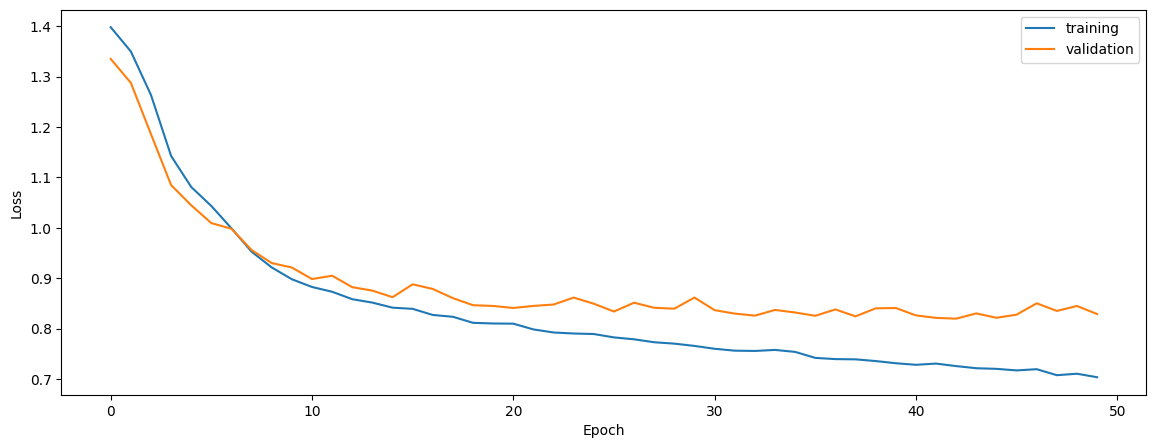

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7139504227320614
0.6839762795728334
0.7011098183120021


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7139504227320614
0.6839762795728334
0.7011098183120021


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7103366978560377
0.6794165646674827
0.7019867549668874


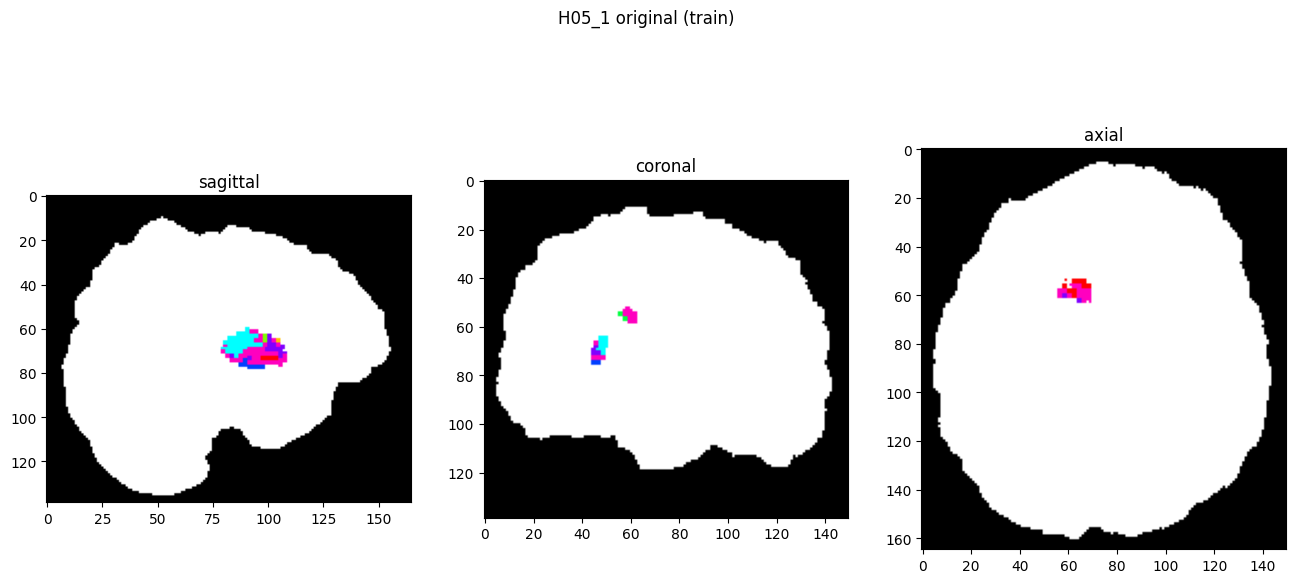

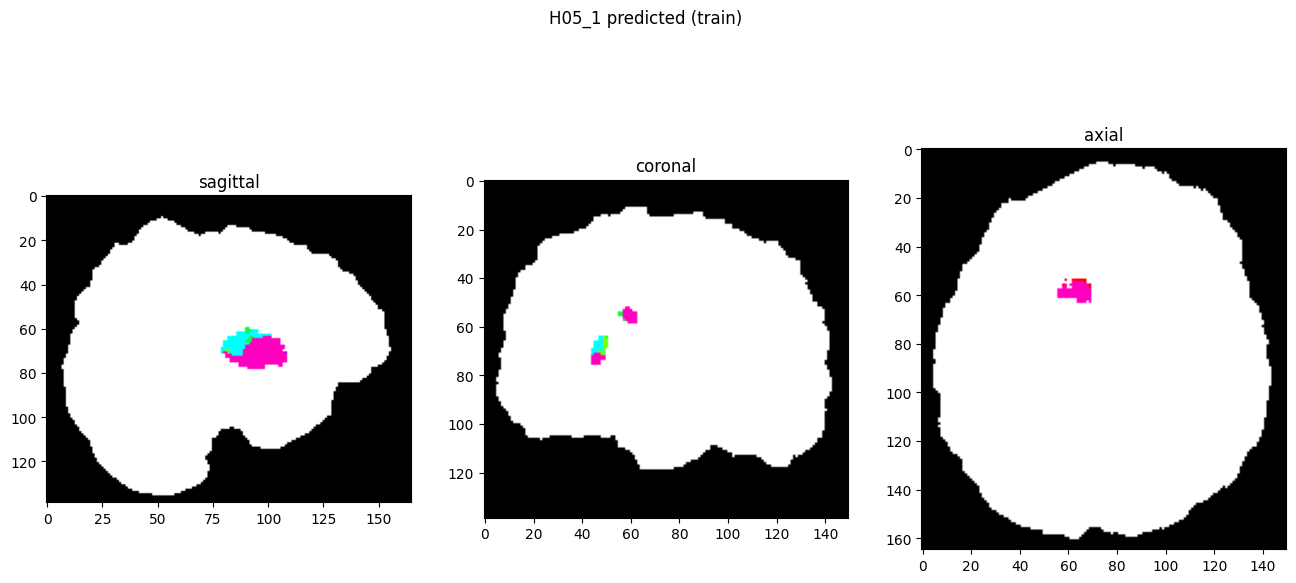

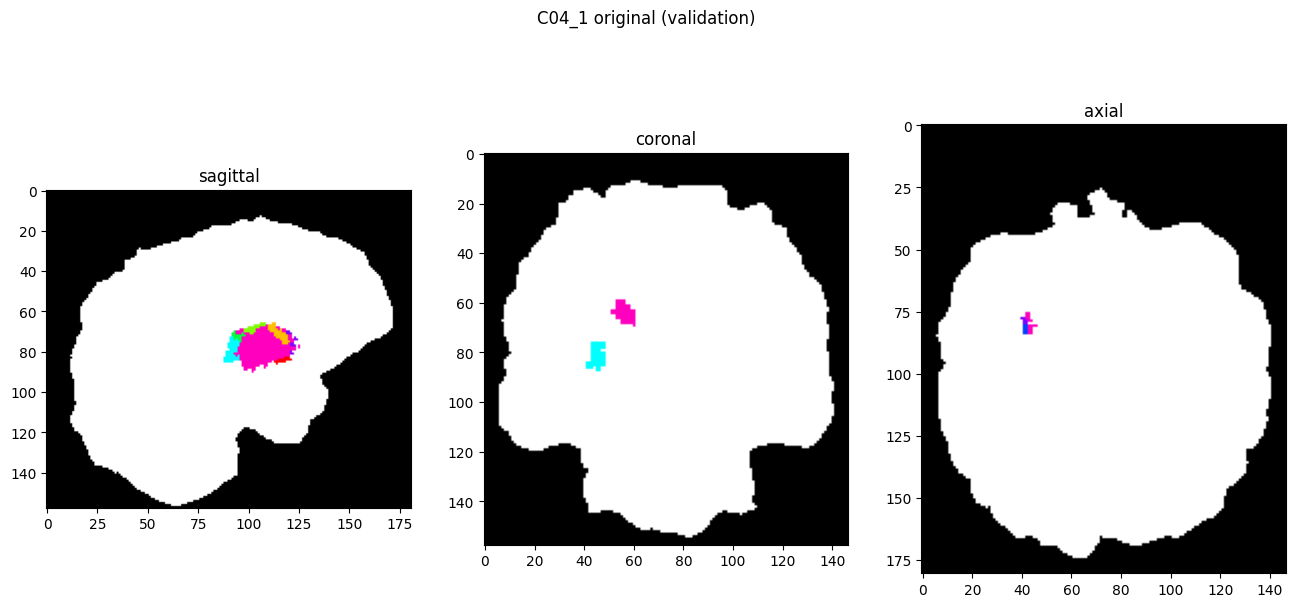

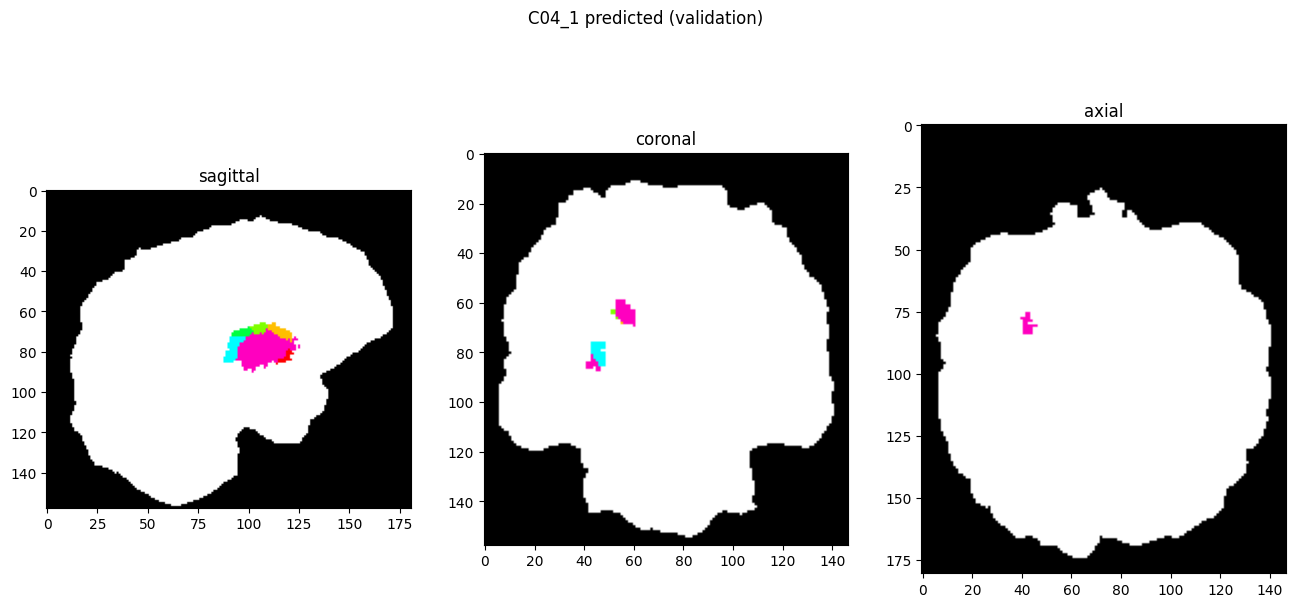

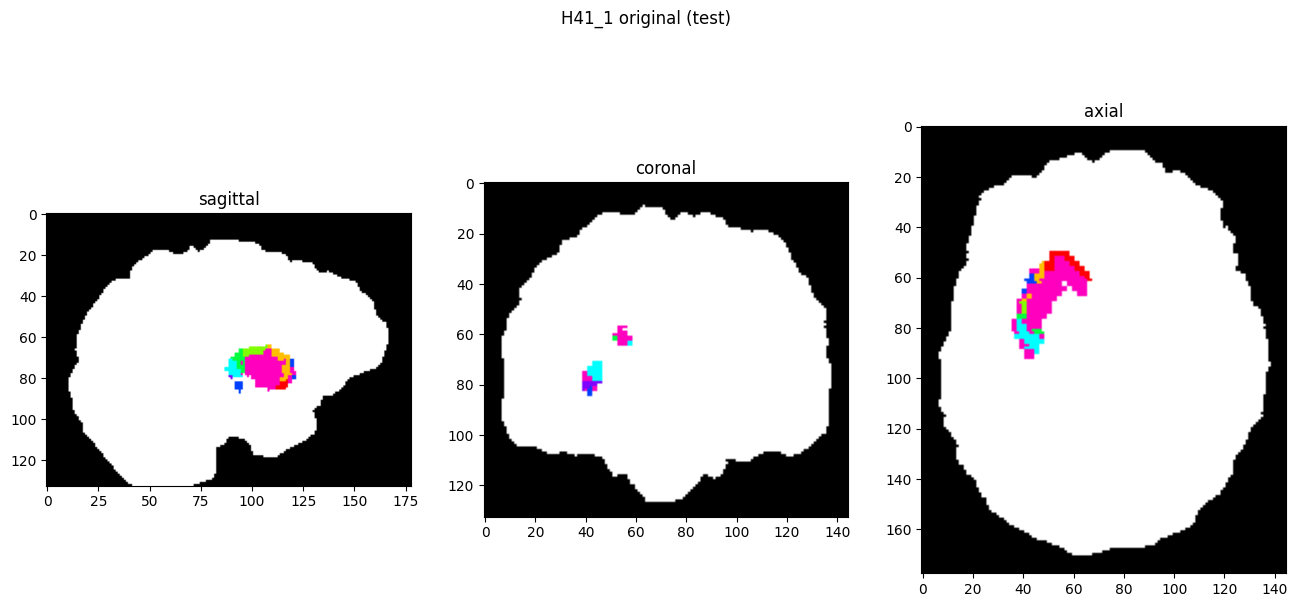

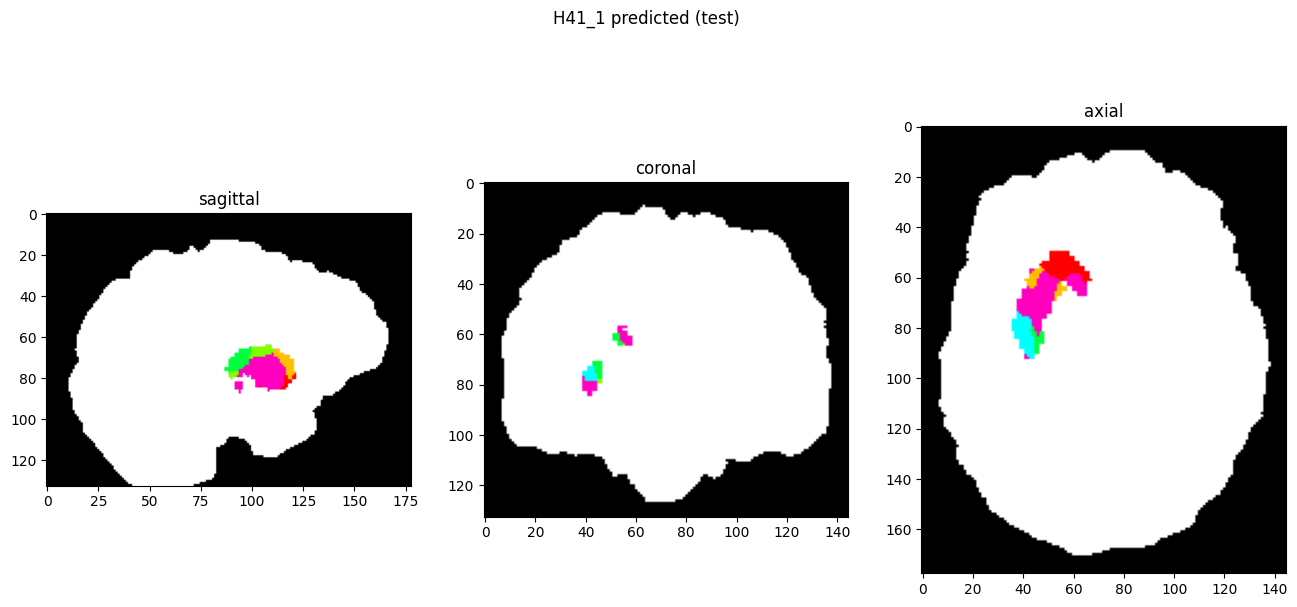

In [10]:
showResults(model, gen, threshold=0)